# BeatTeller: Tempo Detection using Machine Learning
BeatTeller is machine learning model which aims to improve already existing tempo detection algorithms via machine learning.
- `pip install librosa` is a wonderful python library with lots of cool audio processing tools.
- This model is trained on a dataset of electronic music tracks with known tempos.
- The model uses that data, combined with features obtained from the wave form via librosa, to predict the tempo of the track.
The model combines traditional audio processing techniques with deep learning to provide accurate tempo predictions.

## Dataset
- Custom dataset of electronic music tracks with known tempos
- Files are named with their tempo: e.g. "140 Artist - Track.mp3"
- Uses middle section of tracks to avoid intros without beat structure
- download ![here](https://drive.google.com/drive/folders/1Ga60S47Ap-Stp6Bspx79KQG6hZIkGvV_?usp=sharing)
  - warning: this dataset is quite large (~1.6GB). I plan to serialize the librosa spectral data eventually, but I wanted to priotitize running initial initial tests.
## Approach
1. Extract audio features using librosa
2. Combine ML predictions with librosa's tempo detection
3. Train model to learn optimal weighting between the two methods

First, I'll need a Dataset class so that I can consistently load and preprocess the data. By inheriting from the Dataset (pytorch) class, I can use the same methods to load the data for training and testing. (I know this is machine learning, but OOP FTW!).  

For now, I've prepared ~60 songs with known tempos.  Since I've been making and playing music for a while, I have more than enough audio files with known tempos to make my own dataset.  It will be more tedious than anything, as I'll need to manually label each track.  Since many electronic songs have atmospheric or ambient elements in their intros, I'll start 1/3 into the track to avoid confusing the model.

To label my data in a way python can easily understand, I'll process the file name of each song as a string and extract the tempo from it.
 
### RekordboxAudioDataset
- audio_dir: Directory containing audio files with tempo prefixes
- Format example: '140 Doctor P - Watch Out.mp3'

In [1]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
from tinytag import TinyTag
from torch.utils.data import random_split
from datetime import datetime
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

In [22]:
class RekordboxAudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform
        self.audio_files = []
        self.true_tempos = []
        self.librosa_tempos = []
        self.onset_strengths = []
        self.features = []
        
        tempo_pattern = re.compile(r'^(\d+\.?\d*)\s+(.+)$')
        
        all_audio_files = [f for f in os.listdir(audio_dir) 
                          if f.endswith(('.mp3', '.wav', '.aiff', '.m4a'))]
        unsuccessful_files = []
        
        for filename in all_audio_files:
            match = tempo_pattern.match(filename)
            if match:
                try:
                    true_tempo = float(match.group(1))
                    audio_path = os.path.join(audio_dir, filename)
                    
                    tag = TinyTag.get(audio_path)
                    offset = tag.duration / 3 if tag.duration else 0
                    y, sr = librosa.load(audio_path, offset=offset, duration=30)
                    
                    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
                    librosa_tempo = float(tempo.item())
                    
                    if librosa_tempo < 78 or librosa_tempo > 155:
                        librosa_tempo = self.normalize_tempo(librosa_tempo, true_tempo)
                    
                    features = self._extract_features(y, sr)
                    if features.shape[0] != 34: 
                        print(f"Skipping {filename}: Unexpected feature shape {features.shape}")
                        continue
                    
                    self.audio_files.append(filename)
                    self.true_tempos.append(true_tempo)
                    self.librosa_tempos.append(librosa_tempo)
                    self.features.append(features)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue
            else:
                unsuccessful_files.append(filename)
        
        print(f"Successfully loaded {len(self.audio_files)} files")
        if len(unsuccessful_files) != 0:
            print(f"Failed to load {len(unsuccessful_files)} files:")
            for file in unsuccessful_files:
                print(f"  - {file}")
        
        if len(self.audio_files) == 0:
            raise Exception("No valid audio files found with tempo labels")
    
    def normalize_tempo(self, librosa_tempo, true_tempo):
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo

    def normalize_targets(self, true_tempo, librosa_tempo):
        return (true_tempo - 78) / 77, (librosa_tempo - 78) / 77

    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        try:
            true_tempo = self.true_tempos[idx]
            librosa_tempo = self.librosa_tempos[idx]
            features = self.features[idx]
            
            if self.transform:
                features = self.transform(features)
            
            features = torch.FloatTensor(features)
            
            # Make librosa tempo more prominent:
            librosa_tempo_norm = (librosa_tempo - 78) / 77
            
            # Create a repeated pattern for the librosa tempo
            tempo_channel = torch.tensor([[librosa_tempo_norm] * features.shape[1]])
            
            # FIXED: Convert to tensor first, then apply exp
            confidence_input = torch.tensor(-min(
                abs(librosa_tempo - 120),
                abs(librosa_tempo - 128),
                abs(librosa_tempo - 140)
            ) / 20.0)
            tempo_confidence = torch.exp(confidence_input)  # Now using torch.exp on a tensor
            
            # Ensure tempo_confidence has the right shape
            tempo_confidence = tempo_confidence.view(1, -1).expand(1, features.shape[1])
            
            features = torch.cat([
                tempo_channel,
                tempo_confidence,
                features
            ], dim=0)
            
            true_tempo_norm = (true_tempo - 78) / 77
            target = torch.tensor([true_tempo_norm], dtype=torch.float32)
            
            return features, target
                
        except Exception as e:
            print(f"Error loading item {idx} ({self.audio_files[idx]}): {str(e)}")
            return torch.zeros((34, 1292), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)

    def _extract_features(self, y, sr):
        try:
            # Fixed parameters
            hop_length = 512
            n_fft = 1024
            
            # Ensure audio length is consistent
            target_length = 30 * sr
            if len(y) > target_length:
                y = y[:target_length]
            elif len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)))
            
            # Core rhythm features
            onset_env = librosa.onset.onset_strength(
                y=y, 
                sr=sr,
                hop_length=hop_length
            )
            onset_env = librosa.util.normalize(onset_env)
            
            # Beat tracking with two different configurations
            tempo1, beats1 = librosa.beat.beat_track(
                y=y, sr=sr, 
                hop_length=hop_length, 
                start_bpm=120, 
                tightness=100
            )
            
            tempo2, beats2 = librosa.beat.beat_track(
                y=y, sr=sr, 
                hop_length=hop_length, 
                start_bpm=140, 
                tightness=50
            )
            
            # Convert beats to onset envelopes
            beat_env1 = np.zeros(len(onset_env))
            beat_env2 = np.zeros(len(onset_env))
            beat_frames1 = beats1[beats1 < len(beat_env1)]
            beat_frames2 = beats2[beats2 < len(beat_env2)]
            beat_env1[beat_frames1] = 1.0
            beat_env2[beat_frames2] = 1.0
            
            # Compute reduced tempogram (fewer bands)
            tempogram = librosa.feature.tempogram(
                onset_envelope=onset_env,
                sr=sr,
                hop_length=hop_length,
                win_length=384
            )
            
            # Reduce to fewer bands
            n_bands = 29  # Much smaller than before
            tempogram_reduced = np.zeros((n_bands, tempogram.shape[1]))
            band_size = tempogram.shape[0] // n_bands
            for i in range(n_bands):
                start_idx = i * band_size
                end_idx = (i + 1) * band_size
                tempogram_reduced[i] = np.mean(tempogram[start_idx:end_idx], axis=0)
            tempo1_norm = (tempo1 - 78) / 77
            tempo2_norm = (tempo2 - 78) / 77
            
            # Stack features - now only 32 total features
            features = np.vstack([
                onset_env.reshape(1, -1),      # 1 band
                beat_env1.reshape(1, -1),      # 1 band
                beat_env2.reshape(1, -1),      # 1 band
                np.full((1, onset_env.shape[0]), tempo1_norm),  # Additional tempo feature
                np.full((1, onset_env.shape[0]), tempo2_norm),  # Additional tempo feature
                tempogram_reduced              # 29 bands
            ])
            
            # Verify new shape (32 features)
            assert features.shape[0] == 34, f"Expected 32 frequency bins, got {features.shape[0]}"
            
            # Normalize
            features = (features - features.mean()) / (features.std() + 1e-8)
            
            return features
                
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return np.zeros((34, 1292))  # Adjusted shape
        

Now that I have a framework for processing audio files, I can initialize the dataset:
- tempos are normalized to be within 78-155 BPM
- onset strength is normalized to be between 0 and 1

In [23]:
audio_dir = "TellerNet/data/beatbank_test_audios"
dataset = RekordboxAudioDataset(audio_dir)

Successfully loaded 196 files


With the dataset initialized, I'd first like to run some tests to see how well librosa is at predicting tempos on its own.  I'll get all of the `true_tempos` and `librosa_tempos` from the dataset and then compare them both with text and visually.


Librosa Accuracy:
Within 5 BPM: 85.2%
Within 10 BPM: 85.7%
Average BPM difference: 6.6


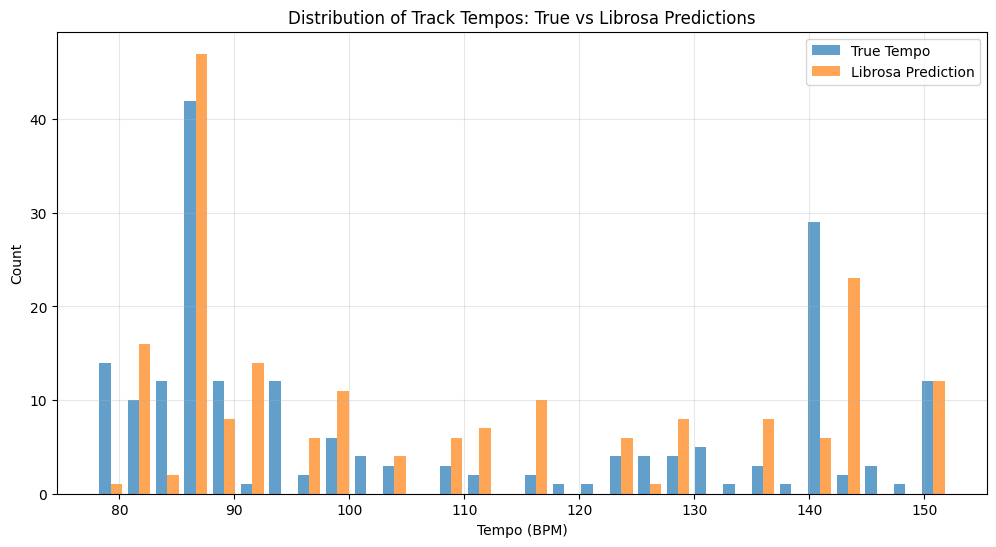

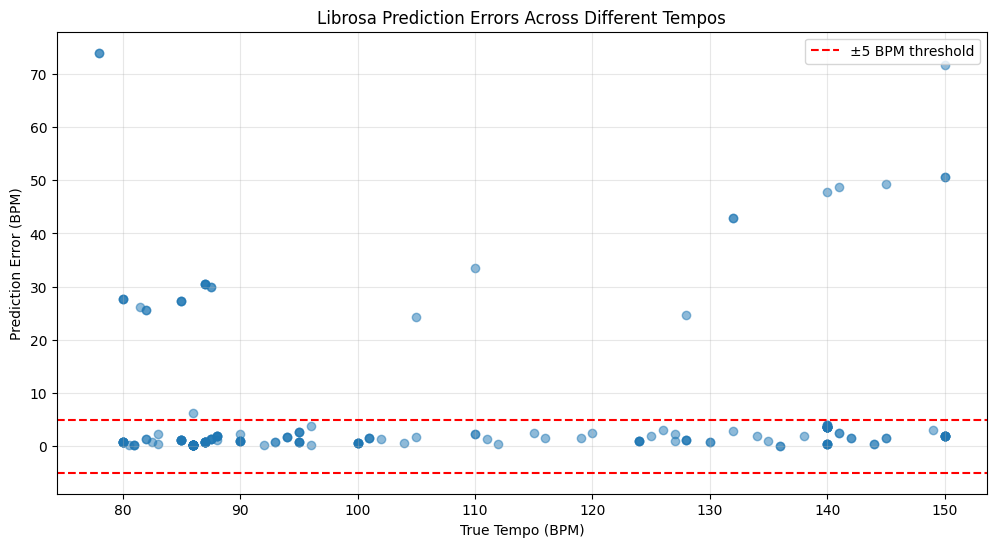

In [24]:
# Calculate librosa's accuracy
true_tempos = np.array(dataset.true_tempos).flatten()
librosa_tempos = np.array(dataset.librosa_tempos).flatten()
tempo_differences = np.abs(true_tempos - librosa_tempos)

within_5_bpm = np.mean(tempo_differences < 5) * 100
within_10_bpm = np.mean(tempo_differences < 10) * 100

print(f"\nLibrosa Accuracy:")
print(f"Within 5 BPM: {within_5_bpm:.1f}%")
print(f"Within 10 BPM: {within_10_bpm:.1f}%")
print(f"Average BPM difference: {np.mean(tempo_differences):.1f}")

# Visualize tempo distributions
plt.figure(figsize=(12, 6))
plt.hist([true_tempos, librosa_tempos], 
         label=['True Tempo', 'Librosa Prediction'],
         alpha=0.7,
         bins=30)
plt.xlabel('Tempo (BPM)')
plt.ylabel('Count')
plt.title('Distribution of Track Tempos: True vs Librosa Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize prediction errors
plt.figure(figsize=(12, 6))
plt.scatter(true_tempos, tempo_differences, alpha=0.5)  # Using flattened arrays
plt.xlabel('True Tempo (BPM)')
plt.ylabel('Prediction Error (BPM)')
plt.title('Librosa Prediction Errors Across Different Tempos')
plt.axhline(y=5, color='r', linestyle='--', label='±5 BPM threshold')
plt.axhline(y=-5, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

results (204 beats):
```
Librosa Accuracy:
Within 5 BPM: 59.1%
Within 10 BPM: 59.1%
Average BPM difference: 28.1
```
![true vs librosa tempo](output_librosa_204-1.png)
![error across tempos](output_librosa_204-1.png)


results after normalizing tempo to 78-155 BPM:
```
Librosa Accuracy:
Within 5 BPM: 85.2%
Within 10 BPM: 85.7%
Average BPM difference: 6.6
```
![true vs librosa tempo](output_librosa_204-1.png)
![error across tempos](output_librosa_204-1.png)


![true vs librosa tempo](out_lib_3-2.png)
![error across tempos](out_lib_3-2.png)


As seen here, librosa is *just okay* at analyzing tempos.  With machine learning, we can make it better. An average BPM error of 24.24.5BPM isn't particularly useful.  With DJ's needing precise tempo estimations, improvements in accuracy are needed if before this will ever get used in a real-world setting.

Looking at the graphs, when librosa is wrong, it's *very* wrong.  On the other hand, librosa's accurate predictions are very close to the mark.  With this in mind, I decided to normalize the librosa tempos to be within 78-155 BPM.  I did this inside of the loop, so that each song's tempo gets normalized to be within the same range.  This gets rid of a lot of the "tempo vagueness" outliers (e.g. a song being labeled as 80BPM instead of 160BPM).

As a result, massive increases were observed in the accuracy of librosa's tempo predictions (average error went from 28BPM to 6!).  This will provide a better foundation for training the model.

It's time to see if we can use machine learning to improve librosa's accuracy. I'll make another class for the model, and then I'll train it on the dataset.

In [25]:
import torch
import torch.nn as nn

class TellerNet(nn.Module):
    def __init__(self):
        super(TellerNet, self).__init__()
        
        self.freq_convs = nn.Sequential(
            nn.Conv2d(34, 64, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.attention = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        self.regression_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(0.2),
            
            nn.Linear(32, 1)
        )
        
        self.tempo_scaling = nn.Parameter(torch.ones(1))
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Reshape input from [batch, 34, 1292] to [batch, 34, H, W]
        # Split the 1292 dimension into height and width for 2D convolution
        x = x.view(batch_size, 34, 1, -1)  # Now [batch, 34, 1, 1292]
        
        conv_out = self.freq_convs(x)
        
        attention_weights = self.attention(conv_out)
        attended_features = conv_out * attention_weights
        
        lstm_input = attended_features.permute(0, 2, 3, 1)
        lstm_input = lstm_input.contiguous().view(batch_size, -1, 64)
        
        lstm_out, _ = self.lstm(lstm_input)
        
        pooled = torch.mean(lstm_out, dim=1)
        
        output = self.regression_head(pooled)
        
        output = output * self.tempo_scaling
        
        return output




In [26]:
batch_size = 4
channels = 34
height = 1
width = 1292
sample_input = torch.randn(batch_size, channels, height, width)
model = TellerNet()
output = model(sample_input)
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([4, 34, 1, 1292])
Output shape: torch.Size([4, 1])


Now, time for the training parameters:
- 80/20 split
- logging via csv as well as png for visualization / analysis
- batch sizes (might change later)
    - 32 for training
    - 16 for validation


In [27]:
class EMA:
    def __init__(self, model, decay=0.999, device=None):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.device = device if device else next(model.parameters()).device

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone().detach().to(self.device)

    def update(self):
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    assert name in self.shadow
                    new_average = (self.decay * self.shadow[name] + 
                                 (1.0 - self.decay) * param.data.to(self.device))
                    self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name].clone()

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name].clone()
        self.backup = {}

### Parameters

In [34]:
class TempoBucketLoss(nn.Module):
    def __init__(self, min_bpm=78, max_bpm=155, bucket_weights=None):
        super().__init__()
        self.scale = (max_bpm - min_bpm) / 2
        self.offset = min_bpm
        self.bucket_weights = bucket_weights or torch.tensor([1.0, 1.0, 1.0])
       
    def forward(self, pred, target):
        # Ensure pred and target have same shape
        pred = pred.squeeze()  # Remove extra dimensions
        target = target.squeeze()  # Remove extra dimensions
        
        mse_loss = F.mse_loss(pred, target)
       
        # Denormalize using just the values, not trying to index
        pred_tempo = pred * self.scale + self.offset
        target_tempo = target * self.scale + self.offset
       
        # Create tempo buckets
        slow_mask = target_tempo < 100
        mid_mask = (target_tempo >= 100) & (target_tempo < 130)
        fast_mask = target_tempo >= 130
       
        # Calculate losses with better numerical stability
        slow_loss = torch.where(slow_mask.any(),
                              F.mse_loss(pred_tempo[slow_mask], target_tempo[slow_mask], reduction='mean'),
                              torch.tensor(0., device=pred.device))
        mid_loss = torch.where(mid_mask.any(),
                             F.mse_loss(pred_tempo[mid_mask], target_tempo[mid_mask], reduction='mean'),
                             torch.tensor(0., device=pred.device))
        fast_loss = torch.where(fast_mask.any(),
                              F.mse_loss(pred_tempo[fast_mask], target_tempo[fast_mask], reduction='mean'),
                              torch.tensor(0., device=pred.device))
       
        # Weighted average of bucket losses
        num_active_buckets = (slow_mask.any() + mid_mask.any() + fast_mask.any()).float()
        bucket_losses = torch.stack([slow_loss, mid_loss, fast_loss])
        
        # Move bucket_weights to the same device as the tensors
        bucket_weights = self.bucket_weights.to(pred.device)
        bucket_loss = (bucket_losses * bucket_weights).sum() / (num_active_buckets + 1e-8)
       
        return mse_loss + bucket_loss

In [35]:
# hyperparameters
batch_size = 16
num_epochs = 200
base_lr = 1e-4
max_lr = 5e-4
weight_decay = 0.01
warmup_epochs = 10
patience_val = 10
decay_val = 1e-5
factor_val = 0.8

# Dataset setup
train_ratio = 0.85
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Create splits with fixed seed for reproducibility
train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True 
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TellerNet().to(device)

# EMA setup
ema = EMA(model, decay=0.999, device=device)
ema.register()

# Loss function setup
criterion = TempoBucketLoss()

# Optimizer setup
optimizer = optim.AdamW(
    model.parameters(),
    lr=base_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=warmup_epochs/num_epochs,
    div_factor=10,
    final_div_factor=100
)

# Logging setup
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = os.path.join('logs')
os.makedirs(log_dir, exist_ok=True)

# Training metrics tracking
columns = ['Epoch', 'Training_Loss', 'Validation_Loss', 
          'Avg_BPM_Error', 'Max_BPM_Error', 'Learning_Rate']
training_log = pd.DataFrame(columns=columns)

# Initialize tracking variables
train_losses = []
val_losses = []
epoch_errors = []
best_val_loss = float('inf')


#### helper functions for training loop

In [36]:

def get_warmup_lr(epoch, warmup_epochs, initial_lr, target_lr):
    if epoch >= warmup_epochs:
        return target_lr
    return initial_lr + (target_lr - initial_lr) * (epoch / warmup_epochs)
def denormalize_targets(self, true_tempo_norm, librosa_tempo_norm):
    return (true_tempo_norm * 77) + 78, (librosa_tempo_norm * 77) + 78

With all the data loaded, I can now see how my model does on the test set.
- Kaimer initialization for weights to improve starting accuracy
- I need to restart my computer.... lol
- serializing the data might improve performance, my computer is strugglingz

### Training Loop

In [37]:
import shutil


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def validation_step(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    val_bpm_errors = []
    
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.squeeze(1).to(device)
            
            outputs = model(features)
            loss = criterion(outputs, targets)
            
            # Denormalize for BPM error calculation
            outputs_denorm = outputs.detach().cpu().numpy()
            targets_denorm = targets.detach().cpu().numpy()
            true_tempos = (targets_denorm[:, 0] * 77) + 78
            pred_tempos = (outputs_denorm[:, 0] * 77) + 78
            
            val_loss += loss.item()
            bpm_errors = np.abs(true_tempos - pred_tempos)
            val_bpm_errors.extend(bpm_errors)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_bpm_error = np.mean(val_bpm_errors)
    max_bpm_error = np.max(val_bpm_errors)
    
    return avg_val_loss, avg_bpm_error, max_bpm_error

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copy(filename, 'model_best.pth.tar')

In [39]:
import torch.nn.functional as F
import numpy as np
# tqdm (progress bar)
from tqdm import tqdm

def debug_training_loop(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    train_loss = 0.0
    train_bpm_errors = []
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    
    for batch_idx, (features, targets) in enumerate(pbar):
        try:
            print(f"\nBatch {batch_idx} shapes:")
            print(f"Features shape: {features.shape}")
            print(f"Targets shape: {targets.shape}")
            
            features = features.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(features)
            print(f"Output shape: {outputs.shape}")
            print(f"Sample output values: {outputs[0]}")
            
            loss = criterion(outputs, targets)
            
            # Print intermediate values for debugging
            print(f"Loss value: {loss.item()}")
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        except Exception as e:
            print(f"Error processing batch {batch_idx}: {str(e)}")
            import traceback
            print(traceback.format_exc())  # This will print the full error traceback
            continue
    
    return train_loss / len(train_loader)

# Replace your training phase with this:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    try:
        avg_train_loss = debug_training_loop(model, train_loader, optimizer, criterion, device, epoch)
    except Exception as e:
        print(f"Training failed at epoch {epoch+1}: {str(e)}")
        break

Epoch 1/200


Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4620], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 815.7507934570312


Epoch 1:   9%|▉         | 1/11 [00:00<00:04,  2.27it/s, loss=473]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1518], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 473.466064453125


Epoch 1:  45%|████▌     | 5/11 [00:00<00:00,  8.86it/s, loss=488]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2343], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 779.4723510742188

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5024], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 551.1011352539062

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3096], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 487.9678955078125

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4215], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 487.99761962890625

Batch 6 shapes:
Features shape

Epoch 1: 100%|██████████| 11/11 [00:00<00:00, 11.31it/s, loss=139]



Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2512], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 741.4252319335938

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6021], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 134.16033935546875

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5689], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 532.2188720703125

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4004], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 139.23265075683594
Epoch 2/200


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s, loss=622]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6122], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 775.2268676757812

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2629], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 622.1477661132812


Epoch 2:  27%|██▋       | 3/11 [00:00<00:00, 26.26it/s, loss=325]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4184], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 434.4234313964844

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2376], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 439.6908874511719

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0493], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 325.05438232421875


Epoch 2:  55%|█████▍    | 6/11 [00:00<00:00, 26.65it/s, loss=478]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6276], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 477.8099060058594

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3067], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 158.82833862304688


Epoch 2:  82%|████████▏ | 9/11 [00:00<00:00, 26.30it/s, loss=239]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8830], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 368.90625

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6962], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 239.0724334716797

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4360], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 225.73074340820312


Epoch 2: 100%|██████████| 11/11 [00:00<00:00, 27.15it/s, loss=190]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6146], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 190.0905303955078
Epoch 3/200


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s, loss=323]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6287], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 323.31610107421875

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6857], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 346.5243225097656


Epoch 3:  27%|██▋       | 3/11 [00:00<00:00, 26.61it/s, loss=157]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5443], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 156.84017944335938

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0494], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 303.0892639160156


Epoch 3:  27%|██▋       | 3/11 [00:00<00:00, 26.61it/s, loss=303]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4115], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 168.8697509765625


Epoch 3:  55%|█████▍    | 6/11 [00:00<00:00, 26.93it/s, loss=300]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3481], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 205.49017333984375

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5250], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 299.52020263671875


Epoch 3:  55%|█████▍    | 6/11 [00:00<00:00, 26.93it/s, loss=209]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8424], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 301.8468017578125

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3105], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 209.38809204101562


Epoch 3:  82%|████████▏ | 9/11 [00:00<00:00, 26.40it/s, loss=209]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9649], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 195.29579162597656


Epoch 3: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s, loss=223]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3171], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 223.37844848632812
Epoch 4/200


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0531], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 247.12156677246094


Epoch 4:  27%|██▋       | 3/11 [00:00<00:00, 26.59it/s, loss=190]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4517], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 105.35443878173828

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3305], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 189.7760009765625

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1676], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 264.85888671875


Epoch 4:  27%|██▋       | 3/11 [00:00<00:00, 26.59it/s, loss=149]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3015], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 149.28802490234375


Epoch 4:  55%|█████▍    | 6/11 [00:00<00:00, 26.75it/s, loss=163]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 163.06321716308594


Epoch 4:  55%|█████▍    | 6/11 [00:00<00:00, 26.75it/s, loss=156]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4334], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 233.63259887695312

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3041], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 155.650390625

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6768], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 591.2720336914062


Epoch 4:  82%|████████▏ | 9/11 [00:00<00:00, 26.19it/s, loss=591]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2615], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 191.56195068359375


Epoch 4: 100%|██████████| 11/11 [00:00<00:00, 27.29it/s, loss=223]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.9069], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 223.4434051513672
Epoch 5/200


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0560], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.06197357177734


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s, loss=230]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0409], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 265.8804931640625

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1218], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 229.54087829589844


Epoch 5:  27%|██▋       | 3/11 [00:00<00:00, 25.13it/s, loss=98.1]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2635], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 98.12701416015625

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3608], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 193.32635498046875


Epoch 5:  27%|██▋       | 3/11 [00:00<00:00, 25.13it/s, loss=127] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8325], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 127.32450103759766


Epoch 5:  55%|█████▍    | 6/11 [00:00<00:00, 25.71it/s, loss=188]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4471], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 133.51548767089844

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4967], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 188.43992614746094

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6296], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 319.9868469238281


Epoch 5:  82%|████████▏ | 9/11 [00:00<00:00, 26.32it/s, loss=459]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3660], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 458.706298828125

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8984], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.33154296875


Epoch 5: 100%|██████████| 11/11 [00:00<00:00, 27.19it/s, loss=61.3]


Epoch 6/200


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2156], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 196.95175170898438


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s, loss=65.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2118], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 65.28768920898438

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8346], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 140.86929321289062


Epoch 6:  27%|██▋       | 3/11 [00:00<00:00, 26.70it/s, loss=141]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1354], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 227.6690673828125


Epoch 6:  27%|██▋       | 3/11 [00:00<00:00, 26.70it/s, loss=593]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3274], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 593.0211791992188


Epoch 6:  55%|█████▍    | 6/11 [00:00<00:00, 27.12it/s, loss=299]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0274], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 299.32733154296875

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0619], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 473.5413513183594


Epoch 6:  55%|█████▍    | 6/11 [00:00<00:00, 27.12it/s, loss=474]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4384], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 317.5660705566406


Epoch 6:  82%|████████▏ | 9/11 [00:00<00:00, 27.20it/s, loss=173]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3070], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 172.9647979736328

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4475], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 148.39207458496094


Epoch 6: 100%|██████████| 11/11 [00:00<00:00, 28.05it/s, loss=78.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2110], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.38971710205078
Epoch 7/200


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s, loss=134]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0244], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 133.82867431640625

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4717], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 465.3021545410156


Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s, loss=465]


Batch 2 shapes:

Epoch 7:  27%|██▋       | 3/11 [00:00<00:00, 25.54it/s, loss=164]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7286], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 291.42974853515625

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0188], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 163.84478759765625

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3487], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 99.31169128417969


Epoch 7:  27%|██▋       | 3/11 [00:00<00:00, 25.54it/s, loss=99.3]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 7:  55%|█████▍    | 6/11 [00:00<00:00, 26.88it/s, loss=76.5]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3569], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 563.577392578125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3562], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.4587631225586

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7758], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 105.33769989013672


Epoch 7:  82%|████████▏ | 9/11 [00:00<00:00, 27.08it/s, loss=164] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1241], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 239.6798553466797

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8976], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 164.22084045410156

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5316], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 119.92235565185547


Epoch 7: 100%|██████████| 11/11 [00:00<00:00, 27.85it/s, loss=120]


Epoch 8/200


Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s, loss=71.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1637], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 102.51203918457031

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6975], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 213.66433715820312

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1091], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 71.66576385498047


Epoch 8:  27%|██▋       | 3/11 [00:00<00:00, 26.73it/s, loss=96.7]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0608], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 164.6243133544922

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5991], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.72502899169922

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2243], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 316.9592590332031


Epoch 8:  55%|█████▍    | 6/11 [00:00<00:00, 27.36it/s, loss=227] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1170], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 231.6225128173828

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6078], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 226.5929412841797

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6409], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 347.44110107421875


Epoch 8: 100%|██████████| 11/11 [00:00<00:00, 28.32it/s, loss=69.2]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3289], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 318.2626647949219

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.9082], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.23790740966797
Epoch 9/200


Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s, loss=240]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5282], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 239.99234008789062


Epoch 9:  27%|██▋       | 3/11 [00:00<00:00, 27.12it/s, loss=341]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0004], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.26500701904297

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2818], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 340.5994873046875

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4019], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 213.06272888183594


Epoch 9:  27%|██▋       | 3/11 [00:00<00:00, 27.12it/s, loss=143]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8596], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 142.7379913330078

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9392], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 137.013671875


Epoch 9:  55%|█████▍    | 6/11 [00:00<00:00, 27.61it/s, loss=155]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9084], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 172.8685760498047

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2922], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 155.47671508789062

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1150], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 234.9736785888672


Epoch 9: 100%|██████████| 11/11 [00:00<00:00, 28.41it/s, loss=68.4]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8056], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 179.65599060058594

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([-0.0260], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.37459564208984
Epoch 10/200


Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4223], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 148.7100372314453


Epoch 10:  27%|██▋       | 3/11 [00:00<00:00, 28.19it/s, loss=48.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1406], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 102.91632843017578

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1902], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.30735778808594

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6660], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 112.6904067993164


Epoch 10:  27%|██▋       | 3/11 [00:00<00:00, 28.19it/s, loss=71.6]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2255], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 177.8904266357422

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7387], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 71.55638885498047


Epoch 10:  55%|█████▍    | 6/11 [00:00<00:00, 28.23it/s, loss=71.6]


Batch 6 shapes:

Epoch 10:  82%|████████▏ | 9/11 [00:00<00:00, 28.06it/s, loss=405] 


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7202], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 212.41616821289062

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1701], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.124279022216797

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2709], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 404.60675048828125

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7553], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 388.9969177246094


Epoch 10: 100%|██████████| 11/11 [00:00<00:00, 29.12it/s, loss=253]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2737], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 252.53515625
Epoch 11/200


Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s, loss=61.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3111], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.74319839477539


Epoch 11:  27%|██▋       | 3/11 [00:00<00:00, 26.49it/s, loss=267]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4601], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.304962158203125

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3724], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 135.03570556640625

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7081], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 266.6079406738281

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0314], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.3873291015625


Epoch 11:  55%|█████▍    | 6/11 [00:00<00:00, 27.96it/s, loss=128] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6508], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 128.36602783203125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8733], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 221.5198516845703


Epoch 11:  82%|████████▏ | 9/11 [00:00<00:00, 28.48it/s, loss=180]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8063], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 129.85818481445312

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4657], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 265.0547180175781

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3676], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 180.05474853515625

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4494], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 224.09815979003906


Epoch 11: 100%|██████████| 11/11 [00:00<00:00, 29.22it/s, loss=224]


Epoch 12/200


Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s, loss=35.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.93753433227539

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6142], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 107.35433959960938


Epoch 12:  27%|██▋       | 3/11 [00:00<00:00, 28.76it/s, loss=269] 


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2994], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 571.1448974609375

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5565], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 140.14820861816406

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1584], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.5201416015625

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9562], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 268.93402099609375


Epoch 12:  55%|█████▍    | 6/11 [00:00<00:00, 28.90it/s, loss=66.8]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5454], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.8172836303711

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8641], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 167.07083129882812


Epoch 12: 100%|██████████| 11/11 [00:00<00:00, 28.88it/s, loss=51.6]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6670], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 140.0313262939453

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1303], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 109.56903076171875

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7200], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.564090728759766
Epoch 13/200


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1184], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.76228713989258


Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s, loss=530] 


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1880], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 530.313232421875

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3416], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.80047607421875


Epoch 13:  27%|██▋       | 3/11 [00:00<00:00, 28.13it/s, loss=93.7]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2277], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 205.75189208984375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0244], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 93.70465087890625

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2708], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 130.09022521972656


Epoch 13:  55%|█████▍    | 6/11 [00:00<00:00, 28.20it/s, loss=130] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 13:  55%|█████▍    | 6/11 [00:00<00:00, 28.20it/s, loss=66.9]

Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1425], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 125.33592224121094

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0697], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.9170913696289

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7685], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 113.32743835449219


Epoch 13: 100%|██████████| 11/11 [00:00<00:00, 28.38it/s, loss=37.3]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4642], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.87033081054688

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1239], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.313961029052734
Epoch 14/200


Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4070], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 306.9503173828125


Epoch 14:  27%|██▋       | 3/11 [00:00<00:00, 27.72it/s, loss=119]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5148], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 91.37918090820312

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2685], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 118.75525665283203

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3004], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 179.3801727294922


Epoch 14:  27%|██▋       | 3/11 [00:00<00:00, 27.72it/s, loss=66.8]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4578], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.80975341796875

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0596], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 92.58953857421875


Epoch 14:  55%|█████▍    | 6/11 [00:00<00:00, 27.87it/s, loss=92.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 14:  82%|████████▏ | 9/11 [00:00<00:00, 27.93it/s, loss=38.6]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5402], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 236.7677764892578

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7441], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 102.49017333984375

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7684], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.55656051635742

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1846], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 152.5716552734375


Epoch 14: 100%|██████████| 11/11 [00:00<00:00, 28.86it/s, loss=73.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3251], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.36579132080078
Epoch 15/200


Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8077], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 170.74440002441406


Epoch 15:  27%|██▋       | 3/11 [00:00<00:00, 24.32it/s, loss=54.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 218.99656677246094

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2126], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.24681091308594

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3154], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 108.2721176147461


Epoch 15:  27%|██▋       | 3/11 [00:00<00:00, 24.32it/s, loss=153] 


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2009], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 152.96583557128906


Epoch 15:  27%|██▋       | 3/11 [00:00<00:00, 24.32it/s, loss=201]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7666], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 201.02027893066406


Epoch 15:  82%|████████▏ | 9/11 [00:00<00:00, 26.80it/s, loss=217]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2032], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 184.86322021484375

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6837], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 107.12679290771484

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3281], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 216.7468719482422

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1441], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.71944427490234


Epoch 15:  82%|████████▏ | 9/11 [00:00<00:00, 26.80it/s, loss=73.7]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3398], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.64549255371094


Epoch 15: 100%|██████████| 11/11 [00:00<00:00, 27.48it/s, loss=52.6]


Epoch 16/200


Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s, loss=330]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2437], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 329.6944580078125


Epoch 16:  27%|██▋       | 3/11 [00:00<00:00, 23.28it/s, loss=382]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1389], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 134.39784240722656

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4926], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 382.2529296875

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1214], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 231.6326141357422


Epoch 16:  27%|██▋       | 3/11 [00:00<00:00, 23.28it/s, loss=232]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1115], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 162.93865966796875


Epoch 16:  27%|██▋       | 3/11 [00:00<00:00, 23.28it/s, loss=43.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2763], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.36532211303711


Epoch 16:  82%|████████▏ | 9/11 [00:00<00:00, 26.03it/s, loss=122] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6764], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.75163650512695

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4062], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 129.18919372558594

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 121.85479736328125

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5427], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.51962661743164


Epoch 16: 100%|██████████| 11/11 [00:00<00:00, 26.71it/s, loss=45] 



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2862], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.024967193603516
Epoch 17/200


Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2302], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 243.58705139160156


Epoch 17:  27%|██▋       | 3/11 [00:00<00:00, 26.64it/s, loss=369]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2895], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.9735336303711

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3794], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 138.56634521484375

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2216], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 368.9783935546875

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7464], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.60214233398438


Epoch 17:  27%|██▋       | 3/11 [00:00<00:00, 26.64it/s, loss=78.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4221], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 171.54425048828125


Epoch 17:  55%|█████▍    | 6/11 [00:00<00:00, 27.50it/s, loss=172] 


Batch 6 shapes:

Epoch 17:  82%|████████▏ | 9/11 [00:00<00:00, 27.43it/s, loss=148] 


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0797], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.58418273925781

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1596], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.552974700927734

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2955], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.48925018310547

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3845], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 148.2672882080078


Epoch 17: 100%|██████████| 11/11 [00:00<00:00, 27.77it/s, loss=129]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3153], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 128.7724609375
Epoch 18/200


Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6336], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 345.9090576171875


Epoch 18:  27%|██▋       | 3/11 [00:00<00:00, 26.39it/s, loss=102] 


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3415], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 105.82984924316406

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7101], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 97.0652084350586

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1866], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 101.95804595947266

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0042], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.94513702392578


Epoch 18:  27%|██▋       | 3/11 [00:00<00:00, 26.39it/s, loss=64.9]


Batch 5 shapes:

Epoch 18:  55%|█████▍    | 6/11 [00:00<00:00, 27.62it/s, loss=277] 


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7423], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 276.8753967285156

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3928], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 192.8668975830078


Epoch 18:  82%|████████▏ | 9/11 [00:00<00:00, 26.73it/s, loss=46.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0955], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 162.00523376464844

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8710], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.50630569458008

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7045], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.053775787353516

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6043], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 406.0163269042969


Epoch 18: 100%|██████████| 11/11 [00:00<00:00, 28.00it/s, loss=406]


Epoch 19/200


Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s, loss=136]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2876], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 135.56541442871094

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4139], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 77.92613983154297


Epoch 19:  27%|██▋       | 3/11 [00:00<00:00, 28.38it/s, loss=104]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4964], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 220.34507751464844

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3005], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 131.51126098632812

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3596], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.82933807373047

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7453], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.88575744628906


Epoch 19:  55%|█████▍    | 6/11 [00:00<00:00, 28.55it/s, loss=39.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7019], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.88471984863281

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8851], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.67888641357422


Epoch 19: 100%|██████████| 11/11 [00:00<00:00, 28.90it/s, loss=247]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4460], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 221.91317749023438

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1220], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.471986770629883

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1807], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 247.2261505126953
Epoch 20/200


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7678], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 145.3584442138672


Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s, loss=69.1]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7811], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.07164764404297

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7075], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 70.7479248046875


Epoch 20:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=135] 


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0076], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 186.0592041015625

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8564], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 135.486572265625

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3657], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 160.60226440429688


Epoch 20:  55%|█████▍    | 6/11 [00:00<00:00, 28.02it/s, loss=56.2]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0203], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.219573974609375


Epoch 20:  55%|█████▍    | 6/11 [00:00<00:00, 28.02it/s, loss=30.4]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3648], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.413177490234375

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3885], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 291.71392822265625


Epoch 20: 100%|██████████| 11/11 [00:00<00:00, 28.27it/s, loss=41.5]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3953], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.22672271728516

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([-0.0421], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.460933685302734
Epoch 21/200


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s, loss=63.5]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5151], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.53922653198242

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2239], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.12520217895508


Epoch 21:  27%|██▋       | 3/11 [00:00<00:00, 27.05it/s, loss=58.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1901], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.457454681396484

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0914], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.54508209228516


Epoch 21:  27%|██▋       | 3/11 [00:00<00:00, 27.05it/s, loss=164] 


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1890], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 164.14385986328125

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3535], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 240.94735717773438


Epoch 21:  55%|█████▍    | 6/11 [00:00<00:00, 27.45it/s, loss=154]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3106], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 153.8310089111328

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4216], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.62835693359375


Epoch 21:  82%|████████▏ | 9/11 [00:00<00:00, 27.94it/s, loss=66]  


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7938], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.01172637939453

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5303], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.4936752319336


Epoch 21: 100%|██████████| 11/11 [00:00<00:00, 27.97it/s, loss=50.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4594], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.30168151855469
Epoch 22/200


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0649], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 127.86186218261719


Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s, loss=92] 


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6855], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 111.70931243896484

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1913], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 92.01852416992188


Epoch 22:  27%|██▋       | 3/11 [00:00<00:00, 28.54it/s, loss=67.4]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3653], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.40823364257812

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3932], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 115.2525405883789


Epoch 22:  27%|██▋       | 3/11 [00:00<00:00, 28.54it/s, loss=68.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4191], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.44458770751953


Epoch 22:  55%|█████▍    | 6/11 [00:00<00:00, 28.06it/s, loss=37.4]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0677], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.589542388916016

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.378108978271484


Epoch 22:  82%|████████▏ | 9/11 [00:00<00:00, 27.02it/s, loss=124] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6883], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.73796081542969

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4105], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 124.2031021118164


Epoch 22: 100%|██████████| 11/11 [00:00<00:00, 28.15it/s, loss=210]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1939], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 209.74996948242188
Epoch 23/200


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1408], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 133.45660400390625


Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s, loss=147]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3827], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 146.6492919921875

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7755], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 170.4219207763672


Epoch 23:  27%|██▋       | 3/11 [00:00<00:00, 27.22it/s, loss=75.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4661], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 75.61688232421875

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9061], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.14509582519531


Epoch 23:  55%|█████▍    | 6/11 [00:00<00:00, 27.67it/s, loss=63.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9227], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.44674301147461

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8540], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 112.72291564941406


Epoch 23:  55%|█████▍    | 6/11 [00:00<00:00, 27.67it/s, loss=251] 


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3242], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 250.9726104736328


Epoch 23:  82%|████████▏ | 9/11 [00:00<00:00, 27.07it/s, loss=231] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7076], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.66914367675781

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9000], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 231.00927734375

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1101], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.280858993530273


Epoch 23: 100%|██████████| 11/11 [00:00<00:00, 28.12it/s, loss=21.3]


Epoch 24/200


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s, loss=34.5]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2949], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.473941802978516

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1860], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.71389389038086


Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s, loss=31.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4472], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 91.62295532226562


Epoch 24:  27%|██▋       | 3/11 [00:00<00:00, 27.36it/s, loss=25.2]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7430], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.12767028808594

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2170], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.152984619140625


Epoch 24:  55%|█████▍    | 6/11 [00:00<00:00, 27.71it/s, loss=265] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2775], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 124.9488296508789

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1445], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 264.976806640625


Epoch 24:  55%|█████▍    | 6/11 [00:00<00:00, 27.71it/s, loss=244]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0822], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 244.44712829589844


Epoch 24:  82%|████████▏ | 9/11 [00:00<00:00, 26.42it/s, loss=146]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1124], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 145.9684600830078

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4455], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 209.65798950195312


Epoch 24: 100%|██████████| 11/11 [00:00<00:00, 27.51it/s, loss=147]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2453], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 146.86444091796875
Epoch 25/200


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s, loss=69.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2923], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.8014907836914

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8752], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 161.64013671875


Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s, loss=162] 


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3419], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 179.77703857421875


Epoch 25:  27%|██▋       | 3/11 [00:00<00:00, 27.54it/s, loss=107]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8099], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 106.56490325927734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1707], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.924007415771484


Epoch 25:  55%|█████▍    | 6/11 [00:00<00:00, 25.62it/s, loss=75.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0951], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 154.56777954101562

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6716], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 75.05308532714844


Epoch 25:  55%|█████▍    | 6/11 [00:00<00:00, 25.62it/s, loss=73.6]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6127], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.55343627929688


Epoch 25:  82%|████████▏ | 9/11 [00:00<00:00, 26.67it/s, loss=251] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1254], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 85.49271392822266

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1648], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 250.6905059814453


Epoch 25: 100%|██████████| 11/11 [00:00<00:00, 27.44it/s, loss=46.9]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0680], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.88593292236328
Epoch 26/200


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s, loss=61.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8904], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.31228256225586

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7190], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 141.09829711914062


Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s, loss=141] 


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9647], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 101.2674331665039


Epoch 26:  27%|██▋       | 3/11 [00:00<00:00, 26.92it/s, loss=54.2]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7981], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.184078216552734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0132], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 233.80078125


Epoch 26:  55%|█████▍    | 6/11 [00:00<00:00, 26.78it/s, loss=210] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2445], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 87.56737518310547

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2137], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 209.5653076171875

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1000], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.646202087402344


Epoch 26:  55%|█████▍    | 6/11 [00:00<00:00, 26.78it/s, loss=57.6]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 26:  82%|████████▏ | 9/11 [00:00<00:00, 27.43it/s, loss=81.5]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2770], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 182.90370178222656

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2645], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 81.51908874511719

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5888], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 146.11312866210938


Epoch 26: 100%|██████████| 11/11 [00:00<00:00, 28.16it/s, loss=146]


Epoch 27/200


Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s, loss=95.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1661], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.40155029296875

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1573], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 171.36997985839844

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1456], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.76836395263672


Epoch 27:  27%|██▋       | 3/11 [00:00<00:00, 28.40it/s, loss=43.9]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 169.4101104736328

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1407], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.94841766357422

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1668], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 123.6324234008789


Epoch 27:  55%|█████▍    | 6/11 [00:00<00:00, 28.64it/s, loss=73.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3765], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 189.76173400878906

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0682], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.08097076416016

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0525], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 100.093994140625


Epoch 27: 100%|██████████| 11/11 [00:00<00:00, 28.60it/s, loss=50] 



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2495], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.6139907836914

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3491], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.037113189697266
Epoch 28/200


Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:

Epoch 28:  27%|██▋       | 3/11 [00:00<00:00, 27.59it/s, loss=57.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3462], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 150.66360473632812

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2264], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.3766098022461

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9203], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.77011108398438

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0277], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.83711242675781


Epoch 28:  27%|██▋       | 3/11 [00:00<00:00, 27.59it/s, loss=96.4]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3243], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.39934539794922

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1258], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 140.54415893554688


Epoch 28:  82%|████████▏ | 9/11 [00:00<00:00, 27.72it/s, loss=34.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0598], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 116.0975112915039

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2355], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 275.2539367675781

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7882], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.58266830444336

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1792], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.3858528137207


Epoch 28: 100%|██████████| 11/11 [00:00<00:00, 28.65it/s, loss=28.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3376], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.81692886352539
Epoch 29/200


Epoch 29:  18%|█▊        | 2/11 [00:00<00:00, 18.65it/s, loss=48.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2471], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 151.4330596923828

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2311], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 105.59725189208984

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0652], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.869529724121094

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2671], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.56389236450195


Epoch 29:  18%|█▊        | 2/11 [00:00<00:00, 18.65it/s, loss=54.6]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1912], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.54305648803711


Epoch 29:  73%|███████▎  | 8/11 [00:00<00:00, 25.02it/s, loss=123] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.714599609375

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6733], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 139.35379028320312

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2356], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.12660217285156

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 122.78423309326172

Batch 9 shapes:
Features shape:

Epoch 29: 100%|██████████| 11/11 [00:00<00:00, 25.66it/s, loss=214]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4978], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 213.5908203125
Epoch 30/200


Epoch 30:  27%|██▋       | 3/11 [00:00<00:00, 26.98it/s, loss=72.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0110], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.89130401611328

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8779], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.37987518310547

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3958], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 123.0583724975586

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0607], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.83563232421875

Batch 4 shapes:
Features shape:

Epoch 30:  82%|████████▏ | 9/11 [00:00<00:00, 26.06it/s, loss=184] 


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7211], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.876609802246094

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0429], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.74649810791016

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6186], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.38885498046875

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6048], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.79277038574219

Batch 9 shapes:
Features shape: torch.Size([16

Epoch 30: 100%|██████████| 11/11 [00:00<00:00, 27.21it/s, loss=228]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6357], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 228.28904724121094
Epoch 31/200


Epoch 31:  27%|██▋       | 3/11 [00:00<00:00, 26.14it/s, loss=134]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2137], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 99.18074035644531

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0970], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.24470520019531

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6211], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 215.47610473632812

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8776], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 133.5885772705078

Batch 4 shapes:
Features shape

Epoch 31:  82%|████████▏ | 9/11 [00:00<00:00, 27.42it/s, loss=236] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3412], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 107.39018249511719

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0867], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.350637435913086

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.3981704711914

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2159], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.22567749023438

Batch 9 shapes:
Features shape

Epoch 31: 100%|██████████| 11/11 [00:00<00:00, 28.20it/s, loss=236]


Epoch 32/200


Epoch 32:  27%|██▋       | 3/11 [00:00<00:00, 27.74it/s, loss=55.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2878], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.8922119140625

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5826], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 87.28700256347656

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4987], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 79.3174819946289

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0441], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 111.77888488769531

Batch 4 shapes:
Features shape: 

Epoch 32: 100%|██████████| 11/11 [00:00<00:00, 28.78it/s, loss=54.2]



Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8796], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.71458435058594

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6677], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.8331298828125

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8376], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.07209777832031

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9356], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 100.80889129638672

Batch 10 shapes:
Features shape

Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s, loss=94.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1597], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 94.60263061523438


Epoch 33:  27%|██▋       | 3/11 [00:00<00:00, 27.48it/s, loss=83.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2172], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 127.03596496582031

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7981], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 212.04551696777344

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7676], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.2922248840332

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5605], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.75303649902344


Epoch 33:  55%|█████▍    | 6/11 [00:00<00:00, 27.36it/s, loss=89.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1097], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.61100006103516

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4871], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 108.70906829833984


Epoch 33:  82%|████████▏ | 9/11 [00:00<00:00, 27.08it/s, loss=123] 


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2008], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.096630096435547

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6323], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 123.26802825927734

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1697], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.52888870239258


Epoch 33: 100%|██████████| 11/11 [00:00<00:00, 28.00it/s, loss=87.1]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0025], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 87.09154510498047
Epoch 34/200


Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s, loss=42.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2616], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.58726119995117

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1273], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.149940490722656


Epoch 34:  27%|██▋       | 3/11 [00:00<00:00, 25.48it/s, loss=123]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1488], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 124.87545776367188

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2155], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 123.0127182006836

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0915], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 87.88528442382812


Epoch 34:  55%|█████▍    | 6/11 [00:00<00:00, 26.27it/s, loss=90.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1608], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 90.63018035888672

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0512], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.14224624633789


Epoch 34:  82%|████████▏ | 9/11 [00:00<00:00, 26.28it/s, loss=24.8]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3248], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.07002639770508

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9520], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 186.4773712158203

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8655], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.76297378540039


Epoch 34: 100%|██████████| 11/11 [00:00<00:00, 27.05it/s, loss=30.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2612], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.34609031677246
Epoch 35/200


Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s, loss=128]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2497], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 127.88038635253906

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6240], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.36030578613281


Epoch 35:  27%|██▋       | 3/11 [00:00<00:00, 26.61it/s, loss=109]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9238], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 109.21385955810547

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 141.9086456298828


Epoch 35:  27%|██▋       | 3/11 [00:00<00:00, 26.61it/s, loss=19.3]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1926], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.337568283081055


Epoch 35:  55%|█████▍    | 6/11 [00:00<00:00, 24.73it/s, loss=36.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4047], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.152339935302734

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8792], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 126.02994537353516


Epoch 35:  55%|█████▍    | 6/11 [00:00<00:00, 24.73it/s, loss=47]  


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3181], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.99445724487305

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1451], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.99991989135742


Epoch 35:  82%|████████▏ | 9/11 [00:00<00:00, 25.44it/s, loss=76.3]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0739], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.27279663085938

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7014], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 132.170166015625


Epoch 35: 100%|██████████| 11/11 [00:00<00:00, 26.44it/s, loss=132]


Epoch 36/200


Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s, loss=78.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4289], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.6333236694336

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5019], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 106.28414154052734


Epoch 36:  27%|██▋       | 3/11 [00:00<00:00, 24.35it/s, loss=66]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2746], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 65.96516418457031

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0643], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.501163482666016


Epoch 36:  27%|██▋       | 3/11 [00:00<00:00, 24.35it/s, loss=55.5]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4219], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 196.22488403320312


Epoch 36:  55%|█████▍    | 6/11 [00:00<00:00, 26.17it/s, loss=103] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0236], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.5030517578125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0876], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.906822204589844

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6902], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 102.71167755126953


Epoch 36:  82%|████████▏ | 9/11 [00:00<00:00, 26.76it/s, loss=63.6]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1648], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.63267517089844

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7112], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.80909729003906


Epoch 36: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s, loss=98.9]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8165], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 98.8969497680664
Epoch 37/200


Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s, loss=106] 


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5472], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.52119445800781

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8024], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 106.20311737060547

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2115], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.04080581665039


Epoch 37:  27%|██▋       | 3/11 [00:00<00:00, 25.37it/s, loss=94.4]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 94.43903350830078


Epoch 37:  27%|██▋       | 3/11 [00:00<00:00, 25.37it/s, loss=106] 


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2111], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 105.68571472167969


Epoch 37:  55%|█████▍    | 6/11 [00:00<00:00, 25.97it/s, loss=117] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2526], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 84.88612365722656

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1314], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.221338272094727

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3774], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 117.17518615722656


Epoch 37:  82%|████████▏ | 9/11 [00:00<00:00, 26.84it/s, loss=70] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8108], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 70.03881072998047

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2388], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.887441635131836


Epoch 37: 100%|██████████| 11/11 [00:00<00:00, 27.35it/s, loss=93] 



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5109], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 92.99622344970703
Epoch 38/200


Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s, loss=171]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7621], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 170.51051330566406

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7474], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.74208068847656


Epoch 38:  27%|██▋       | 3/11 [00:00<00:00, 22.94it/s, loss=45]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8892], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.95146560668945

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1290], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.47650146484375


Epoch 38:  27%|██▋       | 3/11 [00:00<00:00, 22.94it/s, loss=59.5]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7512], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.513343811035156


Epoch 38:  55%|█████▍    | 6/11 [00:00<00:00, 25.34it/s, loss=216] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.2109489440918

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1839], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 216.0583038330078

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8625], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.40180587768555


Epoch 38:  55%|█████▍    | 6/11 [00:00<00:00, 25.34it/s, loss=40.4]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1541], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 205.10472106933594


Epoch 38:  82%|████████▏ | 9/11 [00:00<00:00, 25.92it/s, loss=42.2]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1947], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.188621520996094

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 102.44178771972656


Epoch 38: 100%|██████████| 11/11 [00:00<00:00, 26.62it/s, loss=102]


Epoch 39/200


Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s, loss=58.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2321], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.05978012084961

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4217], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.343143463134766

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3966], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.554832458496094


Epoch 39:  27%|██▋       | 3/11 [00:00<00:00, 26.26it/s, loss=54.3]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2089], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.313316345214844

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1157], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.36400604248047


Epoch 39:  55%|█████▍    | 6/11 [00:00<00:00, 26.54it/s, loss=57.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1879], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 213.04859924316406

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2099], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.81620788574219

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9440], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.870845794677734


Epoch 39:  82%|████████▏ | 9/11 [00:00<00:00, 26.79it/s, loss=130] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2075], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.862815856933594

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5296], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 130.33535766601562


Epoch 39: 100%|██████████| 11/11 [00:00<00:00, 27.55it/s, loss=64.6]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3125], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.60671997070312
Epoch 40/200


Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s, loss=137]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8564], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 137.0824432373047

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8597], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.00569152832031


Epoch 40:  27%|██▋       | 3/11 [00:00<00:00, 25.32it/s, loss=166]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0629], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 166.09747314453125

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3043], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.0506477355957


Epoch 40:  27%|██▋       | 3/11 [00:00<00:00, 25.32it/s, loss=67.5]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1683], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.52384185791016


Epoch 40:  55%|█████▍    | 6/11 [00:00<00:00, 26.23it/s, loss=119] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 118.93887329101562

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5806], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 101.63157653808594


Epoch 40:  82%|████████▏ | 9/11 [00:00<00:00, 26.76it/s, loss=45.6]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4508], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.617210388183594

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3494], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.60504913330078

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8935], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.843835830688477


Epoch 40: 100%|██████████| 11/11 [00:00<00:00, 27.40it/s, loss=65.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0383], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 65.3882827758789
Epoch 41/200


Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s, loss=144] 


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7631], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.65993881225586

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3050], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 143.92449951171875


Epoch 41:  27%|██▋       | 3/11 [00:00<00:00, 25.76it/s, loss=85.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1242], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 175.8792266845703

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 85.45427703857422

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8450], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.61026382446289


Epoch 41:  27%|██▋       | 3/11 [00:00<00:00, 25.76it/s, loss=58.6]


Batch 5 shapes:

Epoch 41:  55%|█████▍    | 6/11 [00:00<00:00, 27.10it/s, loss=67.1]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3615], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 143.47386169433594

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4132], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.14067077636719

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7344], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.88898849487305


Epoch 41:  82%|████████▏ | 9/11 [00:00<00:00, 27.05it/s, loss=34.3]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0218], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 167.35247802734375

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3978], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.32499694824219

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4303], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 128.27964782714844


Epoch 41: 100%|██████████| 11/11 [00:00<00:00, 27.77it/s, loss=128]


Epoch 42/200


Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s, loss=97.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2002], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.5143051147461

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2008], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 97.3051528930664

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0814], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.057655334472656


Epoch 42:  27%|██▋       | 3/11 [00:00<00:00, 26.39it/s, loss=36.3]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4344], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.2269287109375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1513], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.34113311767578


Epoch 42:  55%|█████▍    | 6/11 [00:00<00:00, 26.95it/s, loss=28.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1333], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.302608489990234

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2043], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.63900375366211

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7704], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.795337677001953


Epoch 42:  82%|████████▏ | 9/11 [00:00<00:00, 27.08it/s, loss=90.7]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7906], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 166.974853515625

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2964], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 90.67125701904297


Epoch 42: 100%|██████████| 11/11 [00:00<00:00, 27.84it/s, loss=33.7]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3468], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.65331268310547
Epoch 43/200


Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s, loss=11.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0017], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.436279296875

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3207], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.622326850891113


Epoch 43:  27%|██▋       | 3/11 [00:00<00:00, 24.54it/s, loss=36]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0328], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.03066635131836

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2543], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.03510665893555

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5616], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.87807083129883


Epoch 43:  55%|█████▍    | 6/11 [00:00<00:00, 25.87it/s, loss=37.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1767], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.36513137817383

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3603], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.61872863769531


Epoch 43:  82%|████████▏ | 9/11 [00:00<00:00, 26.74it/s, loss=175] 


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3134], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 139.5285186767578

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5893], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 175.40003967285156

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8795], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.43571853637695


Epoch 43: 100%|██████████| 11/11 [00:00<00:00, 27.22it/s, loss=118]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4962], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 118.18605041503906
Epoch 44/200


Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s, loss=123]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1385], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 123.04478454589844

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2313], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.07815551757812


Epoch 44:  27%|██▋       | 3/11 [00:00<00:00, 25.29it/s, loss=53.4]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5718], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.05897521972656

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0744], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.350563049316406

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3687], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.64569854736328


Epoch 44:  27%|██▋       | 3/11 [00:00<00:00, 25.29it/s, loss=64.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 44:  55%|█████▍    | 6/11 [00:00<00:00, 27.23it/s, loss=35.8]

Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0373], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.8380126953125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0425], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.80239486694336

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4889], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.44165802001953


Epoch 44:  82%|████████▏ | 9/11 [00:00<00:00, 27.18it/s, loss=107] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7298], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.07585906982422

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2238], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 107.44798278808594

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2942], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.86068725585938


Epoch 44: 100%|██████████| 11/11 [00:00<00:00, 27.39it/s, loss=73.9]


Epoch 45/200


Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s, loss=151] 


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6844], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.11518478393555

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8358], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 150.95703125

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7540], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 91.32642364501953


Epoch 45:  27%|██▋       | 3/11 [00:00<00:00, 26.51it/s, loss=117] 


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7823], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 116.56665802001953

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0424], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.6502685546875


Epoch 45:  55%|█████▍    | 6/11 [00:00<00:00, 25.69it/s, loss=18.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3283], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.27810668945312

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9341], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.07133483886719

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7446], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.928131103515625


Epoch 45:  82%|████████▏ | 9/11 [00:00<00:00, 26.15it/s, loss=53.7]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2303], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.79082107543945

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1147], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.70229721069336


Epoch 45: 100%|██████████| 11/11 [00:00<00:00, 27.14it/s, loss=49.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2561], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.32463073730469
Epoch 46/200


Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s, loss=46.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7894], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.679100036621094

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3635], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.22550964355469

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0433], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.26401424407959


Epoch 46:  27%|██▋       | 3/11 [00:00<00:00, 27.61it/s, loss=31.8]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1346], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.76629066467285

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7307], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.8376350402832


Epoch 46:  27%|██▋       | 3/11 [00:00<00:00, 27.61it/s, loss=54.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0396], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 97.0341567993164


Epoch 46:  55%|█████▍    | 6/11 [00:00<00:00, 28.06it/s, loss=78.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2115], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 177.0073699951172

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4744], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.88919067382812


Epoch 46:  82%|████████▏ | 9/11 [00:00<00:00, 27.56it/s, loss=35.5]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8358], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.54097366333008

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2116], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 112.88831329345703


Epoch 46: 100%|██████████| 11/11 [00:00<00:00, 27.98it/s, loss=122]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5904], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 121.98866271972656
Epoch 47/200


Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s, loss=122] 


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6965], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.79893493652344

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0028], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 122.02471160888672

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0483], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.413217544555664


Epoch 47:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=19.2]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0349], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.247997283935547

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9762], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.79279708862305


Epoch 47:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=38.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1543], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 77.0526351928711


Epoch 47:  55%|█████▍    | 6/11 [00:00<00:00, 27.66it/s, loss=76.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9049], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.08193588256836

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1568], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.64373016357422

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0546], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.75477600097656


Epoch 47:  82%|████████▏ | 9/11 [00:00<00:00, 28.30it/s, loss=57.8]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8826], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.80957794189453

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.57548904418945


Epoch 47: 100%|██████████| 11/11 [00:00<00:00, 29.09it/s, loss=37.6]


Epoch 48/200


Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s, loss=162]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4803], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 161.9275360107422


Epoch 48:  27%|██▋       | 3/11 [00:00<00:00, 27.60it/s, loss=94.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3558], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.486656188964844

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0921], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 94.64322662353516

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3176], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.90256118774414


Epoch 48:  27%|██▋       | 3/11 [00:00<00:00, 27.60it/s, loss=121] 


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4707], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 121.2988510131836

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7954], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.313344955444336


Epoch 48:  55%|█████▍    | 6/11 [00:00<00:00, 27.83it/s, loss=29.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7337], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.646477699279785


Epoch 48:  82%|████████▏ | 9/11 [00:00<00:00, 28.14it/s, loss=36.3]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.92800521850586

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8553], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.277652740478516

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4848], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.36215591430664


Epoch 48: 100%|██████████| 11/11 [00:00<00:00, 29.09it/s, loss=40.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2332], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.18733215332031
Epoch 49/200


Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s, loss=43]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0214], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.98822021484375

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1883], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.965248107910156


Epoch 49:  27%|██▋       | 3/11 [00:00<00:00, 27.11it/s, loss=52.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7920], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.076114654541016

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3384], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.69419479370117

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1016], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 84.40143585205078


Epoch 49:  55%|█████▍    | 6/11 [00:00<00:00, 27.45it/s, loss=98.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2312], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 80.91476440429688

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1526], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 98.4067611694336

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 49:  82%|████████▏ | 9/11 [00:00<00:00, 28.05it/s, loss=74.3]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4199], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 82.48921966552734

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0276], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 126.32132720947266

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4966], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 74.30789184570312

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1473], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.437896728515625


Epoch 49: 100%|██████████| 11/11 [00:00<00:00, 28.78it/s, loss=43.4]


Epoch 50/200


Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s, loss=73.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2421], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.40409088134766

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9938], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.680309295654297


Epoch 50:  27%|██▋       | 3/11 [00:00<00:00, 28.67it/s, loss=42.6]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6417], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.792171478271484

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1304], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.15433120727539

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0626], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.60150146484375

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5156], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 119.33503723144531


Epoch 50:  55%|█████▍    | 6/11 [00:00<00:00, 29.36it/s, loss=106] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5316], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 106.09133911132812

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1657], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.07503128051758


Epoch 50: 100%|██████████| 11/11 [00:00<00:00, 29.74it/s, loss=46.1]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5605], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.93962097167969

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2330], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.44905471801758

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7095], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.102943420410156
Epoch 51/200


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2176], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.60706329345703


Epoch 51:   0%|          | 0/11 [00:00<?, ?it/s, loss=70.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0888], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 70.43415069580078

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1496], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.904239654541016


Epoch 51:  27%|██▋       | 3/11 [00:00<00:00, 27.82it/s, loss=21.1]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3383], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.83636474609375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0915], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.51813507080078

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9449], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.129669189453125


Epoch 51:  55%|█████▍    | 6/11 [00:00<00:00, 28.39it/s, loss=82.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4310], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 82.25514221191406


Epoch 51:  55%|█████▍    | 6/11 [00:00<00:00, 28.39it/s, loss=192] 


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2137], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 192.3634033203125

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0385], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.34999084472656


Epoch 51: 100%|██████████| 11/11 [00:00<00:00, 28.88it/s, loss=239]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2171], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.476348876953125

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2749], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 239.33645629882812
Epoch 52/200


Epoch 52:   0%|          | 0/11 [00:00<?, ?it/s, loss=28.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3167], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.806283950805664

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8694], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.11177062988281


Epoch 52:  27%|██▋       | 3/11 [00:00<00:00, 28.95it/s, loss=40.8]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4109], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 81.7442855834961

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1480], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.793678283691406


Epoch 52:  27%|██▋       | 3/11 [00:00<00:00, 28.95it/s, loss=70.2]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2844], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 70.17979431152344

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1943], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.76918411254883


Epoch 52:  55%|█████▍    | 6/11 [00:00<00:00, 28.78it/s, loss=51.8]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6473], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.5415096282959


Epoch 52:  55%|█████▍    | 6/11 [00:00<00:00, 28.78it/s, loss=29.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5429], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 159.39892578125


Epoch 52:  82%|████████▏ | 9/11 [00:00<00:00, 28.73it/s, loss=76.3]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8052], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.76643753051758

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1906], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.30550384521484


Epoch 52: 100%|██████████| 11/11 [00:00<00:00, 29.81it/s, loss=30] 



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([-0.0312], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.97673988342285
Epoch 53/200


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s, loss=38.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5698], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.63766860961914


Epoch 53:   0%|          | 0/11 [00:00<?, ?it/s, loss=60.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.2636604309082

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6389], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.721797943115234


Epoch 53:  27%|██▋       | 3/11 [00:00<00:00, 28.22it/s, loss=48]  


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0775], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.97132110595703

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9236], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.9443302154541


Epoch 53:  27%|██▋       | 3/11 [00:00<00:00, 28.22it/s, loss=30.9]


Batch 5 shapes:

Epoch 53:  27%|██▋       | 3/11 [00:00<00:00, 28.22it/s, loss=29.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8933], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.75522804260254


Epoch 53:  55%|█████▍    | 6/11 [00:00<00:00, 27.41it/s, loss=50.4]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2659], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.43849182128906

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2485], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 74.57849884033203


Epoch 53:  55%|█████▍    | 6/11 [00:00<00:00, 27.41it/s, loss=74.6]


Batch 8 shapes:

Epoch 53:  82%|████████▏ | 9/11 [00:00<00:00, 27.67it/s, loss=47.9]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1815], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.363521575927734

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2216], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.92139434814453

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([-0.0459], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.898452758789062


Epoch 53: 100%|██████████| 11/11 [00:00<00:00, 28.68it/s, loss=29.9]


Epoch 54/200


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s, loss=37.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0585], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.40684509277344


Epoch 54:   0%|          | 0/11 [00:00<?, ?it/s, loss=115] 


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7150], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 97.50419616699219

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4198], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 114.72280883789062


Epoch 54:  27%|██▋       | 3/11 [00:00<00:00, 27.67it/s, loss=23.5]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2077], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.980201721191406

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2114], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.541362762451172

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4675], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 82.40276336669922


Epoch 54:  55%|█████▍    | 6/11 [00:00<00:00, 27.53it/s, loss=82.4]


Batch 6 shapes:

Epoch 54:  55%|█████▍    | 6/11 [00:00<00:00, 27.53it/s, loss=79]  


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0560], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.69363021850586

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0555], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 79.00923919677734

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8148], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 189.47438049316406


Epoch 54:  82%|████████▏ | 9/11 [00:00<00:00, 27.16it/s, loss=189]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3697], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.38565444946289


Epoch 54: 100%|██████████| 11/11 [00:00<00:00, 28.31it/s, loss=25.9]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8006], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.872703552246094
Epoch 55/200


Epoch 55:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2131], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 234.54615783691406


Epoch 55:  27%|██▋       | 3/11 [00:00<00:00, 28.00it/s, loss=79.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0822], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.236705780029297

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3222], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.83797836303711

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5981], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 79.36959838867188

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9046], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 127.01984405517578


Epoch 55:  27%|██▋       | 3/11 [00:00<00:00, 28.00it/s, loss=127] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3215], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.44236755371094


Epoch 55:  55%|█████▍    | 6/11 [00:00<00:00, 28.00it/s, loss=81]  


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8033], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 80.9681625366211


Epoch 55:  82%|████████▏ | 9/11 [00:00<00:00, 28.52it/s, loss=46.8]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5281], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.9199857711792

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1670], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.82461166381836

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5275], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.9290542602539


Epoch 55:  82%|████████▏ | 9/11 [00:00<00:00, 28.52it/s, loss=83.9]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1728], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.082918167114258


Epoch 55: 100%|██████████| 11/11 [00:00<00:00, 29.32it/s, loss=31.1]


Epoch 56/200


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9148], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.921491622924805


Epoch 56:   0%|          | 0/11 [00:00<?, ?it/s, loss=31.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8329], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.538989067077637


Epoch 56:  27%|██▋       | 3/11 [00:00<00:00, 28.67it/s, loss=32.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3945], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.46552276611328

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1385], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.62982940673828

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1293], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.71025848388672

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0537], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.2979621887207


Epoch 56:  55%|█████▍    | 6/11 [00:00<00:00, 28.82it/s, loss=192] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7603], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 192.48158264160156

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 56:  82%|████████▏ | 9/11 [00:00<00:00, 28.07it/s, loss=43.3]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0461], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.28996276855469

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5075], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.3834228515625

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1650], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.279117584228516

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7804], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.692049026489258


Epoch 56: 100%|██████████| 11/11 [00:00<00:00, 29.13it/s, loss=23.7]


Epoch 57/200


Epoch 57:   0%|          | 0/11 [00:00<?, ?it/s, loss=20.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0815], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.070981979370117

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0856], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.147953033447266


Epoch 57:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=91.9]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1939], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 71.7778091430664

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7733], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.30084228515625

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8127], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 91.88639068603516

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9440], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 108.64219665527344


Epoch 57:  55%|█████▍    | 6/11 [00:00<00:00, 28.28it/s, loss=26.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6263], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.33526611328125

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3908], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.44596481323242


Epoch 57: 100%|██████████| 11/11 [00:00<00:00, 29.14it/s, loss=45.5]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1756], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.322967529296875

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1999], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.66122817993164

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8249], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.5185432434082
Epoch 58/200


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s, loss=55.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1471], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.20724105834961


Epoch 58:   0%|          | 0/11 [00:00<?, ?it/s, loss=60]  


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1503], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.037933349609375

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0710], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.8300666809082


Epoch 58:  27%|██▋       | 3/11 [00:00<00:00, 29.09it/s, loss=146] 


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2424], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.4239559173584

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1302], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.977144241333008

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3335], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 146.2942657470703


Epoch 58:  55%|█████▍    | 6/11 [00:00<00:00, 28.92it/s, loss=146]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2047], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.49555587768555


Epoch 58:  55%|█████▍    | 6/11 [00:00<00:00, 28.92it/s, loss=46.4]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.375694274902344

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7828], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.66143798828125


Epoch 58: 100%|██████████| 11/11 [00:00<00:00, 28.83it/s, loss=57.4]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8742], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.0908145904541

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3259], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.39859390258789
Epoch 59/200


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0392], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 109.27938842773438


Epoch 59:   0%|          | 0/11 [00:00<?, ?it/s, loss=109]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4830], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.06124114990234


Epoch 59:  27%|██▋       | 3/11 [00:00<00:00, 28.27it/s, loss=46.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1625], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.51721954345703

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3343], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.97958755493164


Epoch 59:  27%|██▋       | 3/11 [00:00<00:00, 28.27it/s, loss=66.7]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1976], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.71102905273438

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3248], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.89015579223633


Epoch 59:  55%|█████▍    | 6/11 [00:00<00:00, 28.26it/s, loss=44.9]


Batch 6 shapes:

Epoch 59:  55%|█████▍    | 6/11 [00:00<00:00, 28.26it/s, loss=37.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3038], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.789608001708984


Epoch 59:  82%|████████▏ | 9/11 [00:00<00:00, 27.81it/s, loss=68.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8211], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.08498001098633

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9233], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.52852630615234

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1418], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.07715606689453


Epoch 59: 100%|██████████| 11/11 [00:00<00:00, 28.85it/s, loss=11.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8982], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.254935264587402
Epoch 60/200


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1280], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.58041000366211


Epoch 60:   0%|          | 0/11 [00:00<?, ?it/s, loss=55.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5896], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.30675506591797


Epoch 60:  27%|██▋       | 3/11 [00:00<00:00, 26.26it/s, loss=60.6]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8668], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.55665969848633

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0959], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.55080795288086

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0767], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.85609436035156


Epoch 60:  27%|██▋       | 3/11 [00:00<00:00, 26.26it/s, loss=8.72]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8500], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.721948623657227


Epoch 60:  55%|█████▍    | 6/11 [00:00<00:00, 25.93it/s, loss=8.72]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9077], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.978363037109375


Epoch 60:  82%|████████▏ | 9/11 [00:00<00:00, 26.45it/s, loss=33.6]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7089], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 108.56044006347656

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7627], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.4210433959961

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5597], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.62019729614258


Epoch 60: 100%|██████████| 11/11 [00:00<00:00, 27.31it/s, loss=31.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8428], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.383182525634766
Epoch 61/200


Epoch 61:   0%|          | 0/11 [00:00<?, ?it/s, loss=42.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4988], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.903621673583984

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7597], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.629302978515625


Epoch 61:  27%|██▋       | 3/11 [00:00<00:00, 26.83it/s, loss=37.3]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1701], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.69889831542969

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2120], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.25528335571289

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1102], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.87757873535156


Epoch 61:  55%|█████▍    | 6/11 [00:00<00:00, 27.58it/s, loss=26.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7791], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.131988525390625

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9863], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.84147262573242


Epoch 61:  55%|█████▍    | 6/11 [00:00<00:00, 27.58it/s, loss=40.8]


Batch 7 shapes:

Epoch 61:  82%|████████▏ | 9/11 [00:00<00:00, 27.53it/s, loss=30.4]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3449], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 213.1055145263672

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1645], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.54171371459961

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1381], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.374372482299805

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0837], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 74.24431610107422


Epoch 61: 100%|██████████| 11/11 [00:00<00:00, 28.40it/s, loss=74.2]


Epoch 62/200


Epoch 62:   0%|          | 0/11 [00:00<?, ?it/s, loss=64.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1244], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 64.22695922851562

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0488], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.892284393310547


Epoch 62:  27%|██▋       | 3/11 [00:00<00:00, 26.58it/s, loss=17.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3670], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.564117431640625

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8010], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.486568450927734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7748], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.35698699951172


Epoch 62:  27%|██▋       | 3/11 [00:00<00:00, 26.58it/s, loss=47.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1328], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.15345001220703


Epoch 62:  55%|█████▍    | 6/11 [00:00<00:00, 27.31it/s, loss=86.2]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1262], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.10593032836914


Epoch 62:  82%|████████▏ | 9/11 [00:00<00:00, 27.41it/s, loss=33.6]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8369], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.678403854370117

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0424], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.26492691040039

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1435], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.595458984375

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6776], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.915809631347656


Epoch 62: 100%|██████████| 11/11 [00:00<00:00, 28.41it/s, loss=31.9]


Epoch 63/200


Epoch 63:   0%|          | 0/11 [00:00<?, ?it/s, loss=94.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0861], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 94.65669250488281

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9100], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.398661613464355


Epoch 63:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=60.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1101], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.67739868164062

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0887], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.60778045654297

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2343], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.54448699951172

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1796], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.587669372558594


Epoch 63:  55%|█████▍    | 6/11 [00:00<00:00, 28.02it/s, loss=23.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2388], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 74.7291030883789


Epoch 63:  55%|█████▍    | 6/11 [00:00<00:00, 28.02it/s, loss=18.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7937], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.68309211730957


Epoch 63: 100%|██████████| 11/11 [00:00<00:00, 28.41it/s, loss=37.1]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0124], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.70024108886719

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8142], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.11865234375

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1294], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.1201171875
Epoch 64/200


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0842], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.898679733276367


Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s, loss=16.9]


Batch 1 shapes:

Epoch 64:   0%|          | 0/11 [00:00<?, ?it/s, loss=11.9]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1987], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.859020233154297

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2461], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.79991149902344


Epoch 64:  27%|██▋       | 3/11 [00:00<00:00, 28.00it/s, loss=47.4]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.095340728759766

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1091], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.305988311767578

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2301], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.39686965942383


Epoch 64:  55%|█████▍    | 6/11 [00:00<00:00, 27.84it/s, loss=47.4]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0589], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.62302017211914


Epoch 64:  55%|█████▍    | 6/11 [00:00<00:00, 27.84it/s, loss=40.4]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2305], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 128.22999572753906

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3166], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.39664840698242


Epoch 64: 100%|██████████| 11/11 [00:00<00:00, 28.50it/s, loss=178]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0844], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.483444213867188

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4568], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 178.28237915039062
Epoch 65/200


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7930], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.957215309143066


Epoch 65:   0%|          | 0/11 [00:00<?, ?it/s, loss=14]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0256], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.28628158569336


Epoch 65:  27%|██▋       | 3/11 [00:00<00:00, 27.49it/s, loss=104]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1030], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 104.06441497802734

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8005], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.38294219970703


Epoch 65:  27%|██▋       | 3/11 [00:00<00:00, 27.49it/s, loss=74.3]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1055], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 74.31697082519531

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9366], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.664794921875


Epoch 65:  55%|█████▍    | 6/11 [00:00<00:00, 28.00it/s, loss=12.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0878], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.142077445983887

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9086], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.5992488861084


Epoch 65:  55%|█████▍    | 6/11 [00:00<00:00, 28.00it/s, loss=54.3]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3779], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.30051040649414


Epoch 65: 100%|██████████| 11/11 [00:00<00:00, 28.27it/s, loss=8.32]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2410], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.961875915527344

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0996], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.317813873291016
Epoch 66/200


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s, loss=24.5]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0027], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.481813430786133


Epoch 66:   0%|          | 0/11 [00:00<?, ?it/s, loss=37.5]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6562], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.50360870361328

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2496], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.55597686767578


Epoch 66:  27%|██▋       | 3/11 [00:00<00:00, 26.98it/s, loss=73.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8313], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.81038284301758


Epoch 66:  27%|██▋       | 3/11 [00:00<00:00, 26.98it/s, loss=83.3]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.32280731201172


Epoch 66:  27%|██▋       | 3/11 [00:00<00:00, 26.98it/s, loss=31.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1163], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.121187210083008


Epoch 66:  55%|█████▍    | 6/11 [00:00<00:00, 27.48it/s, loss=32]  


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8084], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.18582916259766

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0356], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.00154113769531

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2220], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.104251861572266


Epoch 66:  82%|████████▏ | 9/11 [00:00<00:00, 27.65it/s, loss=38.1]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1248], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 91.27096557617188


Epoch 66:  82%|████████▏ | 9/11 [00:00<00:00, 27.65it/s, loss=7.98]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1383], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.981383800506592


Epoch 66: 100%|██████████| 11/11 [00:00<00:00, 28.22it/s, loss=7.98]


Epoch 67/200


Epoch 67:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1362], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.08851432800293


Epoch 67:  27%|██▋       | 3/11 [00:00<00:00, 27.15it/s, loss=23.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7340], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 99.17301177978516

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1654], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.25765609741211

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7956], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.39116668701172


Epoch 67:  27%|██▋       | 3/11 [00:00<00:00, 27.15it/s, loss=20.4]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7808], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 112.79635620117188


Epoch 67:  27%|██▋       | 3/11 [00:00<00:00, 27.15it/s, loss=46.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0566], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.8242073059082


Epoch 67:  82%|████████▏ | 9/11 [00:00<00:00, 27.31it/s, loss=97.4]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0565], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.30451202392578

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2639], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.8455924987793

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2121], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 97.37974548339844

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3582], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.74032974243164


Epoch 67:  82%|████████▏ | 9/11 [00:00<00:00, 27.31it/s, loss=43.7]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])


Epoch 67: 100%|██████████| 11/11 [00:00<00:00, 28.17it/s, loss=41.1]


Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1842], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.10958480834961
Epoch 68/200


Epoch 68:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2253], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.78921890258789


Epoch 68:  27%|██▋       | 3/11 [00:00<00:00, 26.39it/s, loss=108] 


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7580], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.529634475708008

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1014], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.699676513671875

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1063], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 108.24740600585938

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1407], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.00991439819336


Epoch 68:  55%|█████▍    | 6/11 [00:00<00:00, 27.31it/s, loss=25] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6130], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.97320556640625

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0667], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.9432373046875


Epoch 68:  82%|████████▏ | 9/11 [00:00<00:00, 27.50it/s, loss=78.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0398], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.65444564819336

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1976], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.694950103759766

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5012], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.72090911865234

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2343], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.481372833251953


Epoch 68: 100%|██████████| 11/11 [00:00<00:00, 28.38it/s, loss=16.5]


Epoch 69/200


Epoch 69:   0%|          | 0/11 [00:00<?, ?it/s, loss=25.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1447], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.90299415588379

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([8.8079e-05], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.42658615112305


Epoch 69:  27%|██▋       | 3/11 [00:00<00:00, 26.11it/s, loss=30.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8093], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.761459350585938

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8278], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.510604858398438

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2555], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.4981575012207


Epoch 69:  55%|█████▍    | 6/11 [00:00<00:00, 27.37it/s, loss=34]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1210], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 65.69805145263672

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0106], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.95697021484375

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6003], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.96162414550781


Epoch 69:  82%|████████▏ | 9/11 [00:00<00:00, 27.83it/s, loss=45.8]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7217], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 65.12498474121094

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1196], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.42953872680664

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([-0.0258], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.772300720214844


Epoch 69: 100%|██████████| 11/11 [00:00<00:00, 28.53it/s, loss=45.8]


Epoch 70/200


Epoch 70:   0%|          | 0/11 [00:00<?, ?it/s, loss=26.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0540], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.303109169006348

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1735], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.75199317932129

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3411], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.31658172607422


Epoch 70:  27%|██▋       | 3/11 [00:00<00:00, 27.59it/s, loss=57.9]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1145], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.772064208984375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1566], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.393798828125

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7949], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.85821533203125


Epoch 70:  55%|█████▍    | 6/11 [00:00<00:00, 27.82it/s, loss=51.5]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1734], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 118.97528076171875

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1998], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.539554595947266

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7526], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.94337463378906


Epoch 70: 100%|██████████| 11/11 [00:00<00:00, 28.53it/s, loss=14.4]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1670], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 153.42005920410156

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8521], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.446148872375488
Epoch 71/200


Epoch 71:   0%|          | 0/11 [00:00<?, ?it/s, loss=65]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1911], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 65.01677703857422


Epoch 71:  27%|██▋       | 3/11 [00:00<00:00, 27.21it/s, loss=31.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0407], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.311716079711914

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0236], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.70377540588379

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2756], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.6708755493164


Epoch 71:  27%|██▋       | 3/11 [00:00<00:00, 27.21it/s, loss=125] 


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2120], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 125.3014907836914

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1108], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.928680419921875


Epoch 71:  55%|█████▍    | 6/11 [00:00<00:00, 26.72it/s, loss=21.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9303], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.01376724243164

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0163], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.641210556030273

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0166], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.340072631835938


Epoch 71: 100%|██████████| 11/11 [00:00<00:00, 27.82it/s, loss=113]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3710], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.03212547302246

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3496], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 113.16400909423828
Epoch 72/200


Epoch 72:   0%|          | 0/11 [00:00<?, ?it/s, loss=83.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.2746810913086


Epoch 72:  27%|██▋       | 3/11 [00:00<00:00, 27.84it/s, loss=42.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7099], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.38359832763672

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5150], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.24061584472656

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6448], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 71.42694091796875


Epoch 72:  27%|██▋       | 3/11 [00:00<00:00, 27.84it/s, loss=18.6]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3597], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.587692260742188

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0453], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.139007568359375


Epoch 72:  55%|█████▍    | 6/11 [00:00<00:00, 28.08it/s, loss=26.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0969], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.01013946533203


Epoch 72:  55%|█████▍    | 6/11 [00:00<00:00, 28.08it/s, loss=29.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1882], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.0791015625

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0763], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.418392181396484


Epoch 72: 100%|██████████| 11/11 [00:00<00:00, 29.04it/s, loss=22] 



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0718], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.59382629394531

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1049], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.963611602783203
Epoch 73/200


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s, loss=40.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8345], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.13658142089844


Epoch 73:   0%|          | 0/11 [00:00<?, ?it/s, loss=83.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6267], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 83.57084655761719


Epoch 73:  27%|██▋       | 3/11 [00:00<00:00, 26.51it/s, loss=18.6]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7104], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.56797981262207

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0601], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.806814193725586


Epoch 73:  27%|██▋       | 3/11 [00:00<00:00, 26.51it/s, loss=20.2]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5664], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.244447708129883

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2291], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.00878143310547


Epoch 73:  55%|█████▍    | 6/11 [00:00<00:00, 26.92it/s, loss=33.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2266], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.5771484375

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1254], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.113784790039062


Epoch 73:  55%|█████▍    | 6/11 [00:00<00:00, 26.92it/s, loss=30.1]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8808], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.07316780090332


Epoch 73: 100%|██████████| 11/11 [00:00<00:00, 28.19it/s, loss=95.5]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0613], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.44182205200195

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7912], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 95.52906036376953
Epoch 74/200


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0702], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.539709091186523


Epoch 74:   0%|          | 0/11 [00:00<?, ?it/s, loss=76.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1472], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 94.9822998046875

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5824], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.7186050415039


Epoch 74:  27%|██▋       | 3/11 [00:00<00:00, 27.36it/s, loss=76.7]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1374], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.375865936279297


Epoch 74:  27%|██▋       | 3/11 [00:00<00:00, 27.36it/s, loss=13.2]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7542], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.235255241394043

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2633], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.03227996826172


Epoch 74:  55%|█████▍    | 6/11 [00:00<00:00, 27.29it/s, loss=54.2]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8357], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.71064376831055

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3862], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.16099166870117

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1805], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.64405822753906


Epoch 74:  82%|████████▏ | 9/11 [00:00<00:00, 27.48it/s, loss=62.6]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 74: 100%|██████████| 11/11 [00:00<00:00, 28.16it/s, loss=109]


Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0415], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.872317790985107

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2519], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 109.05762481689453
Epoch 75/200


Epoch 75:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0432], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.21719741821289


Epoch 75:  27%|██▋       | 3/11 [00:00<00:00, 27.03it/s, loss=20.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2851], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.99201774597168

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2554], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.716981887817383

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2574], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.40420150756836


Epoch 75:  27%|██▋       | 3/11 [00:00<00:00, 27.03it/s, loss=31.4]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2607], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.359394073486328

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1532], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.443939208984375


Epoch 75:  55%|█████▍    | 6/11 [00:00<00:00, 27.66it/s, loss=39.4]


Batch 6 shapes:

Epoch 75:  82%|████████▏ | 9/11 [00:00<00:00, 27.58it/s, loss=32.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0712], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.066999435424805

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1257], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.1285400390625

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1808], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.7786750793457


Epoch 75: 100%|██████████| 11/11 [00:00<00:00, 28.39it/s, loss=33.9]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.10781860351562

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0576], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.900123596191406
Epoch 76/200


Epoch 76:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.1307], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.2065658569336


Epoch 76:  27%|██▋       | 3/11 [00:00<00:00, 28.13it/s, loss=37.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2612], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 148.5863037109375

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1245], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.72658920288086

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3877], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.89912796020508


Epoch 76:  27%|██▋       | 3/11 [00:00<00:00, 28.13it/s, loss=29.3]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0467], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.29221534729004

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0533], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.151884078979492


Epoch 76:  82%|████████▏ | 9/11 [00:00<00:00, 27.40it/s, loss=43.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0927], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.05926513671875

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0471], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.018369674682617

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8575], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.65449905395508


Epoch 76: 100%|██████████| 11/11 [00:00<00:00, 28.30it/s, loss=32.4]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0065], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.365549087524414

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1760], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.3927116394043
Epoch 77/200


Epoch 77:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7837], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.581201553344727


Epoch 77:  27%|██▋       | 3/11 [00:00<00:00, 27.44it/s, loss=40.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0595], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 70.8000717163086

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6689], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.31747817993164

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0705], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.2443790435791


Epoch 77:  27%|██▋       | 3/11 [00:00<00:00, 27.44it/s, loss=16.2]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1756], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.20992088317871

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1156], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 132.1033172607422


Epoch 77:  55%|█████▍    | 6/11 [00:00<00:00, 28.07it/s, loss=132] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1470], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.43649673461914


Epoch 77:  82%|████████▏ | 9/11 [00:00<00:00, 27.81it/s, loss=86.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6262], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.13619041442871

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3227], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.5201644897461

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0052], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.50800323486328


Epoch 77: 100%|██████████| 11/11 [00:00<00:00, 28.75it/s, loss=120]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2381], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 119.77592468261719
Epoch 78/200


Epoch 78:   0%|          | 0/11 [00:00<?, ?it/s, loss=26.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0660], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.101497650146484

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1534], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.09345817565918


Epoch 78:  27%|██▋       | 3/11 [00:00<00:00, 25.47it/s, loss=40]  


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7803], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.581844329833984

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0478], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.970252990722656

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7230], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.77923583984375


Epoch 78:  27%|██▋       | 3/11 [00:00<00:00, 25.47it/s, loss=50.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0953], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.137317657470703


Epoch 78:  55%|█████▍    | 6/11 [00:00<00:00, 26.33it/s, loss=46.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7683], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.14677810668945


Epoch 78:  82%|████████▏ | 9/11 [00:00<00:00, 26.85it/s, loss=76.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3149], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.02751922607422

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0533], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.60204315185547

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1909], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 76.5019760131836

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7626], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 124.64229583740234


Epoch 78: 100%|██████████| 11/11 [00:00<00:00, 27.59it/s, loss=125]


Epoch 79/200


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s, loss=43.5]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8181], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.48466873168945


Epoch 79:   0%|          | 0/11 [00:00<?, ?it/s, loss=75.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1727], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 75.41258239746094


Epoch 79:  27%|██▋       | 3/11 [00:00<00:00, 27.46it/s, loss=32.3]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8548], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.12472915649414

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2000], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.383190155029297

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8870], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.110984802246094

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6470], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.33489990234375


Epoch 79:  55%|█████▍    | 6/11 [00:00<00:00, 28.42it/s, loss=32.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 79:  55%|█████▍    | 6/11 [00:00<00:00, 28.42it/s, loss=26.9]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9011], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.85267448425293

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3551], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.658716201782227


Epoch 79: 100%|██████████| 11/11 [00:00<00:00, 29.22it/s, loss=37.1]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9661], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.37553024291992

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1106], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.360733032226562

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2121], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.110923767089844
Epoch 80/200


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s, loss=14.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4716], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.825538635253906


Epoch 80:   0%|          | 0/11 [00:00<?, ?it/s, loss=34]  


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3122], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.96598815917969

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4120], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.27532196044922


Epoch 80:  27%|██▋       | 3/11 [00:00<00:00, 26.68it/s, loss=53.1]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0359], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.275917053222656

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0271], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.059879302978516


Epoch 80:  55%|█████▍    | 6/11 [00:00<00:00, 27.07it/s, loss=90.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4860], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 90.06153869628906

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0493], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.343671798706055


Epoch 80:  55%|█████▍    | 6/11 [00:00<00:00, 27.07it/s, loss=63.4]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3224], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.35408401489258


Epoch 80:  82%|████████▏ | 9/11 [00:00<00:00, 26.90it/s, loss=28.3]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0094], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.329299926757812

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1318], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.423587799072266


Epoch 80: 100%|██████████| 11/11 [00:00<00:00, 27.65it/s, loss=33.9]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2457], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.91482925415039
Epoch 81/200


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s, loss=39.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6476], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.27671813964844

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1071], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.55413818359375


Epoch 81:   0%|          | 0/11 [00:00<?, ?it/s, loss=37.6]


Batch 2 shapes:

Epoch 81:  27%|██▋       | 3/11 [00:00<00:00, 26.16it/s, loss=110] 


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2820], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.448705673217773

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7685], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 110.22416687011719

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1900], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.653202056884766


Epoch 81:  27%|██▋       | 3/11 [00:00<00:00, 26.16it/s, loss=47.7]


Batch 5 shapes:

Epoch 81:  55%|█████▍    | 6/11 [00:00<00:00, 27.36it/s, loss=39]  


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9855], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 104.61029052734375

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3883], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.000709533691406

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0769], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.51741409301758


Epoch 81:  82%|████████▏ | 9/11 [00:00<00:00, 27.81it/s, loss=26.1]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8192], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.234365463256836

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0117], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.070274353027344

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8509], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.72177505493164


Epoch 81: 100%|██████████| 11/11 [00:00<00:00, 28.60it/s, loss=16.7]


Epoch 82/200


Epoch 82:   0%|          | 0/11 [00:00<?, ?it/s, loss=25.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0980], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.08415412902832

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1287], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.690837860107422

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8092], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.670974731445312


Epoch 82:  27%|██▋       | 3/11 [00:00<00:00, 28.93it/s, loss=39.7]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2239], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.746429443359375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0130], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.66111373901367

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8475], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.567995071411133


Epoch 82:  55%|█████▍    | 6/11 [00:00<00:00, 28.37it/s, loss=41.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0936], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.59436798095703

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1033], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.72814178466797

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6930], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.592283248901367


Epoch 82:  82%|████████▏ | 9/11 [00:00<00:00, 28.26it/s, loss=24.4]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4224], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.369678497314453

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8824], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.93425941467285


Epoch 82: 100%|██████████| 11/11 [00:00<00:00, 29.21it/s, loss=23.9]


Epoch 83/200


Epoch 83:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1791], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 229.53402709960938


Epoch 83:  27%|██▋       | 3/11 [00:00<00:00, 27.24it/s, loss=17.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.22804832458496

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0959], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.278526306152344

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5791], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.141006469726562


Epoch 83:  27%|██▋       | 3/11 [00:00<00:00, 27.24it/s, loss=55.4]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8283], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.379844665527344


Epoch 83:  27%|██▋       | 3/11 [00:00<00:00, 27.24it/s, loss=29.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8719], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.774126052856445


Epoch 83:  55%|█████▍    | 6/11 [00:00<00:00, 28.00it/s, loss=29.8]


Batch 6 shapes:

Epoch 83:  82%|████████▏ | 9/11 [00:00<00:00, 28.00it/s, loss=20]  


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1354], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.634267807006836

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1835], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.605566024780273

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2126], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.713764190673828

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7092], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.020709991455078

Batch 10 shapes:

Epoch 83: 100%|██████████| 11/11 [00:00<00:00, 28.87it/s, loss=13.3]



Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6931], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.268672943115234
Epoch 84/200


Epoch 84:   0%|          | 0/11 [00:00<?, ?it/s, loss=27.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1317], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.683568954467773


Epoch 84:  27%|██▋       | 3/11 [00:00<00:00, 27.52it/s, loss=67.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0274], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.040714263916016

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3066], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.529088973999023

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1386], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.631343841552734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0452], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 67.65122985839844

Batch 5 shapes:

Epoch 84:  55%|█████▍    | 6/11 [00:00<00:00, 28.34it/s, loss=32.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1321], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.75922775268555

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9321], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.896238327026367


Epoch 84:  82%|████████▏ | 9/11 [00:00<00:00, 28.00it/s, loss=20.3]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0899], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.8604850769043

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2395], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.3239631652832

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1581], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.32625961303711

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1395], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.141536712646484


Epoch 84: 100%|██████████| 11/11 [00:00<00:00, 28.84it/s, loss=45.1]


Epoch 85/200


Epoch 85:   0%|          | 0/11 [00:00<?, ?it/s, loss=27.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4210], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.04710388183594

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1951], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.358993530273438


Epoch 85:  27%|██▋       | 3/11 [00:00<00:00, 28.53it/s, loss=49.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4844], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 81.40092468261719

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7425], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.94362449645996

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3976], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.65632247924805

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0982], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 79.33342742919922


Epoch 85:  55%|█████▍    | 6/11 [00:00<00:00, 28.69it/s, loss=52.2]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0038], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.18437194824219

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0642], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.286497116088867


Epoch 85:  82%|████████▏ | 9/11 [00:00<00:00, 28.37it/s, loss=42.5]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1124], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.352157592773438

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2115], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.053924560546875

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1296], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.46245193481445


Epoch 85: 100%|██████████| 11/11 [00:00<00:00, 29.41it/s, loss=42.5]


Epoch 86/200


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8066], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.049203872680664


Epoch 86:   0%|          | 0/11 [00:00<?, ?it/s, loss=91.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8416], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 91.67327880859375

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1273], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.93561553955078


Epoch 86:  27%|██▋       | 3/11 [00:00<00:00, 28.10it/s, loss=26.3]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1645], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.03276824951172

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1315], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.315765380859375

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7661], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.08704376220703


Epoch 86:  55%|█████▍    | 6/11 [00:00<00:00, 28.59it/s, loss=73.1]


Batch 6 shapes:

Epoch 86:  55%|█████▍    | 6/11 [00:00<00:00, 28.59it/s, loss=20.3]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0592], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.447832107543945

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4427], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.295194625854492

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0433], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.019242286682129


Epoch 86:  82%|████████▏ | 9/11 [00:00<00:00, 27.42it/s, loss=15.7]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1168], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.711910247802734


Epoch 86: 100%|██████████| 11/11 [00:00<00:00, 28.48it/s, loss=5.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4893], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.402181148529053
Epoch 87/200


Epoch 87:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2368], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.43555450439453


Epoch 87:  27%|██▋       | 3/11 [00:00<00:00, 24.95it/s, loss=52.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2113], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.31760597229004

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5396], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.4436149597168

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1112], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 103.73754119873047


Epoch 87:  27%|██▋       | 3/11 [00:00<00:00, 24.95it/s, loss=104] 


Batch 4 shapes:

Epoch 87:  27%|██▋       | 3/11 [00:00<00:00, 24.95it/s, loss=58.1]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6778], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 58.10576248168945


Epoch 87:  55%|█████▍    | 6/11 [00:00<00:00, 25.64it/s, loss=8.66]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9832], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.656669616699219

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1312], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.236477851867676


Epoch 87:  82%|████████▏ | 9/11 [00:00<00:00, 26.61it/s, loss=21.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3127], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.211624145507812

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1641], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.472156524658203

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1585], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.994827270507812


Epoch 87: 100%|██████████| 11/11 [00:00<00:00, 27.41it/s, loss=89.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7341], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.16632080078125
Epoch 88/200


Epoch 88:   0%|          | 0/11 [00:00<?, ?it/s, loss=19.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1192], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.099458694458008

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7461], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.13542175292969


Epoch 88:  27%|██▋       | 3/11 [00:00<00:00, 26.73it/s, loss=20.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0619], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.953304290771484

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8444], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.690326690673828

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7192], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.628929138183594


Epoch 88:  27%|██▋       | 3/11 [00:00<00:00, 26.73it/s, loss=49.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1273], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.613569259643555


Epoch 88:  55%|█████▍    | 6/11 [00:00<00:00, 28.07it/s, loss=17.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7593], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.561439514160156

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0309], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.97486877441406


Epoch 88:  82%|████████▏ | 9/11 [00:00<00:00, 27.63it/s, loss=28.9]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6034], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.750953674316406

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7719], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.902761459350586

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5530], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.798255920410156


Epoch 88: 100%|██████████| 11/11 [00:00<00:00, 28.50it/s, loss=47.8]


Epoch 89/200


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s, loss=17.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3505], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.4196834564209


Epoch 89:   0%|          | 0/11 [00:00<?, ?it/s, loss=19.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3744], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.575820922851562

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2771], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.6055908203125


Epoch 89:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=35.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1539], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.09286117553711

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1272], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.576087951660156


Epoch 89:  55%|█████▍    | 6/11 [00:00<00:00, 27.43it/s, loss=63.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3481], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.63458251953125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0818], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.3895149230957


Epoch 89:  55%|█████▍    | 6/11 [00:00<00:00, 27.43it/s, loss=21.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9724], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.064157485961914


Epoch 89:  82%|████████▏ | 9/11 [00:00<00:00, 27.23it/s, loss=92.9]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2339], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.26064682006836

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3878], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 92.93408966064453

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7193], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.6392936706543


Epoch 89: 100%|██████████| 11/11 [00:00<00:00, 28.19it/s, loss=35.6]


Epoch 90/200


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s, loss=25.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.572908401489258

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2977], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.85189437866211


Epoch 90:   0%|          | 0/11 [00:00<?, ?it/s, loss=44.9]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2027], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.294081687927246


Epoch 90:  27%|██▋       | 3/11 [00:00<00:00, 28.25it/s, loss=44]  


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3324], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.157766342163086

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0321], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.96072006225586

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2344], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 68.2232437133789


Epoch 90:  55%|█████▍    | 6/11 [00:00<00:00, 28.27it/s, loss=18.5]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8081], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.93662643432617

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0554], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.484580993652344


Epoch 90:  55%|█████▍    | 6/11 [00:00<00:00, 28.27it/s, loss=30.5]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1074], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.49057960510254


Epoch 90: 100%|██████████| 11/11 [00:00<00:00, 28.95it/s, loss=17.4]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7931], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.037357330322266

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7719], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.408124923706055
Epoch 91/200


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1722], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.44542407989502


Epoch 91:   0%|          | 0/11 [00:00<?, ?it/s, loss=44.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8465], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.873104095458984

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5659], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.57736587524414


Epoch 91:  27%|██▋       | 3/11 [00:00<00:00, 27.35it/s, loss=14.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3587], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.35956573486328


Epoch 91:  27%|██▋       | 3/11 [00:00<00:00, 27.35it/s, loss=41.6]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4658], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.595685958862305

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1624], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.551517486572266


Epoch 91:  55%|█████▍    | 6/11 [00:00<00:00, 28.04it/s, loss=41.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 91:  55%|█████▍    | 6/11 [00:00<00:00, 28.04it/s, loss=12.5]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1749], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.9589900970459

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0813], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.515143394470215

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1529], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.290468215942383


Epoch 91:  82%|████████▏ | 9/11 [00:00<00:00, 28.14it/s, loss=45.6]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1962], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.56266403198242


Epoch 91: 100%|██████████| 11/11 [00:00<00:00, 28.89it/s, loss=19.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3570], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.29242515563965
Epoch 92/200


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0153], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.70113182067871


Epoch 92:   0%|          | 0/11 [00:00<?, ?it/s, loss=26.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3481], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.82014274597168

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9254], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.203590393066406


Epoch 92:  27%|██▋       | 3/11 [00:00<00:00, 25.57it/s, loss=59.5]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1270], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.51218032836914


Epoch 92:  27%|██▋       | 3/11 [00:00<00:00, 25.57it/s, loss=9.4] 


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0152], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.403227806091309

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0743], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.670783042907715


Epoch 92:  55%|█████▍    | 6/11 [00:00<00:00, 25.89it/s, loss=26.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7719], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.98647689819336

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1099], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.301464080810547


Epoch 92:  55%|█████▍    | 6/11 [00:00<00:00, 25.89it/s, loss=14.3]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1562], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.322096824645996


Epoch 92:  82%|████████▏ | 9/11 [00:00<00:00, 26.01it/s, loss=44.5]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2255], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.52925109863281


Epoch 92: 100%|██████████| 11/11 [00:00<00:00, 27.03it/s, loss=86.1]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4753], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.11215209960938
Epoch 93/200


Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:

Epoch 93:   0%|          | 0/11 [00:00<?, ?it/s, loss=31.3]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0375], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.025070190429688

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1986], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.33794403076172

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5919], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.96205520629883


Epoch 93:  27%|██▋       | 3/11 [00:00<00:00, 27.71it/s, loss=23.1]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3774], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.06588363647461

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2089], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.623539924621582


Epoch 93:  27%|██▋       | 3/11 [00:00<00:00, 27.71it/s, loss=14.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9249], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.03091049194336


Epoch 93:  55%|█████▍    | 6/11 [00:00<00:00, 27.65it/s, loss=31]  


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2297], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.669078826904297

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9629], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.032123565673828


Epoch 93:  55%|█████▍    | 6/11 [00:00<00:00, 27.65it/s, loss=60]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9413], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.95079803466797


Epoch 93:  82%|████████▏ | 9/11 [00:00<00:00, 26.78it/s, loss=60]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0279], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.900012969970703


Epoch 93: 100%|██████████| 11/11 [00:00<00:00, 28.05it/s, loss=37.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0746], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.22210693359375
Epoch 94/200


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2073], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.84151077270508


Epoch 94:   0%|          | 0/11 [00:00<?, ?it/s, loss=26.5]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1312], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.522735595703125

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9008], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.844244003295898


Epoch 94:  27%|██▋       | 3/11 [00:00<00:00, 27.48it/s, loss=135] 


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2334], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 134.54359436035156

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2246], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.704355239868164


Epoch 94:  27%|██▋       | 3/11 [00:00<00:00, 27.48it/s, loss=18.7]


Batch 5 shapes:

Epoch 94:  27%|██▋       | 3/11 [00:00<00:00, 27.48it/s, loss=14.9]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.923981666564941


Epoch 94:  55%|█████▍    | 6/11 [00:00<00:00, 27.00it/s, loss=27.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0615], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.915821075439453

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8853], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.099647521972656

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1297], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.286886215209961


Epoch 94:  82%|████████▏ | 9/11 [00:00<00:00, 27.52it/s, loss=19.3]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1978], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.264083862304688

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1516], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.144046783447266


Epoch 94: 100%|██████████| 11/11 [00:00<00:00, 28.38it/s, loss=16.1]


Epoch 95/200


Epoch 95:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1008], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.352703094482422


Epoch 95:  27%|██▋       | 3/11 [00:00<00:00, 27.49it/s, loss=27.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1711], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.678102493286133

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8563], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.83148765563965

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8592], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.948424339294434


Epoch 95:  27%|██▋       | 3/11 [00:00<00:00, 27.49it/s, loss=40.5]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1170], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.47482681274414

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8079], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.73297882080078


Epoch 95:  55%|█████▍    | 6/11 [00:00<00:00, 27.60it/s, loss=38.7]


Batch 6 shapes:

Epoch 95:  55%|█████▍    | 6/11 [00:00<00:00, 27.60it/s, loss=7.48]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0341], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.222893714904785

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5606], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.740657806396484

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8155], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.478628635406494


Epoch 95:  82%|████████▏ | 9/11 [00:00<00:00, 26.55it/s, loss=7.48]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2045], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.87641143798828


Epoch 95: 100%|██████████| 11/11 [00:00<00:00, 27.62it/s, loss=567]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5674], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 566.8199462890625
Epoch 96/200


Epoch 96:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1790], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.42447853088379


Epoch 96:  27%|██▋       | 3/11 [00:00<00:00, 27.53it/s, loss=11.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7640], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.65241622924805

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5467], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.66089630126953

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4762], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.634963989257812

Batch 4 shapes:

Epoch 96:  27%|██▋       | 3/11 [00:00<00:00, 27.53it/s, loss=20.9]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1272], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.897388458251953


Epoch 96:  55%|█████▍    | 6/11 [00:00<00:00, 27.73it/s, loss=17.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0681], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.0679988861084

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0644], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.23335266113281


Epoch 96:  82%|████████▏ | 9/11 [00:00<00:00, 28.09it/s, loss=40.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0289], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.005292892456055

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2184], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.65089416503906

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9562], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.336021423339844


Epoch 96:  82%|████████▏ | 9/11 [00:00<00:00, 28.09it/s, loss=30.5]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7804], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.52334213256836


Epoch 96: 100%|██████████| 11/11 [00:00<00:00, 28.96it/s, loss=30.5]


Epoch 97/200


Epoch 97:   0%|          | 0/11 [00:00<?, ?it/s, loss=43.5]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6120], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.46620559692383

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7688], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.279592514038086


Epoch 97:  27%|██▋       | 3/11 [00:00<00:00, 25.07it/s, loss=17.6]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0784], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.846294403076172

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0900], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.079011917114258

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1327], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.581201553344727


Epoch 97:  55%|█████▍    | 6/11 [00:00<00:00, 27.00it/s, loss=85]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1176], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.276262283325195

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0159], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.57158660888672

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0258], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 84.9959716796875


Epoch 97:  82%|████████▏ | 9/11 [00:00<00:00, 26.73it/s, loss=27.7]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3619], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.72712707519531

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.67157745361328

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 199.62149047851562


Epoch 97: 100%|██████████| 11/11 [00:00<00:00, 27.85it/s, loss=200]


Epoch 98/200


Epoch 98:   0%|          | 0/11 [00:00<?, ?it/s, loss=29.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9064], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.95087432861328

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5450], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.115772247314453

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0193], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.18807601928711


Epoch 98:  27%|██▋       | 3/11 [00:00<00:00, 27.74it/s, loss=26]  


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8632], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.963083267211914

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0419], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.99903106689453


Epoch 98:  55%|█████▍    | 6/11 [00:00<00:00, 27.46it/s, loss=12.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8333], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.97197723388672

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8631], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.99142837524414

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1793], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.416801452636719


Epoch 98:  82%|████████▏ | 9/11 [00:00<00:00, 27.81it/s, loss=73.6]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0677], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.460046768188477

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1168], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.59122467041016

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0801], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.659500122070312


Epoch 98: 100%|██████████| 11/11 [00:00<00:00, 28.06it/s, loss=28.7]


Epoch 99/200


Epoch 99:   0%|          | 0/11 [00:00<?, ?it/s, loss=27.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0395], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.98989486694336

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1880], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.338415145874023

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.188594818115234


Epoch 99:  27%|██▋       | 3/11 [00:00<00:00, 26.99it/s, loss=48.5]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8195], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.420772552490234

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0271], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.54939651489258

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1700], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.782161712646484


Epoch 99:  55%|█████▍    | 6/11 [00:00<00:00, 27.61it/s, loss=15.5]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7234], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.666086196899414

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1131], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.543702125549316

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0996], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.674297332763672


Epoch 99:  82%|████████▏ | 9/11 [00:00<00:00, 27.72it/s, loss=16.1]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8470], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.111248016357422

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0814], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.907808303833008


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 28.51it/s, loss=19.9]


Epoch 100/200


Epoch 100:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8260], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.25056457519531


Epoch 100:  27%|██▋       | 3/11 [00:00<00:00, 27.32it/s, loss=12.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0989], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.5664119720459

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.942985534667969

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5310], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 125.78620147705078


Epoch 100:  27%|██▋       | 3/11 [00:00<00:00, 27.32it/s, loss=35.2]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1233], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.2195930480957


Epoch 100:  55%|█████▍    | 6/11 [00:00<00:00, 27.64it/s, loss=22.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3576], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.765892028808594

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2099], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.330217361450195


Epoch 100:  82%|████████▏ | 9/11 [00:00<00:00, 27.87it/s, loss=11.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0699], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.169254302978516

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1125], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.747659683227539

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2371], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.22726058959961


Epoch 100:  82%|████████▏ | 9/11 [00:00<00:00, 27.87it/s, loss=19.2]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([1.0019], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.385729789733887


Epoch 100: 100%|██████████| 11/11 [00:00<00:00, 28.57it/s, loss=13.4]


Epoch 101/200


Epoch 101:   0%|          | 0/11 [00:00<?, ?it/s, loss=43.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1173], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.37052917480469

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1674], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.06462097167969


Epoch 101:  27%|██▋       | 3/11 [00:00<00:00, 27.49it/s, loss=33.2]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.770193099975586

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1339], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.19435501098633

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1513], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.73337173461914


Epoch 101:  27%|██▋       | 3/11 [00:00<00:00, 27.49it/s, loss=29.7]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 101:  55%|█████▍    | 6/11 [00:00<00:00, 28.09it/s, loss=18]  

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5423], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.348087310791016

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8161], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.013568878173828

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2153], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.88051223754883


Epoch 101:  82%|████████▏ | 9/11 [00:00<00:00, 27.39it/s, loss=39.8]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2813], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.748799324035645

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7342], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.81138610839844

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1206], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.48177337646484


Epoch 101: 100%|██████████| 11/11 [00:00<00:00, 28.34it/s, loss=78.5]


Epoch 102/200


Epoch 102:   0%|          | 0/11 [00:00<?, ?it/s, loss=19.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4995], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.100278854370117

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0628], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.244630813598633

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7120], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.344165802001953


Epoch 102:  27%|██▋       | 3/11 [00:00<00:00, 28.39it/s, loss=35.4]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8377], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.0677375793457

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5111], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.39551544189453

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2141], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.95013999938965


Epoch 102:  55%|█████▍    | 6/11 [00:00<00:00, 28.61it/s, loss=27.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0559], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.56536102294922

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9385], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.693552017211914

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8800], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.692758560180664


Epoch 102: 100%|██████████| 11/11 [00:00<00:00, 29.20it/s, loss=13.6]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0941], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.381290435791016

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0911], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.563538551330566
Epoch 103/200


Epoch 103:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2386], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.637933731079102


Epoch 103:  27%|██▋       | 3/11 [00:00<00:00, 27.52it/s, loss=26.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1415], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.51568603515625

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8098], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.932523727416992

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0107], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.73442077636719


Epoch 103:  27%|██▋       | 3/11 [00:00<00:00, 27.52it/s, loss=23.3]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9087], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.316238403320312


Epoch 103:  55%|█████▍    | 6/11 [00:00<00:00, 27.06it/s, loss=18.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1882], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.180767059326172

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0015], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.91794204711914


Epoch 103:  82%|████████▏ | 9/11 [00:00<00:00, 27.11it/s, loss=15.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6012], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.899938583374023

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0805], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.710673332214355

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9276], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.22136688232422


Epoch 103: 100%|██████████| 11/11 [00:00<00:00, 28.12it/s, loss=218]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1847], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 218.08213806152344
Epoch 104/200


Epoch 104:   0%|          | 0/11 [00:00<?, ?it/s, loss=14.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8700], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.726578712463379

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1757], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.338577270507812


Epoch 104:  27%|██▋       | 3/11 [00:00<00:00, 27.87it/s, loss=13.4]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1170], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.564752578735352

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1342], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.425691604614258

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9160], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.234745025634766


Epoch 104:  27%|██▋       | 3/11 [00:00<00:00, 27.87it/s, loss=61.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9200], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.51462745666504


Epoch 104:  55%|█████▍    | 6/11 [00:00<00:00, 27.63it/s, loss=29]  


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7623], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.033416748046875


Epoch 104:  82%|████████▏ | 9/11 [00:00<00:00, 26.54it/s, loss=8.9]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8793], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 146.36117553710938

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1421], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.89741325378418

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7107], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.5311393737793


Epoch 104: 100%|██████████| 11/11 [00:00<00:00, 27.75it/s, loss=9.33]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2185], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.333585739135742
Epoch 105/200


Epoch 105:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2098], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.166179656982422


Epoch 105:   0%|          | 0/11 [00:00<?, ?it/s, loss=30.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2866], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.248448371887207


Epoch 105:  27%|██▋       | 3/11 [00:00<00:00, 26.70it/s, loss=25.3]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1098], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.044260025024414

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9521], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 140.58070373535156

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.256498336791992


Epoch 105:  27%|██▋       | 3/11 [00:00<00:00, 26.70it/s, loss=73.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1592], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.75980377197266


Epoch 105:  55%|█████▍    | 6/11 [00:00<00:00, 27.42it/s, loss=22.8]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2730], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.753244400024414

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7726], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.30139923095703


Epoch 105:  82%|████████▏ | 9/11 [00:00<00:00, 27.62it/s, loss=17.4]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1446], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.28883934020996

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0617], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.35342788696289

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3089], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.67175579071045


Epoch 105: 100%|██████████| 11/11 [00:00<00:00, 28.39it/s, loss=13.7]


Epoch 106/200


Epoch 106:   0%|          | 0/11 [00:00<?, ?it/s, loss=15]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2015], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.986726760864258


Epoch 106:   0%|          | 0/11 [00:00<?, ?it/s, loss=13.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.329549789428711

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4127], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.031063079833984


Epoch 106:  27%|██▋       | 3/11 [00:00<00:00, 24.49it/s, loss=28.5]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.838035583496094

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2878], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.53577995300293

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0808], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 154.83682250976562


Epoch 106:  55%|█████▍    | 6/11 [00:00<00:00, 26.10it/s, loss=120] 


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2786], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.429058074951172

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6358], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 120.35816192626953

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3192], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.81437873840332


Epoch 106:  82%|████████▏ | 9/11 [00:00<00:00, 26.88it/s, loss=24.4]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2359], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.397008895874023

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1942], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 109.19296264648438


Epoch 106: 100%|██████████| 11/11 [00:00<00:00, 27.61it/s, loss=109]


Epoch 107/200


Epoch 107:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1405], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.138252258300781


Epoch 107:  27%|██▋       | 3/11 [00:00<00:00, 28.23it/s, loss=99.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0237], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.81893539428711

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1464], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.643791198730469

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1801], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 99.31135559082031

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0692], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.6850528717041


Epoch 107:  27%|██▋       | 3/11 [00:00<00:00, 28.23it/s, loss=19.7]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1371], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.137847900390625


Epoch 107:  55%|█████▍    | 6/11 [00:00<00:00, 27.33it/s, loss=15.1]


Batch 6 shapes:

Epoch 107:  82%|████████▏ | 9/11 [00:00<00:00, 27.23it/s, loss=12.6]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1754], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.87868309020996

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1383], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.05525016784668

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7633], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.578205108642578

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0266], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.08631706237793


Epoch 107: 100%|██████████| 11/11 [00:00<00:00, 27.95it/s, loss=90.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4992], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 90.36078643798828
Epoch 108/200


Epoch 108:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1540], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.25391960144043


Epoch 108:  27%|██▋       | 3/11 [00:00<00:00, 28.51it/s, loss=26.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7618], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.431373596191406

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1028], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.909690856933594

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1134], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.314245223999023

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8144], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.587981224060059


Epoch 108:  27%|██▋       | 3/11 [00:00<00:00, 28.51it/s, loss=20.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8950], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.763946533203125


Epoch 108:  55%|█████▍    | 6/11 [00:00<00:00, 28.13it/s, loss=20.8]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0080], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.655192852020264


Epoch 108:  82%|████████▏ | 9/11 [00:00<00:00, 27.02it/s, loss=41.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7208], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.239246368408203

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0358], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.359642028808594

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1032], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.51097869873047


Epoch 108: 100%|██████████| 11/11 [00:00<00:00, 28.30it/s, loss=4.35]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0747], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.353146553039551
Epoch 109/200


Epoch 109:   0%|          | 0/11 [00:00<?, ?it/s, loss=18.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6795], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.466257095336914

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.213518142700195


Epoch 109:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=51.6]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1192], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.93667984008789

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0650], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.611907958984375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8473], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.061288833618164


Epoch 109:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=90.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1265], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 90.75292205810547


Epoch 109:  55%|█████▍    | 6/11 [00:00<00:00, 27.65it/s, loss=90.8]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1333], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.358795166015625


Epoch 109:  82%|████████▏ | 9/11 [00:00<00:00, 26.79it/s, loss=19.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1073], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.741403102874756

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3381], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.174747467041016

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9121], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.129892349243164


Epoch 109: 100%|██████████| 11/11 [00:00<00:00, 27.91it/s, loss=15.6]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([-0.0011], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.554402351379395
Epoch 110/200


Epoch 110:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4509], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.568374633789062


Epoch 110:   0%|          | 0/11 [00:00<?, ?it/s, loss=25.6]


Batch 1 shapes:

Epoch 110:  27%|██▋       | 3/11 [00:00<00:00, 23.85it/s, loss=14.9]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8831], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.905632019042969

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3866], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.885904312133789

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1244], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.062044620513916


Epoch 110:  27%|██▋       | 3/11 [00:00<00:00, 23.85it/s, loss=10.1]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1867], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.108917236328125


Epoch 110:  27%|██▋       | 3/11 [00:00<00:00, 23.85it/s, loss=26.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1530], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.062021255493164


Epoch 110:  55%|█████▍    | 6/11 [00:00<00:00, 25.40it/s, loss=25.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1233], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.396286010742188

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1949], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.694263458251953

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1325], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.998435974121094


Epoch 110:  82%|████████▏ | 9/11 [00:00<00:00, 26.15it/s, loss=11.4]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8534], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.403488159179688


Epoch 110: 100%|██████████| 11/11 [00:00<00:00, 26.58it/s, loss=52.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3151], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.2320556640625
Epoch 111/200


Epoch 111:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:

Epoch 111:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=16.7]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0673], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.67613220214844

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4312], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.71965026855469

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1955], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.743200302124023

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7867], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.131341934204102


Epoch 111:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=15.1]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 111:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=18.2]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1928], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.219621658325195


Epoch 111:  82%|████████▏ | 9/11 [00:00<00:00, 26.86it/s, loss=31.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1488], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 79.9229507446289

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1086], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.2662296295166

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8577], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.015701293945312

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1690], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.240047454833984

Batch 9 shapes:
Features shape:

Epoch 111:  82%|████████▏ | 9/11 [00:00<00:00, 26.86it/s, loss=10.2]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])


Epoch 111: 100%|██████████| 11/11 [00:00<00:00, 27.57it/s, loss=18.2]


Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4415], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.218286514282227
Epoch 112/200


Epoch 112:  27%|██▋       | 3/11 [00:00<00:00, 27.29it/s, loss=19.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0526], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.655643463134766

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6906], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.705291748046875

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0975], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.846391677856445

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0873], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.388235092163086

Batch 4 shapes:
Features sh

Epoch 112:  82%|████████▏ | 9/11 [00:00<00:00, 27.01it/s, loss=16.5]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6611], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.21633529663086

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1095], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.67026901245117

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2098], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.284886360168457

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0962], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.455810546875

Batch 9 shapes:
Features shape: 

Epoch 112: 100%|██████████| 11/11 [00:00<00:00, 27.71it/s, loss=79.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4214], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 79.82345581054688
Epoch 113/200


Epoch 113:  27%|██▋       | 3/11 [00:00<00:00, 27.05it/s, loss=53.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1326], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.738677024841309

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4818], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.83211898803711

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7271], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.735721588134766

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0970], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.10930252075195

Batch 4 shapes:
Features shap

Epoch 113:  27%|██▋       | 3/11 [00:00<00:00, 27.05it/s, loss=18.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 113:  82%|████████▏ | 9/11 [00:00<00:00, 28.19it/s, loss=18.7]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1517], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.547626495361328

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7058], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.94189453125

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0763], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.84728240966797

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6456], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.063232421875

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sa

Epoch 113: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s, loss=18.7]


Epoch 114/200


Epoch 114:  27%|██▋       | 3/11 [00:00<00:00, 27.99it/s, loss=23.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1284], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.72724533081055

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0964], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.638160705566406

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8327], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.267230987548828

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3995], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.13755798339844

Batch 4 shapes:
Features shap

Epoch 114: 100%|██████████| 11/11 [00:00<00:00, 29.32it/s, loss=46.6]



Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1338], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.654541492462158

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7517], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.6043815612793

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0888], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.04088592529297

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1028], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.612896919250488

Batch 10 shapes:
Features shape:

Epoch 115:   0%|          | 0/11 [00:00<?, ?it/s, loss=33]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3264], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.03145980834961


Epoch 115:  27%|██▋       | 3/11 [00:00<00:00, 27.48it/s, loss=19.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1610], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.030723571777344

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7503], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.656600952148438

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1132], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.147828102111816

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8804], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.31501579284668

Batch 5 shapes:
Features shap

Epoch 115: 100%|██████████| 11/11 [00:00<00:00, 28.13it/s, loss=87.1]



Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1542], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.5645751953125

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7561], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.16792678833008

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7197], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.233259201049805

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1605], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.64123821258545

Batch 10 shapes:
Features shape: 

Epoch 116:   0%|          | 0/11 [00:00<?, ?it/s, loss=96.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1102], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 96.1106185913086


Epoch 116:  27%|██▋       | 3/11 [00:00<00:00, 27.76it/s, loss=18.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1354], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.432119369506836

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1377], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.722352981567383

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1750], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.462398529052734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0139], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.240209579467773

Batch 5 shapes:
Features sh

Epoch 116:  55%|█████▍    | 6/11 [00:00<00:00, 27.52it/s, loss=14.5]


Batch 6 shapes:

Epoch 116: 100%|██████████| 11/11 [00:00<00:00, 28.58it/s, loss=5.43]



Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6358], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.038299560546875

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3925], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.708040237426758

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8154], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.436116218566895

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0233], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.095147132873535

Batch 10 shapes:
Features shape: torch.Size

Epoch 117:   0%|          | 0/11 [00:00<?, ?it/s, loss=11]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1304], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.95985221862793


Epoch 117:  27%|██▋       | 3/11 [00:00<00:00, 24.57it/s, loss=25.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0836], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 107.2602767944336

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3685], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.557706832885742

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4341], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.011186599731445

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0931], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.651613235473633


Epoch 117:  27%|██▋       | 3/11 [00:00<00:00, 24.57it/s, loss=30.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6901], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.439449310302734


Epoch 117:  82%|████████▏ | 9/11 [00:00<00:00, 26.90it/s, loss=39.4]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6723], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.39906692504883

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1591], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.016374588012695

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8181], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.348817825317383

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6333], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.40483856201172

Batch 10 shapes:
Features shap

Epoch 117: 100%|██████████| 11/11 [00:00<00:00, 27.71it/s, loss=17.4]


Epoch 118/200


Epoch 118:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1004], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.01329231262207


Epoch 118:  27%|██▋       | 3/11 [00:00<00:00, 26.62it/s, loss=5.38]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0358], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.986090183258057

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1233], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.177916526794434

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1173], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.906307220458984

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1311], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.378807067871094

Batch 5 shapes:
Features shap

Epoch 118: 100%|██████████| 11/11 [00:00<00:00, 28.60it/s, loss=105]



Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3078], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 75.74352264404297

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0676], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.232930183410645

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1494], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.701845169067383

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4015], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.602834701538086

Batch 10 shapes:
Features sh

Epoch 119:   0%|          | 0/11 [00:00<?, ?it/s, loss=16.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8533], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.087749481201172


Epoch 119:  27%|██▋       | 3/11 [00:00<00:00, 26.73it/s, loss=9.49]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8575], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.24931526184082

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1277], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.953304290771484

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0363], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.317230224609375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2421], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.492809295654297

Batch 5 shapes:
Features shap

Epoch 119:  55%|█████▍    | 6/11 [00:00<00:00, 27.75it/s, loss=12.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 119: 100%|██████████| 11/11 [00:00<00:00, 27.82it/s, loss=94.3]


Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2461], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.936985969543457

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0209], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.563833236694336

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0397], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.346670150756836

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3809], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.02525520324707

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1

Epoch 120:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0836], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.048555374145508


Epoch 120:  27%|██▋       | 3/11 [00:00<00:00, 26.72it/s, loss=26.1]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1334], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.699966430664062

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6832], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.39802360534668

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1294], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.389459609985352

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.128753662109375

Batch 5 shapes:
Features sha

Epoch 120: 100%|██████████| 11/11 [00:00<00:00, 28.52it/s, loss=148]



Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6102], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.62359619140625

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1229], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.63502025604248

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0758], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.475940704345703

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1899], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.739831924438477

Batch 10 shapes:
Features shap

Epoch 121:   0%|          | 0/11 [00:00<?, ?it/s, loss=9.32]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7956], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.319425582885742


Epoch 121:  27%|██▋       | 3/11 [00:00<00:00, 27.72it/s, loss=87.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0520], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.477548599243164

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1324], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.759742736816406

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8445], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.579151153564453

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0425], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.350425720214844

Batch 5 shapes:
Features sh

Epoch 121: 100%|██████████| 11/11 [00:00<00:00, 28.41it/s, loss=23.8]



Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0658], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.382095336914062

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1693], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.601043701171875

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0280], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.813013076782227

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0341], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.54706573486328

Batch 10 shapes:
Features sh

Epoch 122:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0771], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.80266761779785


Epoch 122:  27%|██▋       | 3/11 [00:00<00:00, 28.07it/s, loss=23.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0917], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.0902042388916

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8380], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.236541748046875

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6519], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.004310607910156

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2893], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.51427459716797

Batch 5 shapes:
Features shape

Epoch 122:  55%|█████▍    | 6/11 [00:00<00:00, 28.64it/s, loss=23.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5121], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.378652572631836


Epoch 122: 100%|██████████| 11/11 [00:00<00:00, 29.18it/s, loss=44.6]



Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0584], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.895296096801758

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2166], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.33477783203125

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1408], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.10643005371094

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1470], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.55796432495117
Epoch 123/200


Epoch 123:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.27444839477539


Epoch 123:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2146], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.838395118713379


Epoch 123:  27%|██▋       | 3/11 [00:00<00:00, 26.51it/s, loss=22.3]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3703], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.137862205505371

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8695], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.89139938354492

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1570], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.265933990478516


Epoch 123:  27%|██▋       | 3/11 [00:00<00:00, 26.51it/s, loss=17.3]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5585], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.295608520507812


Epoch 123:  55%|█████▍    | 6/11 [00:00<00:00, 27.23it/s, loss=27.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1669], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.86690330505371


Epoch 123:  82%|████████▏ | 9/11 [00:00<00:00, 26.61it/s, loss=15.5]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1354], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.153779983520508

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6527], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.838440895080566

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8522], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.535832405090332


Epoch 123: 100%|██████████| 11/11 [00:00<00:00, 27.56it/s, loss=26.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1420], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.24673080444336
Epoch 124/200


Epoch 124:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 124:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.4]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8635], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.945072174072266

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7579], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.40953540802002


Epoch 124:  27%|██▋       | 3/11 [00:00<00:00, 26.97it/s, loss=16.9]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1622], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.031001091003418

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7385], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.936155319213867

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1442], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.909192085266113


Epoch 124:  27%|██▋       | 3/11 [00:00<00:00, 26.97it/s, loss=9.91]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 124:  55%|█████▍    | 6/11 [00:00<00:00, 26.55it/s, loss=14.9]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8107], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.524385452270508

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1284], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.909611701965332


Epoch 124:  82%|████████▏ | 9/11 [00:00<00:00, 27.07it/s, loss=17.2]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8063], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.608190536499023

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8380], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.187139511108398

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1786], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.2470760345459

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1147], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.479679107666016


Epoch 124: 100%|██████████| 11/11 [00:00<00:00, 28.03it/s, loss=16.5]


Epoch 125/200


Epoch 125:   0%|          | 0/11 [00:00<?, ?it/s, loss=50.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7621], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 50.616817474365234

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6632], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.111417770385742


Epoch 125:  27%|██▋       | 3/11 [00:00<00:00, 25.44it/s, loss=21.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2867], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.416202545166016

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1324], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.665475845336914

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7839], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.219802856445312


Epoch 125:  55%|█████▍    | 6/11 [00:00<00:00, 24.76it/s, loss=29.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0669], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.34520149230957

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1589], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.365455627441406


Epoch 125:  82%|████████▏ | 9/11 [00:00<00:00, 25.83it/s, loss=12.6]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7831], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.885857582092285

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0000], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.866477966308594

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1452], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.646674156188965

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2792], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 244.61488342285156


Epoch 125: 100%|██████████| 11/11 [00:00<00:00, 26.85it/s, loss=245]


Epoch 126/200


Epoch 126:   0%|          | 0/11 [00:00<?, ?it/s, loss=7.59]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8253], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.587619781494141

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7644], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.56595230102539


Epoch 126:  27%|██▋       | 3/11 [00:00<00:00, 28.25it/s, loss=9.75]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1478], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.047515869140625

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0468], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.635902404785156

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0181], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.748995780944824

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8672], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.446441650390625


Epoch 126:  55%|█████▍    | 6/11 [00:00<00:00, 28.33it/s, loss=20]  


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1556], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.986968994140625

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7200], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.34244728088379


Epoch 126: 100%|██████████| 11/11 [00:00<00:00, 28.49it/s, loss=18.4]



Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1819], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.337173461914062

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1834], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.298551559448242

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.382312774658203
Epoch 127/200


Epoch 127:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1345], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.812212944030762


Epoch 127:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0637], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.900911331176758

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1554], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.763615608215332


Epoch 127:  27%|██▋       | 3/11 [00:00<00:00, 27.99it/s, loss=20.4]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1172], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.4420108795166

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2142], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.4046688079834

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7967], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.311737060546875


Epoch 127:  55%|█████▍    | 6/11 [00:00<00:00, 28.18it/s, loss=24.3]


Batch 6 shapes:

Epoch 127:  55%|█████▍    | 6/11 [00:00<00:00, 28.18it/s, loss=16.1]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0788], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.04326248168945

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7348], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.01789093017578

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7661], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.053369522094727


Epoch 127: 100%|██████████| 11/11 [00:00<00:00, 28.25it/s, loss=22.7]



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0150], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.21369171142578

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8243], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.68885612487793
Epoch 128/200


Epoch 128:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2374], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.578550338745117


Epoch 128:  27%|██▋       | 3/11 [00:00<00:00, 27.04it/s, loss=14.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2020], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.51198959350586

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7737], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.169942855834961

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6912], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.851442337036133


Epoch 128:  27%|██▋       | 3/11 [00:00<00:00, 27.04it/s, loss=24.3]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1152], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.175024032592773

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7189], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.345237731933594


Epoch 128:  55%|█████▍    | 6/11 [00:00<00:00, 27.61it/s, loss=24.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0843], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.804536819458008


Epoch 128:  55%|█████▍    | 6/11 [00:00<00:00, 27.61it/s, loss=38.4]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1485], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.565405368804932

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1080], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.37794494628906


Epoch 128: 100%|██████████| 11/11 [00:00<00:00, 28.09it/s, loss=16] 



Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3223], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.505565643310547

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6660], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.0407657623291
Epoch 129/200


Epoch 129:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0679], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.400745391845703


Epoch 129:   0%|          | 0/11 [00:00<?, ?it/s, loss=20.4]


Batch 1 shapes:

Epoch 129:  27%|██▋       | 3/11 [00:00<00:00, 26.35it/s, loss=82.2]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0028], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.297693252563477

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8894], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 82.21798706054688

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4264], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.123470306396484


Epoch 129:  27%|██▋       | 3/11 [00:00<00:00, 26.35it/s, loss=17.1]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7567], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.147552490234375


Epoch 129:  27%|██▋       | 3/11 [00:00<00:00, 26.35it/s, loss=30]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1502], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.03598403930664


Epoch 129:  55%|█████▍    | 6/11 [00:00<00:00, 25.33it/s, loss=36.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1206], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.721746444702148

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5936], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.684170722961426

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1336], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.668704986572266


Epoch 129:  82%|████████▏ | 9/11 [00:00<00:00, 26.15it/s, loss=6.88]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8395], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.884499549865723

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1795], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.511394500732422


Epoch 129: 100%|██████████| 11/11 [00:00<00:00, 27.03it/s, loss=20.5]


Epoch 130/200


Epoch 130:   0%|          | 0/11 [00:00<?, ?it/s, loss=14.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1903], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.297147750854492


Epoch 130:  27%|██▋       | 3/11 [00:00<00:00, 26.27it/s, loss=6.86]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4810], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.60481643676758

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7685], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.859439373016357

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2112], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.89711570739746


Epoch 130:  27%|██▋       | 3/11 [00:00<00:00, 26.27it/s, loss=22.9]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8287], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.783483505249023


Epoch 130:  27%|██▋       | 3/11 [00:00<00:00, 26.27it/s, loss=7.78]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2765], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.943038940429688


Epoch 130:  82%|████████▏ | 9/11 [00:00<00:00, 27.16it/s, loss=10.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8815], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.49136734008789

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7828], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.407188415527344

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8117], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.11848258972168


Epoch 130:  82%|████████▏ | 9/11 [00:00<00:00, 27.16it/s, loss=25.4]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1095], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.403154373168945

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1439], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.595144271850586


Epoch 130: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s, loss=13.6]


Epoch 131/200


Epoch 131:   0%|          | 0/11 [00:00<?, ?it/s, loss=16.5]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7560], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.53816795349121


Epoch 131:  27%|██▋       | 3/11 [00:00<00:00, 25.92it/s, loss=13.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1686], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.387449264526367

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5599], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.89946174621582

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0345], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.629825592041016

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1167], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.38219451904297


Epoch 131:  27%|██▋       | 3/11 [00:00<00:00, 25.92it/s, loss=59.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0556], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.257162094116211


Epoch 131:  82%|████████▏ | 9/11 [00:00<00:00, 26.76it/s, loss=7.08]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1287], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.323217391967773

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0987], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.191913604736328

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8529], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.0835371017456055

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0819], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.453754425048828


Epoch 131:  82%|████████▏ | 9/11 [00:00<00:00, 26.76it/s, loss=14.5]


Batch 10 shapes:

Epoch 131: 100%|██████████| 11/11 [00:00<00:00, 27.65it/s, loss=17.8]



Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0988], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.77616310119629
Epoch 132/200


Epoch 132:   0%|          | 0/11 [00:00<?, ?it/s, loss=12.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4329], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.835549354553223


Epoch 132:  27%|██▋       | 3/11 [00:00<00:00, 26.85it/s, loss=14.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8132], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.519793510437012

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1231], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.61256408691406

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1016], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.324170112609863

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4916], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.142831802368164


Epoch 132:  27%|██▋       | 3/11 [00:00<00:00, 26.85it/s, loss=19.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9063], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.857032775878906


Epoch 132:  82%|████████▏ | 9/11 [00:00<00:00, 26.02it/s, loss=23.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1127], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.949925422668457

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8272], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.119255542755127

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7332], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.852149963378906

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2074], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.139671325683594


Epoch 132: 100%|██████████| 11/11 [00:00<00:00, 27.33it/s, loss=27.6]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5978], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.572351455688477
Epoch 133/200


Epoch 133:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0471], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.926200866699219


Epoch 133:  27%|██▋       | 3/11 [00:00<00:00, 25.34it/s, loss=32.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0067], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.477466583251953

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5137], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.407827377319336

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1345], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.17329025268555

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7801], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.31024169921875


Epoch 133:  27%|██▋       | 3/11 [00:00<00:00, 25.34it/s, loss=13.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1674], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.619664192199707


Epoch 133:  82%|████████▏ | 9/11 [00:00<00:00, 26.75it/s, loss=34.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1529], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.592716217041016

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0366], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.31367301940918

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1767], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.448859214782715

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7946], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.30217361450195

Batch 10 shapes:
Features sha

Epoch 133: 100%|██████████| 11/11 [00:00<00:00, 27.68it/s, loss=27.3]


Epoch 134/200


Epoch 134:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4551], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.049394607543945


Epoch 134:  27%|██▋       | 3/11 [00:00<00:00, 27.99it/s, loss=18.5]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7472], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.51381301879883

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3263], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.0076985359191895

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1086], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.686159133911133

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0902], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.454744338989258

Batch 5 shapes:
Features sha

Epoch 134:  55%|█████▍    | 6/11 [00:00<00:00, 28.93it/s, loss=7.62]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2024], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.690711975097656


Epoch 134: 100%|██████████| 11/11 [00:00<00:00, 29.31it/s, loss=11.5]



Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1931], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.35443878173828

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9461], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.391545295715332

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0714], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.448654174804688

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1780], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.50303840637207
Epoch 135/200


Epoch 135:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2100], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.273324966430664


Epoch 135:   0%|          | 0/11 [00:00<?, ?it/s, loss=18.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0498], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.666706085205078


Epoch 135:  27%|██▋       | 3/11 [00:00<00:00, 25.02it/s, loss=7.48]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7996], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 88.25393676757812

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1425], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.590572357177734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8278], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.477482318878174


Epoch 135:  27%|██▋       | 3/11 [00:00<00:00, 25.02it/s, loss=13]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1900], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.004889488220215


Epoch 135:  55%|█████▍    | 6/11 [00:00<00:00, 25.23it/s, loss=13]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0913], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.45915985107422


Epoch 135:  82%|████████▏ | 9/11 [00:00<00:00, 26.21it/s, loss=22.8]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1448], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.343435287475586

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1951], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.289749145507812

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1440], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.84703826904297

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1737], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.042850494384766


Epoch 135: 100%|██████████| 11/11 [00:00<00:00, 27.00it/s, loss=38] 


Epoch 136/200


Epoch 136:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1881], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.415863037109375


Epoch 136:   0%|          | 0/11 [00:00<?, ?it/s, loss=39.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1258], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.248258590698242


Epoch 136:  27%|██▋       | 3/11 [00:00<00:00, 26.74it/s, loss=7.54]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6796], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.551536560058594

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1771], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.449227333068848

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1048], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.543506145477295


Epoch 136:  55%|█████▍    | 6/11 [00:00<00:00, 27.39it/s, loss=16]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8366], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.518875122070312

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1297], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.985334396362305

Batch 7 shapes:

Epoch 136:  82%|████████▏ | 9/11 [00:00<00:00, 27.32it/s, loss=12.2]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7267], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.374217987060547

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1509], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.452530860900879

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1436], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.153964042663574

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8306], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 161.77671813964844


Epoch 136: 100%|██████████| 11/11 [00:00<00:00, 28.41it/s, loss=162]


Epoch 137/200


Epoch 137:   0%|          | 0/11 [00:00<?, ?it/s, loss=8.18]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2529], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.183965682983398

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7329], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.009729385375977


Epoch 137:  27%|██▋       | 3/11 [00:00<00:00, 24.70it/s, loss=28.7]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9158], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.570122718811035

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7208], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.68255615234375

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0196], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.514129638671875


Epoch 137:  55%|█████▍    | 6/11 [00:00<00:00, 26.75it/s, loss=13.5]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1581], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.263450622558594

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6289], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.5048189163208

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7357], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.632773399353027


Epoch 137:  82%|████████▏ | 9/11 [00:00<00:00, 27.20it/s, loss=12.2]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7622], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.35408401489258

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9621], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.164934158325195


Epoch 137: 100%|██████████| 11/11 [00:00<00:00, 28.08it/s, loss=30.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6643], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.789005279541016
Epoch 138/200


Epoch 138:   0%|          | 0/11 [00:00<?, ?it/s, loss=9.84]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1395], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.808318138122559

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7785], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.709376335144043

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0955], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.839056015014648


Epoch 138:  27%|██▋       | 3/11 [00:00<00:00, 28.40it/s, loss=29]  


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5272], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.11524963378906

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2311], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.026668548583984


Epoch 138:  55%|█████▍    | 6/11 [00:00<00:00, 28.16it/s, loss=32.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9036], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.238680839538574

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1324], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.068586349487305

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1971], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.82622528076172


Epoch 138:  82%|████████▏ | 9/11 [00:00<00:00, 26.82it/s, loss=12.8]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0366], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.786527633666992

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8042], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.806172370910645


Epoch 138: 100%|██████████| 11/11 [00:00<00:00, 28.05it/s, loss=17.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1578], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.790573120117188
Epoch 139/200


Epoch 139:   0%|          | 0/11 [00:00<?, ?it/s, loss=11.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8991], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.032621383666992

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1991], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.144984245300293

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8257], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.132579803466797


Epoch 139:  27%|██▋       | 3/11 [00:00<00:00, 27.35it/s, loss=6.28]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0868], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.278445243835449

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7409], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.00578498840332


Epoch 139:  27%|██▋       | 3/11 [00:00<00:00, 27.35it/s, loss=23]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1563], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 55.016754150390625


Epoch 139:  55%|█████▍    | 6/11 [00:00<00:00, 27.14it/s, loss=19.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1083], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.31039810180664

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2627], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.90545082092285


Epoch 139:  82%|████████▏ | 9/11 [00:00<00:00, 26.52it/s, loss=12.8]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8842], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.814306259155273

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7796], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.302099227905273


Epoch 139: 100%|██████████| 11/11 [00:00<00:00, 27.52it/s, loss=11.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2658], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.840956687927246
Epoch 140/200


Epoch 140:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7914], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.49928092956543


Epoch 140:   0%|          | 0/11 [00:00<?, ?it/s, loss=13.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3819], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.870763778686523

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2908], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.059886932373047


Epoch 140:  27%|██▋       | 3/11 [00:00<00:00, 26.52it/s, loss=16.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9977], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.608076095581055

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7881], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.04511070251465


Epoch 140:  55%|█████▍    | 6/11 [00:00<00:00, 27.29it/s, loss=24]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.024858474731445

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1962], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.480693817138672


Epoch 140:  55%|█████▍    | 6/11 [00:00<00:00, 27.29it/s, loss=16.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2036], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.665630340576172


Epoch 140:  82%|████████▏ | 9/11 [00:00<00:00, 26.23it/s, loss=46.1]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1735], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 46.121925354003906

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2625], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.491809844970703


Epoch 140: 100%|██████████| 11/11 [00:00<00:00, 27.46it/s, loss=9.99]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5995], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.985349655151367
Epoch 141/200


Epoch 141:   0%|          | 0/11 [00:00<?, ?it/s, loss=21.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7512], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.744922637939453

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2576], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.455439567565918


Epoch 141:   0%|          | 0/11 [00:00<?, ?it/s, loss=9.46]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1092], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.917713165283203


Epoch 141:  27%|██▋       | 3/11 [00:00<00:00, 28.09it/s, loss=8.86]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1332], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.8629789352417

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.301453590393066


Epoch 141:  55%|█████▍    | 6/11 [00:00<00:00, 27.13it/s, loss=11.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1211], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.150263786315918

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1470], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.171684265136719

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2396], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.789291381835938


Epoch 141:  55%|█████▍    | 6/11 [00:00<00:00, 27.13it/s, loss=21.8]


Batch 8 shapes:

Epoch 141:  82%|████████▏ | 9/11 [00:00<00:00, 27.87it/s, loss=20.4]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4710], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.137809753417969

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8258], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.449256896972656

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2063], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.770708084106445


Epoch 141: 100%|██████████| 11/11 [00:00<00:00, 28.44it/s, loss=10.8]


Epoch 142/200


Epoch 142:   0%|          | 0/11 [00:00<?, ?it/s, loss=14.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1339], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.857109546661377

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0790], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.299259185791016

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2758], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.331418991088867


Epoch 142:  27%|██▋       | 3/11 [00:00<00:00, 27.22it/s, loss=26.8]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9634], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.393747329711914

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1561], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.754438400268555


Epoch 142:  55%|█████▍    | 6/11 [00:00<00:00, 27.23it/s, loss=12.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5706], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.21010971069336

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0829], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.376213073730469

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9293], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.20388650894165


Epoch 142:  82%|████████▏ | 9/11 [00:00<00:00, 26.33it/s, loss=5.86]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1769], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.405257225036621

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0442], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.860707759857178


Epoch 142: 100%|██████████| 11/11 [00:00<00:00, 27.55it/s, loss=21.1]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2212], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.102481842041016
Epoch 143/200


Epoch 143:   0%|          | 0/11 [00:00<?, ?it/s, loss=9.71]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4801], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.854435920715332

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1855], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.365543365478516

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7863], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.70882511138916


Epoch 143:  27%|██▋       | 3/11 [00:00<00:00, 26.81it/s, loss=52.4]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5436], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.43021774291992

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4378], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.62921905517578


Epoch 143:  27%|██▋       | 3/11 [00:00<00:00, 26.81it/s, loss=21.6]


Batch 5 shapes:

Epoch 143:  55%|█████▍    | 6/11 [00:00<00:00, 27.06it/s, loss=16.9]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3542], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.36221694946289

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1712], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.860673904418945

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7786], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.573453903198242


Epoch 143:  82%|████████▏ | 9/11 [00:00<00:00, 26.29it/s, loss=16.4]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.514981269836426

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6653], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.43914031982422


Epoch 143: 100%|██████████| 11/11 [00:00<00:00, 27.32it/s, loss=17.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1873], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.79798698425293
Epoch 144/200


Epoch 144:   0%|          | 0/11 [00:00<?, ?it/s, loss=7.61]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0086], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.270864486694336

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0536], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.608743190765381

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2689], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.396065711975098


Epoch 144:  27%|██▋       | 3/11 [00:00<00:00, 26.56it/s, loss=27.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1365], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.63315773010254

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7422], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.441550254821777


Epoch 144:  27%|██▋       | 3/11 [00:00<00:00, 26.56it/s, loss=14.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 144:  55%|█████▍    | 6/11 [00:00<00:00, 27.12it/s, loss=6.46]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1248], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.846195220947266

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9250], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.459001541137695

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0437], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.222577095031738


Epoch 144:  82%|████████▏ | 9/11 [00:00<00:00, 26.82it/s, loss=24.8]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0755], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.147750854492188

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1479], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.839929580688477

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0858], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.724628448486328


Epoch 144: 100%|██████████| 11/11 [00:00<00:00, 27.68it/s, loss=13.7]


Epoch 145/200


Epoch 145:   0%|          | 0/11 [00:00<?, ?it/s, loss=12.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5596], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.218503952026367

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6219], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.3645124435424805

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1711], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.318886756896973


Epoch 145:  27%|██▋       | 3/11 [00:00<00:00, 26.39it/s, loss=9.75]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1607], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.48660659790039

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5681], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.753137588500977


Epoch 145:  55%|█████▍    | 6/11 [00:00<00:00, 27.15it/s, loss=32.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0083], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.81366729736328

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7738], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.58277702331543

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2128], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.775054931640625


Epoch 145:  82%|████████▏ | 9/11 [00:00<00:00, 27.02it/s, loss=13.7]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8338], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.586776733398438

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1764], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.717499732971191


Epoch 145: 100%|██████████| 11/11 [00:00<00:00, 27.81it/s, loss=14.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8410], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.17072582244873
Epoch 146/200


Epoch 146:   0%|          | 0/11 [00:00<?, ?it/s, loss=20.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8283], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.04450511932373

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5833], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.185934066772461

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1675], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.1947021484375


Epoch 146:  27%|██▋       | 3/11 [00:00<00:00, 26.38it/s, loss=56]  


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6481], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.00727081298828

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1372], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.232864379882812


Epoch 146:  27%|██▋       | 3/11 [00:00<00:00, 26.38it/s, loss=12.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9156], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.869182586669922


Epoch 146:  55%|█████▍    | 6/11 [00:00<00:00, 27.02it/s, loss=15.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1630], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.568572998046875

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1282], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.755619049072266

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0155], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.9226713180542


Epoch 146:  82%|████████▏ | 9/11 [00:00<00:00, 27.26it/s, loss=15.9]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8163], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.43153953552246


Epoch 146: 100%|██████████| 11/11 [00:00<00:00, 28.08it/s, loss=44.1]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6911], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.08230209350586
Epoch 147/200


Epoch 147:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7551], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.194801330566406


Epoch 147:  27%|██▋       | 3/11 [00:00<00:00, 25.16it/s, loss=19.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1154], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.1455078125

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1033], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.837080001831055

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1767], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.98309326171875


Epoch 147:  27%|██▋       | 3/11 [00:00<00:00, 25.16it/s, loss=5.09]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0757], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.0862135887146

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1410], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.788301467895508


Epoch 147:  55%|█████▍    | 6/11 [00:00<00:00, 26.41it/s, loss=14.8]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6380], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.868623733520508

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1210], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.795026779174805

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1303], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.445874214172363


Epoch 147:  82%|████████▏ | 9/11 [00:00<00:00, 26.17it/s, loss=12]  


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1980], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.036917686462402


Epoch 147: 100%|██████████| 11/11 [00:00<00:00, 26.94it/s, loss=9.68]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8455], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.683006286621094
Epoch 148/200


Epoch 148:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1457], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.502758979797363


Epoch 148:  27%|██▋       | 3/11 [00:00<00:00, 25.70it/s, loss=22.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7899], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.885683059692383

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1586], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.90190315246582

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7422], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.670034408569336

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1387], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.21950149536133


Epoch 148:  27%|██▋       | 3/11 [00:00<00:00, 25.70it/s, loss=12.5]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8558], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.539402961730957


Epoch 148:  55%|█████▍    | 6/11 [00:00<00:00, 26.16it/s, loss=61.7]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0959], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.15953063964844

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1110], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 61.67408752441406

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8446], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.68027687072754


Epoch 148:  82%|████████▏ | 9/11 [00:00<00:00, 26.58it/s, loss=61]  


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3428], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 60.990543365478516


Epoch 148: 100%|██████████| 11/11 [00:00<00:00, 27.38it/s, loss=6.13]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3067], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.130380153656006
Epoch 149/200


Epoch 149:   0%|          | 0/11 [00:00<?, ?it/s, loss=6.36]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1377], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.361923694610596


Epoch 149:  27%|██▋       | 3/11 [00:00<00:00, 26.42it/s, loss=53.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1928], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.995198249816895

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1051], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.79804992675781

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7086], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.23099422454834


Epoch 149:  27%|██▋       | 3/11 [00:00<00:00, 26.42it/s, loss=11.2]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 149:  27%|██▋       | 3/11 [00:00<00:00, 26.42it/s, loss=9.79]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0638], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.78866195678711

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2042], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.018978118896484


Epoch 149:  82%|████████▏ | 9/11 [00:00<00:00, 27.06it/s, loss=14.6]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6133], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.14868450164795

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1292], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 78.51292419433594

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1659], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.601517677307129

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1117], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.7095947265625


Epoch 149:  82%|████████▏ | 9/11 [00:00<00:00, 27.06it/s, loss=76]  


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1010], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 75.99348449707031


Epoch 149: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s, loss=76]


Epoch 150/200


Epoch 150:   0%|          | 0/11 [00:00<?, ?it/s, loss=41.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0448], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.380184173583984


Epoch 150:  27%|██▋       | 3/11 [00:00<00:00, 25.33it/s, loss=13.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0982], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.46589183807373

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7541], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.384041786193848

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1686], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.368443489074707


Epoch 150:  27%|██▋       | 3/11 [00:00<00:00, 25.33it/s, loss=8.41]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8136], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.408865928649902


Epoch 150:  27%|██▋       | 3/11 [00:00<00:00, 25.33it/s, loss=11.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4221], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.896228790283203


Epoch 150:  55%|█████▍    | 6/11 [00:00<00:00, 25.87it/s, loss=14.4]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1331], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.837562561035156

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0952], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.04800796508789

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1008], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.38405990600586


Epoch 150:  82%|████████▏ | 9/11 [00:00<00:00, 26.58it/s, loss=9.79]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1225], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.785579681396484

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2412], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.834914207458496


Epoch 150: 100%|██████████| 11/11 [00:00<00:00, 27.33it/s, loss=11.8]


Epoch 151/200


Epoch 151:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1879], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.662981986999512


Epoch 151:  27%|██▋       | 3/11 [00:00<00:00, 26.83it/s, loss=24.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2780], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.041460990905762

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6191], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.89609146118164

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0550], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.574939727783203


Epoch 151:  27%|██▋       | 3/11 [00:00<00:00, 26.83it/s, loss=9.55]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7833], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.550046920776367


Epoch 151:  55%|█████▍    | 6/11 [00:00<00:00, 26.71it/s, loss=10.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8505], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.837955474853516

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9105], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.326677322387695


Epoch 151:  82%|████████▏ | 9/11 [00:00<00:00, 27.04it/s, loss=11.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0745], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.230003356933594

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8619], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.0961332321167

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8484], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.972492218017578


Epoch 151:  82%|████████▏ | 9/11 [00:00<00:00, 27.04it/s, loss=21]  


Batch 10 shapes:

Epoch 151: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s, loss=222]



Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0891], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 222.24542236328125
Epoch 152/200


Epoch 152:   0%|          | 0/11 [00:00<?, ?it/s, loss=39.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8678], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.25422668457031

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1433], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.87234878540039


Epoch 152:  27%|██▋       | 3/11 [00:00<00:00, 25.44it/s, loss=14.2]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1114], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.860881328582764

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0478], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.232501983642578

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3604], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.721699237823486


Epoch 152:  27%|██▋       | 3/11 [00:00<00:00, 25.44it/s, loss=6.72]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 152:  55%|█████▍    | 6/11 [00:00<00:00, 27.10it/s, loss=20]  

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1438], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.529029846191406

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2553], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.003440856933594

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1561], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.756562232971191


Epoch 152:  82%|████████▏ | 9/11 [00:00<00:00, 26.77it/s, loss=10.1]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0293], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.296551704406738

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.128219604492188

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1771], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.289451599121094


Epoch 152: 100%|██████████| 11/11 [00:00<00:00, 27.58it/s, loss=17.3]


Epoch 153/200


Epoch 153:   0%|          | 0/11 [00:00<?, ?it/s, loss=118] 


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1179], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.231064796447754

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2663], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 118.24214172363281

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1591], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.887996673583984


Epoch 153:  27%|██▋       | 3/11 [00:00<00:00, 27.46it/s, loss=10.8]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9239], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.780230522155762

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9450], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.42379903793335


Epoch 153:  55%|█████▍    | 6/11 [00:00<00:00, 25.73it/s, loss=14]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2260], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 72.59071350097656

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1676], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.869216918945312

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3084], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.958885192871094


Epoch 153:  82%|████████▏ | 9/11 [00:00<00:00, 26.52it/s, loss=14.5]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7605], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.68324089050293

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0193], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.4737548828125

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8961], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.42235565185547


Epoch 153: 100%|██████████| 11/11 [00:00<00:00, 27.45it/s, loss=18.4]


Epoch 154/200


Epoch 154:   0%|          | 0/11 [00:00<?, ?it/s, loss=13.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6018], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.294974327087402

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7866], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.708026885986328

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1500], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.765954971313477


Epoch 154:  27%|██▋       | 3/11 [00:00<00:00, 26.60it/s, loss=16.5]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8337], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.486482620239258

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6875], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.180882453918457


Epoch 154:  55%|█████▍    | 6/11 [00:00<00:00, 25.69it/s, loss=6.98]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8785], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.032877922058105

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8728], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.651505470275879

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2579], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.981898307800293


Epoch 154:  82%|████████▏ | 9/11 [00:00<00:00, 26.50it/s, loss=7.63]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0743], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.634612560272217

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8426], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.493478775024414


Epoch 154: 100%|██████████| 11/11 [00:00<00:00, 27.34it/s, loss=353]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2084], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 352.59210205078125
Epoch 155/200


Epoch 155:   0%|          | 0/11 [00:00<?, ?it/s, loss=30.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7701], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.877506256103516

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7791], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.35508346557617

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1588], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.816280364990234


Epoch 155:  27%|██▋       | 3/11 [00:00<00:00, 26.96it/s, loss=38.3]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1393], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.3095588684082

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8204], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.18014907836914


Epoch 155:  27%|██▋       | 3/11 [00:00<00:00, 26.96it/s, loss=21.2]


Batch 5 shapes:

Epoch 155:  55%|█████▍    | 6/11 [00:00<00:00, 26.69it/s, loss=25.2]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1460], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.128173828125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2567], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.193655014038086

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0935], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.31370735168457


Epoch 155:  82%|████████▏ | 9/11 [00:00<00:00, 25.76it/s, loss=9.76]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8264], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.758356094360352

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9322], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.619561195373535


Epoch 155: 100%|██████████| 11/11 [00:00<00:00, 26.83it/s, loss=11.6]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8354], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.588435173034668
Epoch 156/200


Epoch 156:   0%|          | 0/11 [00:00<?, ?it/s, loss=52.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9182], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.566559791564941

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0019], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.65003204345703

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7795], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 52.252296447753906


Epoch 156:  27%|██▋       | 3/11 [00:00<00:00, 27.77it/s, loss=22.3]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8106], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.253414154052734

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2103], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.863520622253418


Epoch 156:  27%|██▋       | 3/11 [00:00<00:00, 27.77it/s, loss=12.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 156:  55%|█████▍    | 6/11 [00:00<00:00, 27.57it/s, loss=5.57]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3032], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.25632095336914

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5731], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 73.26715850830078

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1276], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.644676208496094

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2286], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.572404861450195


Epoch 156:  82%|████████▏ | 9/11 [00:00<00:00, 27.88it/s, loss=16.9]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1288], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.935163497924805

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5444], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.68171310424805


Epoch 156: 100%|██████████| 11/11 [00:00<00:00, 28.41it/s, loss=49.7]


Epoch 157/200


Epoch 157:   0%|          | 0/11 [00:00<?, ?it/s, loss=53.7]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1909], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.614099502563477

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1517], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.681744575500488

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8933], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 53.731929779052734


Epoch 157:  27%|██▋       | 3/11 [00:00<00:00, 24.80it/s, loss=18.3]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3089], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.255294799804688

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6897], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.64145278930664


Epoch 157:  27%|██▋       | 3/11 [00:00<00:00, 24.80it/s, loss=29.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1162], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.285365104675293


Epoch 157:  55%|█████▍    | 6/11 [00:00<00:00, 26.33it/s, loss=5.56]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1476], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.760299682617188

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1485], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.003417015075684

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1780], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.556251049041748


Epoch 157:  82%|████████▏ | 9/11 [00:00<00:00, 26.35it/s, loss=5.56]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0703], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.728761672973633


Epoch 157: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s, loss=4.99]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1308], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.992375373840332
Epoch 158/200


Epoch 158:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0620], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.852876663208008


Epoch 158:  27%|██▋       | 3/11 [00:00<00:00, 27.26it/s, loss=7.12]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1718], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.565669536590576

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0630], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.121547698974609

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9066], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.336978912353516


Epoch 158:  27%|██▋       | 3/11 [00:00<00:00, 27.26it/s, loss=4.92]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2908], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.922043323516846


Epoch 158:  55%|█████▍    | 6/11 [00:00<00:00, 26.53it/s, loss=29.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9188], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.86981964111328

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8334], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.020139694213867


Epoch 158:  55%|█████▍    | 6/11 [00:00<00:00, 26.53it/s, loss=10.9]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0749], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.919384002685547

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3669], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.077497482299805


Epoch 158:  82%|████████▏ | 9/11 [00:00<00:00, 26.67it/s, loss=21.1]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0711], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.765846252441406


Epoch 158: 100%|██████████| 11/11 [00:00<00:00, 27.71it/s, loss=29.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.6272], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.7996768951416
Epoch 159/200


Epoch 159:   0%|          | 0/11 [00:00<?, ?it/s, loss=21.3]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1143], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.290298461914062

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0948], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.86105728149414


Epoch 159:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=30]  


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1026], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.575342178344727

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1291], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.03929901123047

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0950], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.098318099975586


Epoch 159:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=13.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0511], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.36789608001709


Epoch 159:  55%|█████▍    | 6/11 [00:00<00:00, 27.45it/s, loss=86.5]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7722], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.50251770019531

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1386], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.444128036499023


Epoch 159:  82%|████████▏ | 9/11 [00:00<00:00, 27.81it/s, loss=7.78]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8525], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.783938407897949

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1015], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.544374465942383


Epoch 159: 100%|██████████| 11/11 [00:00<00:00, 28.48it/s, loss=26.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3272], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.84568214416504
Epoch 160/200


Epoch 160:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1348], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.507165908813477


Epoch 160:   0%|          | 0/11 [00:00<?, ?it/s, loss=14.6]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2100], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.573025703430176

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8417], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.838081359863281


Epoch 160:  27%|██▋       | 3/11 [00:00<00:00, 25.93it/s, loss=15.9]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5600], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.368294715881348

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.939661979675293

Batch 5 shapes:

Epoch 160:  27%|██▋       | 3/11 [00:00<00:00, 25.93it/s, loss=12.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1911], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.813878059387207


Epoch 160:  55%|█████▍    | 6/11 [00:00<00:00, 27.03it/s, loss=9.45]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3070], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.445806503295898

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1649], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.492177963256836


Epoch 160:  82%|████████▏ | 9/11 [00:00<00:00, 26.97it/s, loss=16.3]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7879], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 40.007041931152344

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1331], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.336645126342773

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3062], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.58757019042969


Epoch 160: 100%|██████████| 11/11 [00:00<00:00, 27.99it/s, loss=35.6]


Epoch 161/200


Epoch 161:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2143], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.24831771850586


Epoch 161:   0%|          | 0/11 [00:00<?, ?it/s, loss=41.1]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5633], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.477484703063965

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8059], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.07492446899414


Epoch 161:  27%|██▋       | 3/11 [00:00<00:00, 27.58it/s, loss=59]  


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1237], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.046783447265625

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2946], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.253870010375977


Epoch 161:  27%|██▋       | 3/11 [00:00<00:00, 27.58it/s, loss=29.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8391], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.62403678894043


Epoch 161:  55%|█████▍    | 6/11 [00:00<00:00, 26.82it/s, loss=13.2]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6896], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.318331718444824

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5987], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.156902313232422


Epoch 161:  82%|████████▏ | 9/11 [00:00<00:00, 26.91it/s, loss=4.52]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1183], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.571334838867188

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2102], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.755706787109375

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1630], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.524518013000488


Epoch 161: 100%|██████████| 11/11 [00:00<00:00, 27.92it/s, loss=4.52]


Epoch 162/200


Epoch 162:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7668], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.527657508850098


Epoch 162:   0%|          | 0/11 [00:00<?, ?it/s, loss=16.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4159], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.81496524810791

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1587], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.34791374206543


Epoch 162:  27%|██▋       | 3/11 [00:00<00:00, 25.69it/s, loss=48.6]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8514], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 48.61215591430664

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0897], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.558439254760742


Epoch 162:  27%|██▋       | 3/11 [00:00<00:00, 25.69it/s, loss=20.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1644], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.75123119354248


Epoch 162:  55%|█████▍    | 6/11 [00:00<00:00, 26.02it/s, loss=9.47]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1060], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.474980354309082

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0761], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.354490280151367


Epoch 162:  82%|████████▏ | 9/11 [00:00<00:00, 25.37it/s, loss=7.5] 


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7737], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.499495983123779

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9000], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.852409362792969


Epoch 162:  82%|████████▏ | 9/11 [00:00<00:00, 25.37it/s, loss=13.9]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1450], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.758204936981201


Epoch 162: 100%|██████████| 11/11 [00:00<00:00, 26.60it/s, loss=3.76]


Epoch 163/200


Epoch 163:   0%|          | 0/11 [00:00<?, ?it/s, loss=12.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1507], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.07875919342041

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8346], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.873739242553711

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5827], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.020166397094727


Epoch 163:  27%|██▋       | 3/11 [00:00<00:00, 25.38it/s, loss=9.11]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2400], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.110513687133789


Epoch 163:  27%|██▋       | 3/11 [00:00<00:00, 25.38it/s, loss=14.1]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1516], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.100857734680176


Epoch 163:  55%|█████▍    | 6/11 [00:00<00:00, 26.23it/s, loss=62.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6547], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.7080020904541

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1411], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.804931640625

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1501], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.59299850463867

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1732], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.281999588012695


Epoch 163:  82%|████████▏ | 9/11 [00:00<00:00, 26.39it/s, loss=17.3]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1552], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.551674842834473


Epoch 163: 100%|██████████| 11/11 [00:00<00:00, 27.24it/s, loss=122]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1427], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 122.21410369873047
Epoch 164/200


Epoch 164:  27%|██▋       | 3/11 [00:00<00:00, 25.89it/s, loss=10.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8150], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.779820442199707

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7269], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.710227966308594

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0454], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.515951156616211

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7970], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.08133602142334

Batch 4 shapes:
Features shape:

Epoch 164:  82%|████████▏ | 9/11 [00:00<00:00, 26.67it/s, loss=11]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0729], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 37.5655517578125

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3140], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 89.30294036865234

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8812], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.01663589477539

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9544], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.952033996582031

Batch 9 shapes:
Features shape:

Epoch 164: 100%|██████████| 11/11 [00:00<00:00, 27.64it/s, loss=10.5]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8362], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.466498374938965
Epoch 165/200


Epoch 165:  27%|██▋       | 3/11 [00:00<00:00, 25.81it/s, loss=23.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2558], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.379952430725098

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1905], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.777726173400879

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8315], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.872520446777344

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2283], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.617280960083008

Batch 4 shapes:
Features sha

Epoch 165:  27%|██▋       | 3/11 [00:00<00:00, 25.81it/s, loss=10.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1301], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.261143684387207


Epoch 165:  82%|████████▏ | 9/11 [00:00<00:00, 27.11it/s, loss=20.1]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0782], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.966212272644043

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0944], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.936829566955566

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1825], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.058374404907227

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6975], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.534846305847168


Epoch 165: 100%|██████████| 11/11 [00:00<00:00, 27.71it/s, loss=6.53]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5715], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.533907413482666
Epoch 166/200


Epoch 166:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([1.0041], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.083290100097656


Epoch 166:  27%|██▋       | 3/11 [00:00<00:00, 26.74it/s, loss=9.19]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7600], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.664608001708984

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0957], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.895084381103516

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0795], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.185758590698242

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0540], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.288415908813477


Epoch 166:  55%|█████▍    | 6/11 [00:00<00:00, 26.88it/s, loss=14.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2370], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.375419616699219

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0417], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.676509857177734


Epoch 166:  82%|████████▏ | 9/11 [00:00<00:00, 27.32it/s, loss=28.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0809], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.41473960876465

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0821], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.270952224731445

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1301], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.142980575561523

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.3399], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.14401626586914


Epoch 166: 100%|██████████| 11/11 [00:00<00:00, 28.34it/s, loss=28.1]


Epoch 167/200


Epoch 167:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1458], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.049476623535156

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0968], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.620064735412598


Epoch 167:  27%|██▋       | 3/11 [00:00<00:00, 26.90it/s, loss=35.4]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2361], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.663116455078125

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7743], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.187165260314941

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6654], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.38558578491211


Epoch 167:  55%|█████▍    | 6/11 [00:00<00:00, 26.95it/s, loss=8.85]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0053], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.96925926208496

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0722], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.84553337097168

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6724], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.791763782501221


Epoch 167:  82%|████████▏ | 9/11 [00:00<00:00, 26.90it/s, loss=8.37]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9179], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.31203556060791

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1270], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.371271133422852


Epoch 167: 100%|██████████| 11/11 [00:00<00:00, 27.88it/s, loss=9.27]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1962], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.265357971191406
Epoch 168/200


Epoch 168:   0%|          | 0/11 [00:00<?, ?it/s, loss=8.86]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0328], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.073633193969727

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1883], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.85858154296875

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 86.46868133544922


Epoch 168:  27%|██▋       | 3/11 [00:00<00:00, 27.11it/s, loss=14.9]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0946], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.854909896850586

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7185], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.206693649291992


Epoch 168:  27%|██▋       | 3/11 [00:00<00:00, 27.11it/s, loss=9.21]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0816], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.341869354248047


Epoch 168:  55%|█████▍    | 6/11 [00:00<00:00, 27.73it/s, loss=10.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1688], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.768555641174316

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8301], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.921550750732422

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1598], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.551841735839844


Epoch 168:  82%|████████▏ | 9/11 [00:00<00:00, 27.08it/s, loss=17.6]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0225], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.279409408569336


Epoch 168: 100%|██████████| 11/11 [00:00<00:00, 27.80it/s, loss=44.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.5808], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.37009811401367
Epoch 169/200


Epoch 169:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0621], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.863128662109375


Epoch 169:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=8.36]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1482], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.173018455505371

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1329], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.3597993850708

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7827], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 69.02864837646484


Epoch 169:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=69]  


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0700], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.450142860412598


Epoch 169:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=20.3]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1818], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.341299057006836


Epoch 169:  55%|█████▍    | 6/11 [00:00<00:00, 27.84it/s, loss=20.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 169:  82%|████████▏ | 9/11 [00:00<00:00, 27.65it/s, loss=15]  

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1580], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.760839462280273

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9091], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.166845321655273

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8047], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.80011558532715

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6812], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.992385864257812


Epoch 169: 100%|██████████| 11/11 [00:00<00:00, 28.61it/s, loss=63]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4388], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 62.99784469604492
Epoch 170/200


Epoch 170:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.997190475463867


Epoch 170:  27%|██▋       | 3/11 [00:00<00:00, 26.62it/s, loss=18.9]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1071], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.030662536621094

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1764], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.301078796386719

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1222], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.929594039916992

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1961], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.404747009277344


Epoch 170:  27%|██▋       | 3/11 [00:00<00:00, 26.62it/s, loss=19.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0732], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.798755645751953


Epoch 170:  55%|█████▍    | 6/11 [00:00<00:00, 27.19it/s, loss=20.8]


Batch 6 shapes:

Epoch 170:  82%|████████▏ | 9/11 [00:00<00:00, 27.15it/s, loss=8.3] 


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1170], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.09927749633789

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2012], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.569969177246094

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1768], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.298528671264648

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1440], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.013025283813477


Epoch 170: 100%|██████████| 11/11 [00:00<00:00, 28.00it/s, loss=29.8]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0178], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 29.7742862701416
Epoch 171/200


Epoch 171:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8072], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.53662109375


Epoch 171:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=59.4]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4489], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 44.744693756103516

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1112], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.363470077514648

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2538], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.43336868286133

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1397], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.863473892211914


Epoch 171:  27%|██▋       | 3/11 [00:00<00:00, 27.73it/s, loss=24.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1334], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.493411064147949


Epoch 171:  55%|█████▍    | 6/11 [00:00<00:00, 28.27it/s, loss=7.49]


Batch 6 shapes:

Epoch 171:  82%|████████▏ | 9/11 [00:00<00:00, 27.81it/s, loss=32]  


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1345], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.553832054138184

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7600], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.222940444946289

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7710], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 42.80677795410156

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1524], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.034645080566406

Batch 10 shapes:
Features shape: torch.Size([

Epoch 171: 100%|██████████| 11/11 [00:00<00:00, 28.80it/s, loss=21.4]


Epoch 172/200


Epoch 172:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7449], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.66170120239258


Epoch 172:  27%|██▋       | 3/11 [00:00<00:00, 26.86it/s, loss=12.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2379], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.09518814086914

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8475], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.465147018432617

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0757], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.80748462677002

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1456], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.428442001342773


Epoch 172:  55%|█████▍    | 6/11 [00:00<00:00, 27.06it/s, loss=15.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7911], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.781011581420898

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1297], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.821632385253906


Epoch 172:  82%|████████▏ | 9/11 [00:00<00:00, 26.80it/s, loss=15.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8285], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.782882690429688

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5300], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.650923728942871

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2346], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.680506706237793


Epoch 172: 100%|██████████| 11/11 [00:00<00:00, 27.58it/s, loss=10.2]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0901], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.170339584350586
Epoch 173/200


Epoch 173:   0%|          | 0/11 [00:00<?, ?it/s, loss=18.4]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1519], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.51546859741211

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5238], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.447237014770508


Epoch 173:  27%|██▋       | 3/11 [00:00<00:00, 28.33it/s, loss=31.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0967], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.67629051208496

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1736], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.64308738708496

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3571], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.471248626708984


Epoch 173:  27%|██▋       | 3/11 [00:00<00:00, 28.33it/s, loss=13.7]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7457], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.725857734680176


Epoch 173:  55%|█████▍    | 6/11 [00:00<00:00, 28.29it/s, loss=4.21]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1984], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.831716060638428

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8591], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.214738368988037


Epoch 173:  82%|████████▏ | 9/11 [00:00<00:00, 27.92it/s, loss=27.5]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1012], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.106087684631348

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1228], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.48610496520996


Epoch 173: 100%|██████████| 11/11 [00:00<00:00, 28.85it/s, loss=6.94]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7882], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.937210559844971
Epoch 174/200


Epoch 174:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7567], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.520861625671387


Epoch 174:   0%|          | 0/11 [00:00<?, ?it/s, loss=19.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1889], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.79767417907715

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8498], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.594314575195312


Epoch 174:  27%|██▋       | 3/11 [00:00<00:00, 26.50it/s, loss=6]   


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1756], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.003553867340088

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1238], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.611661911010742


Epoch 174:  27%|██▋       | 3/11 [00:00<00:00, 26.50it/s, loss=12.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7617], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.357166290283203


Epoch 174:  55%|█████▍    | 6/11 [00:00<00:00, 27.29it/s, loss=28.4]


Batch 6 shapes:

Epoch 174:  55%|█████▍    | 6/11 [00:00<00:00, 27.29it/s, loss=5.16]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5878], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.2104434967041

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1493], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.43143653869629

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0136], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.161595344543457


Epoch 174:  82%|████████▏ | 9/11 [00:00<00:00, 27.29it/s, loss=5.16]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8536], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.00360107421875


Epoch 174: 100%|██████████| 11/11 [00:00<00:00, 28.25it/s, loss=28.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0434], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.329423904418945
Epoch 175/200


Epoch 175:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8845], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.714452743530273


Epoch 175:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=23.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0808], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.836720943450928

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7026], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.209535598754883

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2205], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.833894729614258


Epoch 175:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=12.8]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5894], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 59.154014587402344


Epoch 175:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=59.2]


Batch 5 shapes:

Epoch 175:  55%|█████▍    | 6/11 [00:00<00:00, 27.03it/s, loss=23]  


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0824], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.978113174438477


Epoch 175:  55%|█████▍    | 6/11 [00:00<00:00, 27.03it/s, loss=8.87]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1320], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.805234909057617

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9074], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.491879940032959

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1460], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.874707221984863


Epoch 175:  82%|████████▏ | 9/11 [00:00<00:00, 26.89it/s, loss=12.3]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1668], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.274724960327148

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2698], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 175.79034423828125


Epoch 175: 100%|██████████| 11/11 [00:00<00:00, 27.59it/s, loss=176]


Epoch 176/200


Epoch 176:   0%|          | 0/11 [00:00<?, ?it/s, loss=7.37]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1622], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.366893768310547


Epoch 176:  27%|██▋       | 3/11 [00:00<00:00, 27.02it/s, loss=30.8]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8460], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.73247718811035

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5765], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.872228622436523

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0446], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.76643180847168

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7917], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.576547622680664


Epoch 176:  55%|█████▍    | 6/11 [00:00<00:00, 26.87it/s, loss=15.4]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0985], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.412951469421387

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1591], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.480074882507324


Epoch 176:  82%|████████▏ | 9/11 [00:00<00:00, 27.25it/s, loss=20.1]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9504], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.976762294769287

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4342], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.135086059570312

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1278], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.046572208404541


Epoch 176:  82%|████████▏ | 9/11 [00:00<00:00, 27.25it/s, loss=5.05]


Batch 10 shapes:

Epoch 176: 100%|██████████| 11/11 [00:00<00:00, 27.74it/s, loss=34.8]



Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7414], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.776485443115234
Epoch 177/200


Epoch 177:   0%|          | 0/11 [00:00<?, ?it/s, loss=6.46]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1862], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.95102310180664

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1264], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.459681987762451


Epoch 177:  27%|██▋       | 3/11 [00:00<00:00, 25.09it/s, loss=10.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4528], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 63.5668830871582

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4757], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.483330726623535


Epoch 177:  27%|██▋       | 3/11 [00:00<00:00, 25.09it/s, loss=16.9]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1450], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.853219985961914


Epoch 177:  55%|█████▍    | 6/11 [00:00<00:00, 26.10it/s, loss=4.78]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0659], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.636404037475586

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0380], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.782928466796875


Epoch 177:  55%|█████▍    | 6/11 [00:00<00:00, 26.10it/s, loss=32.9]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0873], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 32.87360382080078

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8859], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.715649604797363


Epoch 177:  82%|████████▏ | 9/11 [00:00<00:00, 25.12it/s, loss=9.49]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0510], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.493664741516113


Epoch 177: 100%|██████████| 11/11 [00:00<00:00, 26.25it/s, loss=2.96]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1458], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 2.9612815380096436
Epoch 178/200


Epoch 178:   0%|          | 0/11 [00:00<?, ?it/s, loss=12.8]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1224], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.839033126831055


Epoch 178:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=4.39]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1866], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.981597900390625

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9497], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.392754554748535

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0746], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.884662628173828


Epoch 178:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=21.9]


Batch 4 shapes:

Epoch 178:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=10.8]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8031], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.811881065368652


Epoch 178:  27%|██▋       | 3/11 [00:00<00:00, 26.37it/s, loss=9.88]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0051], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.882166862487793


Epoch 178:  82%|████████▏ | 9/11 [00:00<00:00, 26.68it/s, loss=19.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1038], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.008037567138672

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2111], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.272024154663086

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7803], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.85582733154297

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0841], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.46403694152832


Epoch 178: 100%|██████████| 11/11 [00:00<00:00, 27.38it/s, loss=19.5]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8460], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.53696632385254
Epoch 179/200


Epoch 179:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9028], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.319796085357666


Epoch 179:  27%|██▋       | 3/11 [00:00<00:00, 27.56it/s, loss=8.87]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1034], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.654508590698242

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6213], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.860367774963379

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1849], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.866936683654785

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1230], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.824551582336426


Epoch 179:  27%|██▋       | 3/11 [00:00<00:00, 27.56it/s, loss=10.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0565], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.15407371520996


Epoch 179:  55%|█████▍    | 6/11 [00:00<00:00, 27.89it/s, loss=16.2]


Batch 6 shapes:

Epoch 179:  82%|████████▏ | 9/11 [00:00<00:00, 26.79it/s, loss=9.46]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1007], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 47.68726348876953

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.961540699005127

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8034], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.461543083190918

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8066], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 20.0416316986084


Epoch 179: 100%|██████████| 11/11 [00:00<00:00, 28.15it/s, loss=98.5]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1508], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 98.54915618896484
Epoch 180/200


Epoch 180:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2054], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.56991958618164


Epoch 180:  27%|██▋       | 3/11 [00:00<00:00, 27.26it/s, loss=11.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2077], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.82142448425293

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0657], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.684686660766602

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0977], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.268763542175293

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1149], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.514019012451172


Epoch 180:  27%|██▋       | 3/11 [00:00<00:00, 27.26it/s, loss=13.5]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0810], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.269879341125488


Epoch 180:  82%|████████▏ | 9/11 [00:00<00:00, 27.36it/s, loss=3.79]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5799], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.90880584716797

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8624], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.345651626586914

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1566], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.963863372802734

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1039], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.788421154022217

Batch 10 shapes:
Features sha

Epoch 180: 100%|██████████| 11/11 [00:00<00:00, 28.02it/s, loss=12.5]


Epoch 181/200


Epoch 181:   0%|          | 0/11 [00:00<?, ?it/s, loss=19.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2270], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.10576820373535


Epoch 181:  27%|██▋       | 3/11 [00:00<00:00, 24.96it/s, loss=9.48]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0510], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.377578735351562

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8403], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.650303840637207

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3841], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.257818222045898

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8488], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.484703063964844


Epoch 181:  55%|█████▍    | 6/11 [00:00<00:00, 27.01it/s, loss=3.61]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1943], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.6078407764434814

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2475], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.414628505706787


Epoch 181:  82%|████████▏ | 9/11 [00:00<00:00, 27.37it/s, loss=35.7]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0160], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.484930992126465

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4779], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.01769256591797

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6390], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 35.66678237915039

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2175], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.491087913513184


Epoch 181: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s, loss=12.5]


Epoch 182/200


Epoch 182:   0%|          | 0/11 [00:00<?, ?it/s, loss=9.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1285], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.904488563537598

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0086], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.336834907531738


Epoch 182:  27%|██▋       | 3/11 [00:00<00:00, 26.63it/s, loss=31.9]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0572], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.982007026672363

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6561], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.604677200317383

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1506], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 31.868574142456055


Epoch 182:  55%|█████▍    | 6/11 [00:00<00:00, 26.33it/s, loss=24.2]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0008], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.152355194091797

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1159], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.849509239196777


Epoch 182:  82%|████████▏ | 9/11 [00:00<00:00, 26.89it/s, loss=7.8] 


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0614], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.413784980773926

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8992], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.048556327819824

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1720], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.8024091720581055

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1917], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.163570404052734


Epoch 182: 100%|██████████| 11/11 [00:00<00:00, 27.93it/s, loss=13.2]


Epoch 183/200


Epoch 183:   0%|          | 0/11 [00:00<?, ?it/s, loss=12.2]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6020], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.154868125915527

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1177], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.18541145324707


Epoch 183:  27%|██▋       | 3/11 [00:00<00:00, 27.85it/s, loss=24.4]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7747], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.969109535217285

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0342], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.664207458496094

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0438], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.413482666015625

Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7123], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 23.690731048583984


Epoch 183:  55%|█████▍    | 6/11 [00:00<00:00, 27.93it/s, loss=7.06]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2652], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.655564785003662

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9073], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.064648151397705


Epoch 183:  82%|████████▏ | 9/11 [00:00<00:00, 27.07it/s, loss=12.7]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8128], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.656290054321289

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7400], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.885690689086914


Epoch 183: 100%|██████████| 11/11 [00:00<00:00, 28.14it/s, loss=15.9]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0201], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.894344329833984
Epoch 184/200


Epoch 184:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:

Epoch 184:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.1]


Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1080], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.657440662384033

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7859], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.14399528503418

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2483], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.5578436851501465


Epoch 184:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=9.63]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0903], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.62555980682373

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1075], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.715407371520996


Epoch 184:  27%|██▋       | 3/11 [00:00<00:00, 27.86it/s, loss=10.7]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7581], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.39265251159668


Epoch 184:  55%|█████▍    | 6/11 [00:00<00:00, 28.25it/s, loss=39.3]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0912], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 22.351787567138672

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1442], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 39.34577178955078

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9622], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.451377868652344


Epoch 184:  82%|████████▏ | 9/11 [00:00<00:00, 27.37it/s, loss=18.5]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6755], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.881420135498047


Epoch 184: 100%|██████████| 11/11 [00:00<00:00, 28.38it/s, loss=41.7]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.4366], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 41.68335723876953
Epoch 185/200


Epoch 185:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 185:  27%|██▋       | 3/11 [00:00<00:00, 24.02it/s, loss=15.1]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0182], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.860470294952393

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1044], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.443170547485352

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0754], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.118450164794922

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1169], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.938587188720703


Epoch 185:  27%|██▋       | 3/11 [00:00<00:00, 24.02it/s, loss=17.8]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0715], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.756864547729492


Epoch 185:  82%|████████▏ | 9/11 [00:00<00:00, 26.76it/s, loss=57.5]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2555], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.031408309936523

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3437], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.329418182373047

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0805], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.321187019348145

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1062], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 57.4771842956543

Batch 9 shapes:
Features shap

Epoch 185: 100%|██████████| 11/11 [00:00<00:00, 27.17it/s, loss=6.93]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8848], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.931297302246094
Epoch 186/200


Epoch 186:  27%|██▋       | 3/11 [00:00<00:00, 25.70it/s, loss=4.15]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1517], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.010864734649658

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1203], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.068267822265625

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4116], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.282172679901123

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1068], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.149988174438477

Batch 4 shapes:
Features shape

Epoch 186:  27%|██▋       | 3/11 [00:00<00:00, 25.70it/s, loss=13.6]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 186:  82%|████████▏ | 9/11 [00:00<00:00, 27.36it/s, loss=10.5]

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6211], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.142892837524414

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8039], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.646306037902832

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1610], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.249938011169434

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1587], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.503872871398926

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16

Epoch 186: 100%|██████████| 11/11 [00:00<00:00, 28.17it/s, loss=69.3]


Epoch 187/200


Epoch 187:  27%|██▋       | 3/11 [00:00<00:00, 27.95it/s, loss=43.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8094], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.763346672058105

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1427], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.146820068359375

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1020], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.4917573928833

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2181], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.93058204650879

Batch 4 shapes:
Features shape:

Epoch 187:  82%|████████▏ | 9/11 [00:00<00:00, 28.02it/s, loss=14]  


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1541], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.627159118652344

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0998], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.888532638549805

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9443], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.000993728637695

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5434], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.963356971740723

Batch 10 shapes:
Features sh

Epoch 187: 100%|██████████| 11/11 [00:00<00:00, 28.96it/s, loss=5.68]


Epoch 188/200


Epoch 188:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9747], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.957990646362305


Epoch 188:  27%|██▋       | 3/11 [00:00<00:00, 27.55it/s, loss=10.3]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4871], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 56.31172561645508

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.9750], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 66.94664001464844

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8941], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.676305294036865

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0730], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.296606063842773

Batch 5 shapes:
Features shape

Epoch 188:  55%|█████▍    | 6/11 [00:00<00:00, 28.12it/s, loss=23.9]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 188: 100%|██████████| 11/11 [00:00<00:00, 28.47it/s, loss=20.1]


Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3065], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 115.76740264892578

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7111], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.487534523010254

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6423], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.999272346496582

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6433], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.985934257507324

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1

Epoch 189:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3174], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.640117645263672


Epoch 189:  27%|██▋       | 3/11 [00:00<00:00, 25.90it/s, loss=10.7]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1149], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.757101058959961

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1101], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.186537981033325

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2554], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.676329612731934

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1907], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.83346939086914


Epoch 189:  27%|██▋       | 3/11 [00:00<00:00, 25.90it/s, loss=10.7]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3321], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.745162963867188


Epoch 189:  82%|████████▏ | 9/11 [00:00<00:00, 25.61it/s, loss=8.27]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0527], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.823620796203613

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7367], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.9334211349487305

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0951], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.271815299987793

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1028], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.405424118041992


Epoch 189:  82%|████████▏ | 9/11 [00:00<00:00, 25.61it/s, loss=13.3]


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1404], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.32137680053711


Epoch 189: 100%|██████████| 11/11 [00:00<00:00, 26.92it/s, loss=13.3]


Epoch 190/200


Epoch 190:  27%|██▋       | 3/11 [00:00<00:00, 27.22it/s, loss=20.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7108], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.8284149169921875

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1292], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.200420379638672

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3296], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.67137336730957

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1748], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.33612585067749

Batch 4 shapes:
Features shape:

Epoch 190:  82%|████████▏ | 9/11 [00:00<00:00, 27.11it/s, loss=20]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7723], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.770340919494629

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2267], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.989877700805664

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1578], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.016529083251953

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1479], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.390984535217285

Batch 9 shapes:
Features sha

Epoch 190: 100%|██████████| 11/11 [00:00<00:00, 27.97it/s, loss=16.2]


Epoch 191/200


Epoch 191:  27%|██▋       | 3/11 [00:00<00:00, 22.23it/s, loss=12.6]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3072], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.51597785949707

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5301], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.131383895874023

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8231], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.6865458488464355

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1438], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.944344520568848

Batch 4 shapes:
Features shape

Epoch 191:  82%|████████▏ | 9/11 [00:00<00:00, 25.41it/s, loss=5.33]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7075], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.283768653869629

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0907], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.602045059204102

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7488], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 43.77128982543945

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1459], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.551329612731934

Batch 9 shapes:
Features sha

Epoch 191: 100%|██████████| 11/11 [00:00<00:00, 25.96it/s, loss=4.3]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1433], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.295227527618408
Epoch 192/200


Epoch 192:  27%|██▋       | 3/11 [00:00<00:00, 26.23it/s, loss=5.57]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1343], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.3302993774414062

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0978], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.76982307434082

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0317], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.5623650550842285

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8514], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.56502103805542

Batch 4 shapes:
Features shape:

Epoch 192:  27%|██▋       | 3/11 [00:00<00:00, 26.23it/s, loss=8.83]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8860], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.645245552062988


Epoch 192:  82%|████████▏ | 9/11 [00:00<00:00, 26.93it/s, loss=5.82]


Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6625], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 26.129661560058594

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1607], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.514101028442383

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0108], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.8191962242126465

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1094], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.304656982421875


Epoch 192: 100%|██████████| 11/11 [00:00<00:00, 27.65it/s, loss=49.7]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0265], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 49.651424407958984
Epoch 193/200


Epoch 193:   0%|          | 0/11 [00:00<?, ?it/s]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7050], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.325994491577148


Epoch 193:  27%|██▋       | 3/11 [00:00<00:00, 26.73it/s, loss=11.2]


Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1685], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.584699630737305

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2961], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.164901733398438

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0330], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.18093490600586

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8584], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.767598152160645


Epoch 193:  55%|█████▍    | 6/11 [00:00<00:00, 27.39it/s, loss=21.1]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1325], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.136226654052734

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1971], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.973592758178711


Epoch 193:  82%|████████▏ | 9/11 [00:00<00:00, 27.32it/s, loss=9.89]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0249], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.14553451538086

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4823], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.541156768798828

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7481], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.889810562133789

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1237], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.461825847625732


Epoch 193: 100%|██████████| 11/11 [00:00<00:00, 28.30it/s, loss=7.46]


Epoch 194/200


Epoch 194:   0%|          | 0/11 [00:00<?, ?it/s, loss=10.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2314], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.137295722961426

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5951], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.136760711669922


Epoch 194:  27%|██▋       | 3/11 [00:00<00:00, 26.49it/s, loss=14.5]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1198], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.777878284454346

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1921], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.2310686111450195

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6181], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.54443073272705


Epoch 194:  55%|█████▍    | 6/11 [00:00<00:00, 26.85it/s, loss=15.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1384], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.040932655334473

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0389], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.857645988464355


Epoch 194:  82%|████████▏ | 9/11 [00:00<00:00, 27.13it/s, loss=3.72]


Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1117], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 33.29750061035156

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0593], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.127789497375488

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1210], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.7179391384124756


Epoch 194: 100%|██████████| 11/11 [00:00<00:00, 27.83it/s, loss=12.1]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2674], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.105829238891602
Epoch 195/200


Epoch 195:   0%|          | 0/11 [00:00<?, ?it/s, loss=11.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1023], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.10843276977539

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1455], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.67254638671875


Epoch 195:  27%|██▋       | 3/11 [00:00<00:00, 25.05it/s, loss=3.04]


Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1968], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.647452354431152

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7559], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.038088321685791

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0909], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.2983198165893555


Epoch 195:  55%|█████▍    | 6/11 [00:00<00:00, 26.31it/s, loss=9.66]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0807], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 45.24537658691406

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1079], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.664878845214844

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0558], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.955360412597656


Epoch 195:  82%|████████▏ | 9/11 [00:00<00:00, 26.77it/s, loss=8.46]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1198], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.336264610290527

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1111], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.464078903198242

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.2993], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.115482330322266


Epoch 195: 100%|██████████| 11/11 [00:00<00:00, 27.44it/s, loss=24.1]


Epoch 196/200


Epoch 196:   0%|          | 0/11 [00:00<?, ?it/s, loss=30.9]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8205], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 18.234798431396484

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0883], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 30.890657424926758

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8281], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 87.16077423095703


Epoch 196:  27%|██▋       | 3/11 [00:00<00:00, 27.23it/s, loss=15.7]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1077], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.748825073242188

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7805], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.657991409301758


Epoch 196:  55%|█████▍    | 6/11 [00:00<00:00, 26.25it/s, loss=9.4] 


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0545], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 28.059831619262695

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7886], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 4.130382061004639

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1173], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.395204544067383


Epoch 196:  82%|████████▏ | 9/11 [00:00<00:00, 26.55it/s, loss=19.7]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7839], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 17.525835037231445

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7908], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 19.670740127563477

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.7301], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.453039169311523


Epoch 196: 100%|██████████| 11/11 [00:00<00:00, 27.49it/s, loss=25.5]


Epoch 197/200


Epoch 197:   0%|          | 0/11 [00:00<?, ?it/s, loss=12.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8310], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.901430130004883

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([-0.0314], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.10629653930664

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3534], device='cuda:0', grad_fn=<SelectBackward0>)


Epoch 197:  27%|██▋       | 3/11 [00:00<00:00, 22.77it/s, loss=13.2]

Loss value: 18.809921264648438

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0964], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.242027282714844

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1185], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.874901294708252


Epoch 197:  55%|█████▍    | 6/11 [00:00<00:00, 24.28it/s, loss=12.8]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2423], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 13.693901062011719

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1638], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.756990432739258

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6650], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 10.676207542419434


Epoch 197:  82%|████████▏ | 9/11 [00:00<00:00, 25.56it/s, loss=34.8]


Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7202], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.695015907287598

Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0876], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 34.80434036254883


Epoch 197: 100%|██████████| 11/11 [00:00<00:00, 25.77it/s, loss=77.4]



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.1273], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 77.3504409790039
Epoch 198/200


Epoch 198:   0%|          | 0/11 [00:00<?, ?it/s, loss=16.5]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0560], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.18548583984375

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1472], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.47017478942871

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2325], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 25.529146194458008


Epoch 198:  27%|██▋       | 3/11 [00:00<00:00, 26.14it/s, loss=14.8]


Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1011], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.799528121948242

Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2158], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.953598022460938


Epoch 198:  27%|██▋       | 3/11 [00:00<00:00, 26.14it/s, loss=12]  


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])


Epoch 198:  55%|█████▍    | 6/11 [00:00<00:00, 26.68it/s, loss=9]   

Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0977], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.02533483505249

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.3632], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 8.887250900268555

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0566], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.001300811767578

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2550], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.43358039855957


Epoch 198:  82%|████████▏ | 9/11 [00:00<00:00, 27.21it/s, loss=9.6] 


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5744], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.598631858825684

Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8938], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 7.708362102508545


Epoch 198: 100%|██████████| 11/11 [00:00<00:00, 27.58it/s, loss=7.71]


Epoch 199/200


Epoch 199:  27%|██▋       | 3/11 [00:00<00:00, 27.72it/s, loss=12.1]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1096], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.0274128913879395

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.4541], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 38.178489685058594

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0875], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.019248962402344

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.8044], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 12.138509750366211


Epoch 199:  27%|██▋       | 3/11 [00:00<00:00, 27.72it/s, loss=16.1]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1371], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.116300582885742


Epoch 199:  82%|████████▏ | 9/11 [00:00<00:00, 26.95it/s, loss=24.9]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0264], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 6.909726142883301

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1674], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 36.77869415283203

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.7686], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 51.71128463745117

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1440], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 24.949247360229492

Batch 9 shapes:
Features shape

Epoch 199: 100%|██████████| 11/11 [00:00<00:00, 27.70it/s, loss=21] 



Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.8652], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 21.03209114074707
Epoch 200/200


Epoch 200:  27%|██▋       | 3/11 [00:00<00:00, 26.14it/s, loss=3.71]


Batch 0 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.6884], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.408618927001953

Batch 1 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0583], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 11.621183395385742

Batch 2 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.5786], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 3.7052881717681885

Batch 3 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1057], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 27.489482879638672


Epoch 200:  27%|██▋       | 3/11 [00:00<00:00, 26.14it/s, loss=27.5]


Batch 4 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2935], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 15.324801445007324


Epoch 200:  55%|█████▍    | 6/11 [00:00<00:00, 26.07it/s, loss=9.67]


Batch 5 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0562], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.1793413162231445

Batch 6 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.1226], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 16.62046241760254

Batch 7 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.2214], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 5.37235689163208

Batch 8 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0427], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 9.668204307556152


Epoch 200:  82%|████████▏ | 9/11 [00:00<00:00, 26.26it/s, loss=14.4]


Batch 9 shapes:
Features shape: torch.Size([16, 36, 1292])
Targets shape: torch.Size([16, 1])
Output shape: torch.Size([16, 1])
Sample output values: tensor([0.0791], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 14.423972129821777


Epoch 200: 100%|██████████| 11/11 [00:00<00:00, 26.88it/s, loss=55] 


Batch 10 shapes:
Features shape: torch.Size([6, 36, 1292])
Targets shape: torch.Size([6, 1])
Output shape: torch.Size([6, 1])
Sample output values: tensor([0.0620], device='cuda:0', grad_fn=<SelectBackward0>)
Loss value: 54.96902084350586


Epoch 1/200
Training phase
Validation phase
Normalized targets: tensor(0.8052, device='cuda:0')
Raw predictions: tensor([0.8201], device='cuda:0')
Normalized targets: tensor(0.8052, device='cuda:0')
Raw predictions: tensor([0.7698], device='cuda:0')
Epoch 1/200
Training Loss: 17.9999
Validation Loss: 155.8523
Average BPM Error: 10.3
Max BPM Error: 78.0
Learning Rate: 5.000000000000002e-05
--------------------------------------------------
New best model saved! Validation Loss: 155.8523

Epoch 2/200
Training phase


C:\Users\parke\AppData\Local\Temp\ipykernel_17912\4147645739.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_log = pd.concat([training_log, log_row], ignore_index=True)


Validation phase
Normalized targets: tensor(0.8052, device='cuda:0')
Raw predictions: tensor([0.8534], device='cuda:0')
Normalized targets: tensor(0.8052, device='cuda:0')
Raw predictions: tensor([0.8239], device='cuda:0')
Epoch 2/200
Training Loss: 10.6276
Validation Loss: 148.4809
Average BPM Error: 10.1
Max BPM Error: 78.0
Learning Rate: 5.009344782713353e-05
--------------------------------------------------
New best model saved! Validation Loss: 148.4809

Epoch 3/200
Training phase
Validation phase
Normalized targets: tensor(0.8052, device='cuda:0')
Raw predictions: tensor([0.8287], device='cuda:0')
Normalized targets: tensor(0.8052, device='cuda:0')
Raw predictions: tensor([0.7708], device='cuda:0')
Epoch 3/200
Training Loss: 19.4136
Validation Loss: 150.5178
Average BPM Error: 9.7
Max BPM Error: 78.2
Learning Rate: 5.037371368634379e-05
--------------------------------------------------
Epoch 4/200
Training phase
Validation phase
Normalized targets: tensor(0.8052, device='cuda:0

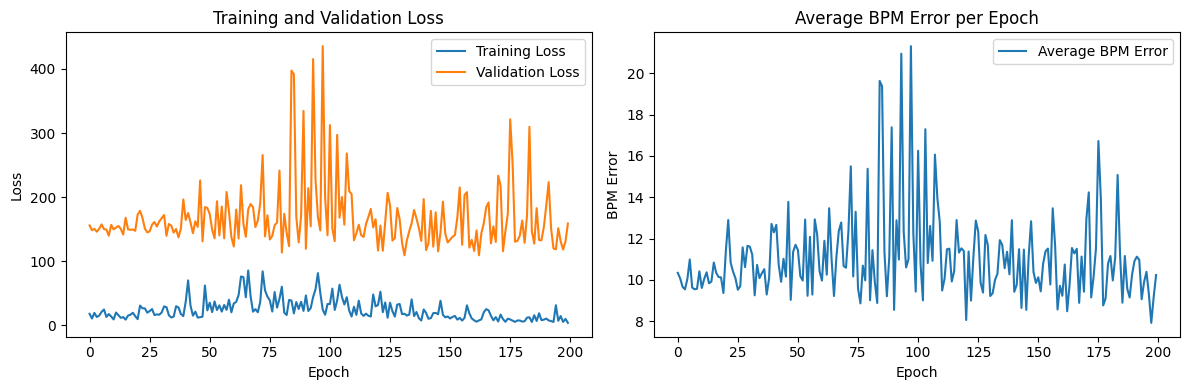


Training Complete!
Best Validation Loss: 109.2128
Final Average BPM Error: 10.2
Average Training Loss: 23.8511
Average Validation Loss: 167.5393
Training plot saved to: logs\training_plot_20241201_173629.png

Final Training Log:


,Epoch,Training_Loss,Validation_Loss,Avg_BPM_Error,Max_BPM_Error,Learning_Rate
0,1,17.999872,155.852312,10.339732,77.989410,0.000050
1,2,10.627594,148.480933,10.073826,78.032318,0.000050
2,3,19.413581,150.517797,9.667022,78.246140,0.000050
3,4,12.996497,146.019356,9.542308,78.294830,0.000051
4,5,15.163525,150.519683,10.050860,79.888077,0.000051
...,...,...,...,...,...,...
195,196,7.070670,151.402599,10.390025,70.981110,0.000498
196,197,14.457032,131.092650,9.307965,75.499268,0.000498
197,198,5.350321,118.300957,7.921118,72.537125,0.000498
198,199,10.027674,130.999259,9.174326,74.105408,0.000498


In [41]:
import gc
max_norm = 1.0  # Gradient clipping threshold
torch.cuda.empty_cache()
gc.collect()  # garbage collect
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    if epoch % 5 == 0:  # Every 5 epochs
        torch.cuda.empty_cache() # clear cache
        gc.collect() # garbage collect
    # Training phase
    print("Training phase")
    model.train() 
    train_loss = 0.0
    train_bpm_errors = []
    
    for features, targets in train_loader:
        
        features = features.to(device)
        targets = targets.squeeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        
        # get loss from normalized values
        loss = criterion(outputs, targets)
        
        # Denormalize for BPM error calculation
        outputs_denorm = outputs.detach().cpu().numpy().squeeze()  # Added squeeze()
        targets_denorm = targets.detach().cpu().numpy().squeeze()  # Added squeeze()
        true_tempos = (targets_denorm * 77) + 78
        pred_tempos = (outputs_denorm * 77) + 78
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        ema.update()
        
        train_loss += loss.item()
        bpm_errors = np.abs(true_tempos - pred_tempos)
        train_bpm_errors.extend(bpm_errors)

    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    print("Validation phase")
    model.eval()
    val_loss = 0.0
    val_bpm_errors = []
    
    with torch.no_grad(): 
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.squeeze(1).to(device)
            print("Normalized targets:", targets[0])
            outputs = model(features)
            print("Raw predictions:", outputs[0])
            # get loss from normalized values
            loss = criterion(outputs, targets)
            
            # Denormalize for BPM error calculation
            outputs_denorm = outputs.detach().cpu().numpy().squeeze()
            targets_denorm = targets.detach().cpu().numpy().squeeze() 
            true_tempos = (targets_denorm * 77) + 78 
            pred_tempos = (outputs_denorm * 77) + 78
    
            val_loss += loss.item()
            bpm_errors = np.abs(true_tempos - pred_tempos)
            val_bpm_errors.extend(bpm_errors)
            
            
            
    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_bpm_error = np.mean(val_bpm_errors)
    max_bpm_error = np.max(val_bpm_errors)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    epoch_errors.append(avg_bpm_error)
    
    # Add row to training log DataFrame using concat
    log_row = pd.DataFrame([{
    'Epoch': int(epoch + 1),
    'Training_Loss': float(avg_train_loss),
    'Validation_Loss': float(avg_val_loss),
    'Avg_BPM_Error': float(avg_bpm_error),
    'Max_BPM_Error': float(max_bpm_error),
    'Learning_Rate': float(current_lr)
    }])
    training_log = pd.concat([training_log, log_row], ignore_index=True)
    
    # Update learning rate
    scheduler.step()
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Average BPM Error: {avg_bpm_error:.1f}')
    print(f'Max BPM Error: {max_bpm_error:.1f}')
    print(f'Learning Rate: {current_lr}')
    print('-' * 50)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'bpm_error': avg_bpm_error
        }, f'models/teller_net_{timestamp}_best.pth')
        print(f'New best model saved! Validation Loss: {avg_val_loss:.4f}\n')

# Save training log to CSV
csv_path = os.path.join(log_dir, f'training_log_{timestamp}.csv')
training_log.to_csv(csv_path, index=False)
print(f"Training log saved to: {csv_path}")

# Plot and save final results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_errors, label='Average BPM Error')
plt.xlabel('Epoch')
plt.ylabel('BPM Error')
plt.legend()
plt.title('Average BPM Error per Epoch')

plt.tight_layout()

# Save plot
plot_path = os.path.join(log_dir, f'training_plot_{timestamp}.png')
plt.savefig(plot_path)
plt.show()

print(f"\nTraining Complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Final Average BPM Error: {epoch_errors[-1]:.1f}")
print(f"Average Training Loss: {np.mean(train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(val_losses):.4f}")



print(f"Training plot saved to: {plot_path}")

# Display final dataframe
print("\nFinal Training Log:")
display(training_log)

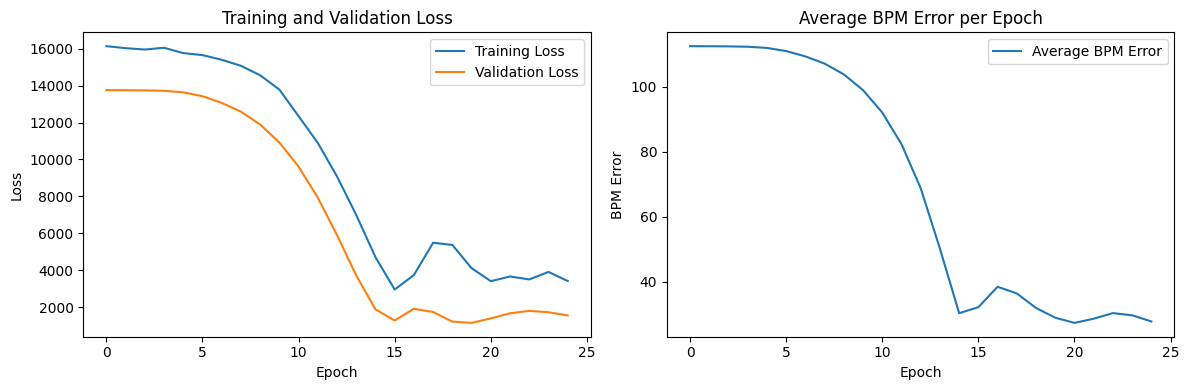


Final Metrics:
Training Loss: 3416.7030
Validation Loss: 1552.5548
BPM Error: 27.88

Best Performance:
Best Validation Loss: 1147.3737 (Epoch 20)
Best BPM Error: 27.44

Training Stability:
Loss Volatility: 755.5367

Overfitting Analysis:
Overfitting Index: 1952.4731


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. First, let's plot the basic training curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history[1], label='Training Loss')
plt.plot(history[2], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# BPM Error plot
plt.subplot(1, 2, 2)
plt.plot(history[3], label='Average BPM Error')
plt.xlabel('Epoch')
plt.ylabel('BPM Error')
plt.title('Average BPM Error per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


final_train_loss = history[1][-1]
final_val_loss = history[2][-1]
final_bpm_error = history[3][-1]

best_val_loss = min(history[2])
best_val_epoch = np.argmin(history[2]) + 1
best_bpm_error = min(history[3])

print("\nFinal Metrics:")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"BPM Error: {final_bpm_error:.2f}")

print("\nBest Performance:")
print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_val_epoch})")
print(f"Best BPM Error: {best_bpm_error:.2f}")


loss_changes = np.diff(history[2])
loss_volatility = np.std(loss_changes)

print("\nTraining Stability:")
print(f"Loss Volatility: {loss_volatility:.4f}")

# 4. Check for overfitting
train_val_diff = np.array(history[1]) - np.array(history[2])
overfitting_index = np.mean(train_val_diff[-5:])  # Average difference in final 5 epochs

print("\nOverfitting Analysis:")
print(f"Overfitting Index: {overfitting_index:.4f}")


50 epochs:
![Initial training results](training_results_20241124_180211.png)

25 epochs:
![second run training results](training_results_20241124_195052.png)

### Training and Validation Loss

- The fact that validation loss is lower than the training loss is not a good sign.  
    - I don't have enough data to train the model to be able to tell the difference between a good song and a bad one.

### Average BPM Error
- Starts off with a very high error, but this could be due to lack of feature engineering:
    - e.g. When detecting beats, the model may report 142 BPM when the actual tempo is 70 BPM.
    - I need to figure a solution, as Dubstep is "technically" 140, but it "feels" like 70 because it's in halftime (snare on the 3 instead of the 2)
- Quickly gets its act together in the first 15 epochs.
- Settles down at ~25 BPM error. Like, if a song’s 140 BPM, it might think it's 115-165. Close, but not DJ-ready.

### Overall

- Error drops from "yikes" to "we're getting somewhere", but it's still not where I want it to be.
- Loss curves indicate the model is learning nicely, so hopefully with a larger dataset, it will continue to improve
- 25 BPM error is far from useable in any setting, but it's a start.


I think it would be useful to compare the raw librosa tempo prediction with the ML model's tempo prediction.


Below, i started working on a simpler version of the teller net. Its results are inconclusive so far.

In [ ]:
class SimplerTellerNet(nn.Module):
    def __init__(self):
        super(SimplerTellerNet, self).__init__()
        
        self.freq_convs = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d((2,8)),
            
            nn.Conv2d(8, 16, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,8))
        )
        
        # Now we know the exact size: 16 * 8 * 20 = 2560
        self.fc1 = nn.Linear(2560, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1)           # [B, 1, 32, 1292]
        x = self.freq_convs(x)       # [B, 16, 8, 20]
        x = x.view(batch_size, -1)   # [B, 2560]
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


Epoch 1/250
Training Loss: 0.1664
Validation Loss: 0.1632
BPM Error - Avg: 26.2, Max: 43.9, Min: 1.5
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 2/250
Training Loss: 0.1494
Validation Loss: 0.1646
BPM Error - Avg: 26.1, Max: 46.2, Min: 0.3
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 3/250
Training Loss: 0.1347
Validation Loss: 0.1598
BPM Error - Avg: 25.3, Max: 46.7, Min: 0.6
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 4/250
Training Loss: 0.1236
Validation Loss: 0.1508
BPM Error - Avg: 24.0, Max: 46.4, Min: 0.6
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 5/250
Training Loss: 0.1151
Validation Loss: 0.1523
BPM Error - Avg: 23.5, Max: 48.9, Min: 0.5
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 6/250
Training Loss: 0.1055
Validation Loss: 0.1479
BPM Error - Avg: 22.9, Max: 48.8, Min: 0.9
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 7/250
Training Loss: 0.1021
Validation Loss: 0.1276
BPM Error - Avg: 21.5, Max: 4

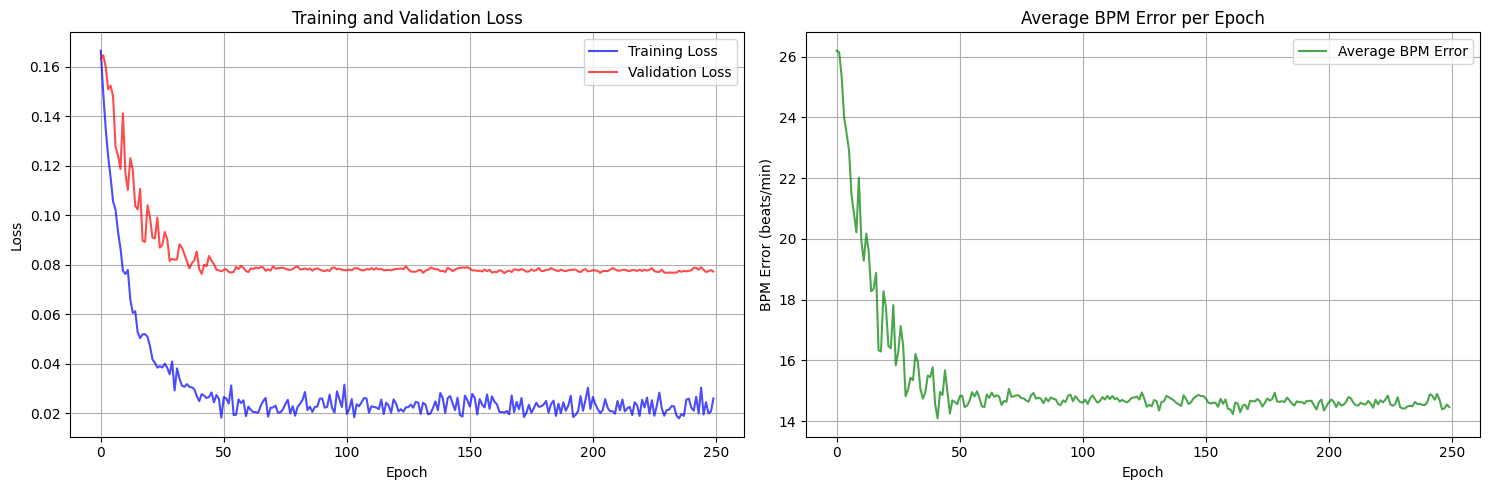

Training complete! Best validation loss: 0.0762
Final average BPM error: 15.3
Average training loss: 0.0292
Average validation loss: 0.0824


In [ ]:
simple_model = SimplerTellerNet()
from datetime import datetime
import torch.optim as optim
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MSELoss


def train_simpler_model(model, train_loader, val_loader, num_epochs=200, early_stop_patience=15):
    # Setup directories
    save_dir = os.path.join('models', 'saved')
    log_dir = os.path.join('logs')
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        model = model.to(device)
    except AttributeError as e:
        print(f"Model {model} does not have a 'to' method. Skipping to next model.")

    
    # Loss and optimizer
    criterion = nn.MSELoss()
    criterion_l1 = nn.L1Loss() 
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=0.01,
        amsgrad=True
    )

# Modify scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    
    optimizer,
    mode='min',
    patience=5,       
    factor=0.5,       
    min_lr=1e-6,
    )
    
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = 0.1
    
    # Metrics storage
    train_losses = []
    val_losses = []
    epoch_errors = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    # Create timestamp and files
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_file = os.path.join(log_dir, f'simple_training_log_{timestamp}.txt')
    metrics_file = os.path.join(log_dir, f'simple_training_metrics_{timestamp}.csv')
    
    # Initialize CSV
    with open(metrics_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'Epoch', 'Training Loss', 'Validation Loss', 
            'Average BPM Error', 'Max BPM Error', 'Min BPM Error',
            'Learning Rate', 'Gradient Norm'
        ])
    
    # Log training setup
    with open(log_file, 'w') as f:
        f.write(f"Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Device: {device}\n")
        f.write(f"Model Parameters: {sum(p.numel() for p in model.parameters())}\n")
        f.write(f"Training Samples: {len(train_loader.dataset)}\n")
        f.write(f"Validation Samples: {len(val_loader.dataset)}\n")
        f.write(f"Batch Size: {train_loader.batch_size}\n")
        f.write("Training Progress:\n" + "-" * 80 + "\n")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_bpm_errors = []
        total_norm = 0.0
        
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.squeeze(1).to(device)
            
            outputs = model(features)
            mse_loss = criterion(outputs, targets)
            l1_loss = criterion_l1(outputs, targets)
            loss = mse_loss + 0.1 * l1_loss
            
            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Get gradient norm for monitoring
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            total_norm = total_norm ** 0.5
            
            optimizer.step()
            
            train_loss += loss.item()
            pred_bpm = outputs.detach().cpu().numpy() * 77 + 78
            true_bpm = targets.cpu().numpy() * 77 + 78
            bpm_errors = np.abs(pred_bpm - true_bpm)
            train_bpm_errors.extend(bpm_errors)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_bpm_errors = []
        
        with torch.no_grad():
            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.squeeze(1).to(device)
                outputs = model(features)
                mse_loss = criterion(outputs, targets)
                l1_loss = criterion_l1(outputs, targets)
                loss = mse_loss + 0.1 * l1_loss
                val_loss += loss.item()  # Make sure this accumulation happens
                
                # Denormalize BPM values
                pred_bpm = outputs.cpu().numpy() * 77 + 78
                true_bpm = targets.cpu().numpy() * 77 + 78
                bpm_errors = np.abs(pred_bpm - true_bpm)
                val_bpm_errors.extend(bpm_errors)
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_bpm_error = np.mean(val_bpm_errors)
        max_bpm_error = np.max(val_bpm_errors)
        min_bpm_error = np.min(val_bpm_errors)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        epoch_errors.append(avg_bpm_error)
        
        # Write metrics
        with open(metrics_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch+1, avg_train_loss, avg_val_loss, 
                avg_bpm_error, max_bpm_error, min_bpm_error,
                current_lr, total_norm
            ])
        
        # Log epoch results
        log_msg = (f"\nEpoch {epoch+1}/{num_epochs}\n"
                  f"Training Loss: {avg_train_loss:.4f}\n"
                  f"Validation Loss: {avg_val_loss:.4f}\n"
                  f"BPM Error - Avg: {avg_bpm_error:.1f}, Max: {max_bpm_error:.1f}, Min: {min_bpm_error:.1f}\n"
                  f"Learning Rate: {current_lr:.2e}, Gradient Norm: {total_norm:.2e}\n")
        
        with open(log_file, 'a') as f:
            f.write(log_msg)
        print(log_msg)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Model saving and early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            model_path = os.path.join(save_dir, f'simple_net_{timestamp}_best.pth')
            
            torch.save({
                'Epoch': int(epoch + 1),
                'Training_Loss': float(avg_train_loss),
                'Validation_Loss': float(avg_val_loss),
                'Avg_BPM_Error': float(avg_bpm_error),
                'Max_BPM_Error': float(max_bpm_error),
                'Learning_Rate': float(current_lr)
            }, model_path)
            
            with open(log_file, 'a') as f:
                f.write(f"New best model saved! Validation Loss: {avg_val_loss:.4f}\n")
        else:
            epochs_without_improvement += 1
        
        # Early stopping check
        if epochs_without_improvement >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break
    
    return model, train_losses, val_losses, epoch_errors
def visualize_training(train_losses, val_losses, epoch_errors, timestamp):
    plt.figure(figsize=(15, 5))
    
    # Create subplot layout
    plt.subplot(1, 2, 1)
    
    # Loss plot
    plt.plot(train_losses, label='Training Loss', alpha=0.7, color='blue')
    plt.plot(val_losses, label='Validation Loss', alpha=0.7, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # BPM Error plot
    plt.subplot(1, 2, 2)
    plt.plot(epoch_errors, label='Average BPM Error', color='green', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('BPM Error (beats/min)')
    plt.title('Average BPM Error per Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    # Save and display
    plt.savefig(f'simple_training_results_{timestamp}.png', dpi=300, bbox_inches='tight', format='png')
    plt.show()
    plt.close()

model, train_losses, val_losses, epoch_errors = train_simpler_model(simple_model, train_loader, val_loader, num_epochs=250, early_stop_patience=1000)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
visualize_training(train_losses, val_losses, epoch_errors, timestamp)
print(f"Training complete! Best validation loss: {np.min(val_losses):.4f}")
print(f"Final average BPM error: {np.mean(epoch_errors):.1f}")
print(f"Average training loss: {np.mean(train_losses):.4f}")
print(f"Average validation loss: {np.mean(val_losses):.4f}")


K fold might yield even better results.


Training Fold 1/5

Epoch 1/100
Training Loss: 0.1502
Validation Loss: 0.1511
BPM Error - Avg: 25.0, Max: 37.4, Min: 1.0
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 2/100
Training Loss: 0.1427
Validation Loss: 0.1504
BPM Error - Avg: 24.9, Max: 38.5, Min: 0.7
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 3/100
Training Loss: 0.1315
Validation Loss: 0.1594
BPM Error - Avg: 25.2, Max: 43.6, Min: 1.0
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 4/100
Training Loss: 0.1237
Validation Loss: 0.1577
BPM Error - Avg: 24.7, Max: 47.5, Min: 0.8
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 5/100
Training Loss: 0.1156
Validation Loss: 0.1588
BPM Error - Avg: 24.5, Max: 48.7, Min: 0.2
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 6/100
Training Loss: 0.1136
Validation Loss: 0.1474
BPM Error - Avg: 23.6, Max: 48.8, Min: 1.8
Learning Rate: 1.00e-04, Gradient Norm: 1.62e+00


Epoch 7/100
Training Loss: 0.0983
Validation Loss: 0.1372
BPM Error 

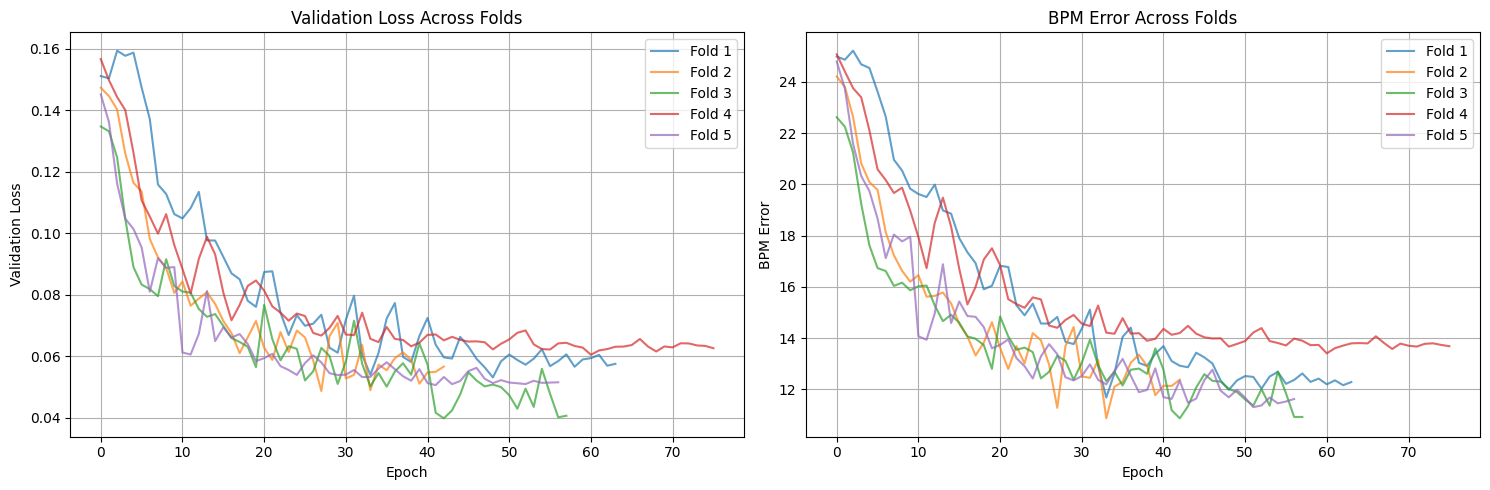

In [ ]:
from sklearn.model_selection import KFold
import copy
import numpy as np

def k_fold_train(dataset, k=5, num_epochs=100, batch_size=16, early_stop_patience=15):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []
    
    # Convert dataset to numpy arrays for splitting
    all_features = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
    all_targets = np.array([dataset[i][1].numpy() for i in range(len(dataset))])
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(all_features)):
        print(f"\nTraining Fold {fold + 1}/{k}")
        
        # Create data loaders for this fold
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        
        train_loader = DataLoader(
            train_subset, 
            batch_size=batch_size, 
            shuffle=True
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=batch_size, 
            shuffle=False
        )
        
        # Initialize a new model for each fold
        model = SimplerTellerNet()
        
        # Train the model
        model, train_losses, val_losses, epoch_errors = train_simpler_model(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            early_stop_patience=early_stop_patience
        )
        
        # Store results
        fold_results.append({
            'model': copy.deepcopy(model),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'epoch_errors': epoch_errors,
            'final_bpm_error': epoch_errors[-1],
            'best_val_loss': min(val_losses)
        })
        
        # Print fold results
        print(f"\nFold {fold + 1} Results:")
        print(f"Best Validation Loss: {min(val_losses):.4f}")
        print(f"Final BPM Error: {epoch_errors[-1]:.1f}")
    
    # Analyze results across folds
    bpm_errors = [r['final_bpm_error'] for r in fold_results]
    val_losses = [r['best_val_loss'] for r in fold_results]
    
    print("\nOverall K-Fold Results:")
    print(f"Average BPM Error: {np.mean(bpm_errors):.1f} ± {np.std(bpm_errors):.1f}")
    print(f"Average Best Val Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
    
    # Visualize results across folds
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for i, result in enumerate(fold_results):
        plt.plot(result['val_losses'], label=f'Fold {i+1}', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Across Folds')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for i, result in enumerate(fold_results):
        plt.plot(result['epoch_errors'], label=f'Fold {i+1}', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('BPM Error')
    plt.title('BPM Error Across Folds')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fold_results

fold_results = k_fold_train(dataset, k=5, num_epochs=100, batch_size=16)

In [ ]:
print("\nPrediction Statistics:")
print(f"Prediction Mean: {np.mean(actual_predictions[:,0]):.2f}")
print(f"Prediction Std: {np.std(actual_predictions[:,0]):.2f}")
print(f"Prediction Min: {np.min(actual_predictions[:,0]):.2f}")
print(f"Prediction Max: {np.max(actual_predictions[:,0]):.2f}")


Prediction Statistics:
Prediction Mean: 85.96
Prediction Std: 0.00
Prediction Min: 85.96
Prediction Max: 85.96


![results](comparison_result_text.png)


Summary:
- Librosa is a good starting point, but suffers from systematic issues (e.g. outliers from tempo vagueness)
- The trained model demonstrates the ability to generalize better, significantly reducing average error and handling edge cases (like halftime/double-time) more effectively than Librosa.